# Constrained Training of CP-Odd Flow

## Motivation

The interference term $C$ is computed from three independent flows:

$$C = \frac{\Gamma_+ \, p_{\rm even} - \Gamma_- \, p_{\rm odd}}{\Gamma_+ + \Gamma_-}$$

Physics requires $|C| \leq |A| |\bar{A}|$, i.e. $|C| \leq {\rm abJ} = {\rm mag}_{12} \cdot {\rm mag}_{13}$ (from `flow_flavor`).

Since `flow_flavor`, `flow_even`, and `flow_odd` are trained independently, nothing enforces this constraint — leading to unphysical points that must be cut or clamped.

**Solution:** Add a soft penalty to `flow_odd` training (with `flow_flavor` and `flow_even` frozen) that discourages $|C| > {\rm abJ}$.

### Loss function

$$\mathcal{L} = \underbrace{-\langle \log p_{\rm odd}(x) \rangle}_{\text{NLL}} + \lambda \underbrace{\langle \max(|C(x)| - {\rm abJ}(x),\, 0)^2 \rangle}_{\text{constraint penalty}}$$

---
## 1. Imports and Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import os
from pathlib import Path
from datetime import datetime

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms import CompositeTransform, RandomPermutation
from nflows.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from nflows.transforms.base import Transform
from nflows.transforms import Sigmoid, InverseTransform

# Plotting setup
sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
plt.rcParams['text.usetex'] = False  # Set to True if you have LaTeX
plt.rcParams['font.size'] = 12

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


---
## 2. Helper Functions

In [4]:
from Amplitude import DKpp, BKpp, DalitzSample, AmpSample, SquareDalitzPlot2

# --- Particle masses ---
mD, mKs, mpi = 1.86483, 0.497611, 0.13957018
SDP = SquareDalitzPlot2(mD, mKs, mpi, mpi)

# ============================================================================
# Numerical Stability Helper
# ============================================================================

def _finite_pos(x, eps=1e-14):
    """
    Ensure array has finite positive values for numerical stability.
    """
    x = np.asarray(x)
    x = np.where(np.isfinite(x), x, 0.0)   # Replace NaN/±inf with 0
    return np.maximum(x, eps)              # Enforce minimum positive value

# ============================================================================
# Coordinate Transformation Functions
# ============================================================================

def dp_to_sdp(points_dp, sdp_obj, idx=(1,2,3)):
    """
    Convert Dalitz Plot coordinates to Square Dalitz Plot coordinates.
    """
    i, j, k = idx
    s12 = points_dp[:, 0]
    s13 = points_dp[:, 1]
    mp = np.vectorize(lambda a, b: sdp_obj.MpfromM(a, b, i, j, k), otypes=[float])(s12, s13)
    tp = np.vectorize(lambda a, b: sdp_obj.TfromM(a, b, i, j, k), otypes=[float])(s12, s13)
    return np.column_stack([mp, tp])

def sdp_to_dp(points_sdp, sdp_obj, idx=(1,2,3)):
    """
    Convert Square Dalitz Plot coordinates to Dalitz Plot coordinates.
    """
    i, j, k = idx
    out = np.empty_like(points_sdp, dtype=float)
    for n, (mp, th) in enumerate(points_sdp):
        sij, sik = sdp_obj.M_from_MpT(mp, th, i, j, k)
        out[n, 0] = sij
        out[n, 1] = sik
    return out  # columns: [s_ij, s_ik]

def swap_to_other_pair_sdp(s12, s13, sdp_obj, pair_swap=(1,3,2)):
    """
    Convert Dalitz point to SDP coordinates for a different particle pairing.
    """
    i2, j2, k2 = pair_swap
    s12 = np.asarray(s12)
    s13 = np.asarray(s13)
    mp13 = np.empty_like(s12)
    th13 = np.empty_like(s12)
    for n in range(s12.size):
        mp13[n] = sdp_obj.MpfromM(s13[n], s12[n], i2, j2, k2)
        th13[n] = sdp_obj.TfromM(s13[n], s12[n], i2, j2, k2)
    return np.column_stack([mp13, th13])

def sdp_uniform_mc(N, eps=1e-6):
    """
    Generate uniform Monte Carlo points in Square Dalitz Plot coordinates.
    """
    return np.random.rand(N, 2) * (1 - 2*eps) + eps

# ============================================================================
# Amplitude Extraction from Normalizing Flows
# ============================================================================

def mag_AD_from_flow(points_sdp, flow, sdp_obj, idx=(1,2,3), device=None, tiny=1e-300):
    """
    Extract amplitude magnitude from normalizing flow probability density.
    """
    if device is None:
        device = next(flow.parameters()).device

    pts = torch.from_numpy(np.ascontiguousarray(points_sdp)).float().to(device)
    with torch.no_grad():
        logp = flow.log_prob(pts).cpu().numpy()
    p_sdp = np.exp(logp)

    u = points_sdp[:, 0]
    v = points_sdp[:, 1]
    sij = np.empty_like(u)
    sik = np.empty_like(u)
    
    for n, (uu, vv) in enumerate(points_sdp):
        s12, s13 = sdp_obj.M_from_MpT(uu, vv, *idx)
        sij[n], sik[n] = s12, s13

    J = np.empty_like(u)
    for n in range(u.size):
        J[n] = float(sdp_obj.jacobian(sij[n], sik[n], *idx))

    mag = np.sqrt(p_sdp / np.maximum(1/J, tiny))
    
    return mag, 1/J

---
## 3. Dataset and Model Architecture

Identical to the unconstrained version.

In [5]:
class DalitzDataset(Dataset):
    """
    PyTorch Dataset for Dalitz plot coordinates.
    """
    def __init__(self, data):
        if isinstance(data, np.ndarray):
            self.data = torch.FloatTensor(data)
        else:
            self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

In [6]:
class MLP(nn.Module):
    """
    Multi-layer perceptron for conditioning in coupling layers.
    """
    def __init__(self, in_features, out_features,
                 hidden=64, layers=2, output_scale=0.30):
        super().__init__()
        feats = [nn.Linear(in_features, hidden), nn.SiLU()]
        for _ in range(layers - 1):
            feats += [nn.Linear(hidden, hidden), nn.SiLU()]
        self.backbone = nn.Sequential(*feats)
        self.head = nn.Linear(hidden, out_features)

        nn.init.zeros_(self.head.weight)
        nn.init.zeros_(self.head.bias)

        self.output_scale = output_scale

    def forward(self, x, context=None):
        h = self.backbone(x)
        return self.head(h) * self.output_scale

In [7]:
def create_flow(on_unit_box=True, num_flows=8, hidden_features=64, num_bins=8, device=None):
    """
    Create a normalizing flow model using Neural Spline Flows.
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    dim = 2
    transforms = []

    if on_unit_box:
        sigmoid = Sigmoid()
        if hasattr(sigmoid, 'temperature') and isinstance(sigmoid.temperature, torch.Tensor):
            sigmoid.temperature = sigmoid.temperature.to(device)
        if hasattr(sigmoid, 'eps') and isinstance(sigmoid.eps, torch.Tensor):
            sigmoid.eps = sigmoid.eps.to(device)
        transforms.append(InverseTransform(sigmoid))

    masks = [torch.tensor([1, 0], dtype=torch.bool),
             torch.tensor([0, 1], dtype=torch.bool)]

    for i in range(num_flows):
        mask = masks[i % 2]

        def conditioner(in_features, out_features, _hidden=hidden_features):
            return MLP(in_features, out_features, hidden=_hidden, layers=2)

        transforms.append(
            PiecewiseRationalQuadraticCouplingTransform(
                mask=mask,
                transform_net_create_fn=conditioner,
                num_bins=num_bins,
                tails="linear",
                tail_bound=5.0,
                apply_unconditional_transform=False,
            )
        )
        transforms.append(RandomPermutation(features=dim))

    transform = CompositeTransform(transforms)
    base = StandardNormal(shape=[dim])

    return Flow(transform, base)

---
## 4. Initialize Amplitude Model

In [8]:
dkpp = DKpp()
sdp_obj = SquareDalitzPlot2(dkpp.M(), dkpp.m1(), dkpp.m2(), dkpp.m3())

---
## 5. Load Frozen Flows (flavor + even)

These must already be trained. The constraint penalty requires evaluating them on each training batch.

In [9]:
# ---- Load flow_flavor ----
# Adjust hyperparameters to match your trained model
flow_flavor = create_flow(num_flows=12, hidden_features=128, num_bins=24)
flow_flavor.load_state_dict(
    torch.load('test_ensemble_2e6/trial_seed1.pth', map_location=device)
)
flow_flavor.to(device).eval()
for p in flow_flavor.parameters():
    p.requires_grad_(False)
print(f"flow_flavor loaded ({sum(p.numel() for p in flow_flavor.parameters()):,} params, frozen)")

# ---- Load flow_even ----
flow_even = create_flow(num_flows=12, hidden_features=128, num_bins=24)
flow_even.load_state_dict(
    torch.load('test_ensemble_even_2e6/trial_seed1.pth', map_location=device)
)
flow_even.to(device).eval()
for p in flow_even.parameters():
    p.requires_grad_(False)
print(f"flow_even loaded ({sum(p.numel() for p in flow_even.parameters()):,} params, frozen)")

flow_flavor loaded (311,124 params, frozen)
flow_even loaded (311,124 params, frozen)


---
## 6. Precompute Constraint Targets

The constraint penalty needs `p_even` and `abJ` at every training point. Since `flow_flavor` and `flow_even` are frozen, we compute these **once** before training and store them alongside the data.

This avoids the expensive `sdp_to_dp → swap → flow_flavor.log_prob` loop at every epoch.

### What we precompute

For each training point $(m', \theta')$:
- `p_even[i]` = $p_{\rm even}(m'_i, \theta'_i)$ from `flow_even`
- `abJ[i]` = $|A(s_{12}, s_{13})| \cdot |A(s_{13}, s_{12})|$ from `flow_flavor` (requires swap)

In [10]:
def precompute_constraint_targets(data_sdp, flow_flavor, flow_even, sdp_obj,
                                  idx=(1,2,3), device='cpu', batch_size=10000):
    N = len(data_sdp)

    def flow_pdf_batched(pts_sdp, flow, device_, batch_sz):
        """Batched exp(flow.log_prob) — raw SDP density."""
        n = len(pts_sdp)
        out = np.empty(n, dtype=np.float64)
        for s in tqdm(range(0, n, batch_sz), desc="flow_pdf"):
            e = min(s + batch_sz, n)
            pts = torch.from_numpy(pts_sdp[s:e].astype(np.float32)).to(device_)
            with torch.no_grad():
                out[s:e] = np.exp(flow.log_prob(pts).cpu().numpy())
            del pts; torch.cuda.empty_cache()
        return out

    # ---- p_even_sdp ----
    print("Computing p_even_sdp from flow_even...")
    p_even = flow_pdf_batched(data_sdp, flow_even, device, batch_size)

    # ---- p_flavor at original points → sqrt for mag12_sdp ----
    print("Computing p_flavor_sdp at original points...")
    p_flavor_12 = flow_pdf_batched(data_sdp, flow_flavor, device, batch_size)

    # ---- swap coordinates ----
    print("Computing swapped SDP coordinates...")
    dp = sdp_to_dp(data_sdp, sdp_obj, idx=idx)
    s12, s13 = dp[:, 0], dp[:, 1]
    U13 = swap_to_other_pair_sdp(s12, s13, sdp_obj, pair_swap=(1,3,2))

    # ---- p_flavor at swapped points → sqrt for mag13_sdp ----
    print("Computing p_flavor_sdp at swapped points...")
    p_flavor_13 = flow_pdf_batched(U13, flow_flavor, device, batch_size)

    # abJ_sdp = sqrt(p_flavor_12) * sqrt(p_flavor_13)
    abJ = np.sqrt(_finite_pos(p_flavor_12)) * np.sqrt(_finite_pos(p_flavor_13))

    del dp, s12, s13, U13, p_flavor_12, p_flavor_13
    torch.cuda.empty_cache()

    print(f"Done. p_even range: [{p_even.min():.6f}, {p_even.max():.6f}]")
    print(f"       abJ   range: [{abJ.min():.6f}, {abJ.max():.6f}]")

    return p_even.astype(np.float32), abJ.astype(np.float32)

### Compute $\Gamma_+$ and $\Gamma_-$

Needed for the $C$ formula.

In [11]:
def compute_Gamma_pm_from_amplitude(dkpp_model, sdp_obj, flow_flavor,
                                    idx=(1,2,3), nx=1000, ny=1000, device='cpu'):
    """
    Returns Gamma_plus, Gamma_minus computed from the amplitude model.
    """
    u = np.linspace(0, 1, nx)
    v = np.linspace(0, 1, ny)
    U, V = np.meshgrid(u, v, indexing='xy')
    pts_sdp = np.column_stack([U.ravel(), V.ravel()])

    S = sdp_to_dp(pts_sdp, sdp_obj, idx=idx)
    s12 = S[:, 0]
    s13 = S[:, 1]

    A12  = dkpp_model.full(np.column_stack([s12, s13]))
    A13s = dkpp_model.full(np.column_stack([s13, s12]))

    A_plus  = A12 + A13s
    A_minus = A12 - A13s

    _, invJ_here = mag_AD_from_flow(
        pts_sdp, flow_flavor, sdp_obj, idx=idx, device=device
    )

    I_plus  = np.abs(A_plus)**2  * invJ_here
    I_minus = np.abs(A_minus)**2 * invJ_here

    du = 1.0/(nx-1)
    dv = 1.0/(ny-1)
    dA = du * dv

    Gamma_plus  = np.sum(I_plus)  * dA
    Gamma_minus = np.sum(I_minus) * dA

    return Gamma_plus, Gamma_minus

In [12]:
gamma_p, gamma_m = compute_Gamma_pm_from_amplitude(
    dkpp, sdp_obj, flow_flavor, idx=(1,2,3), nx=1000, ny=1000, device=device
)
print(f"Gamma_plus  = {gamma_p:.4f}")
print(f"Gamma_minus = {gamma_m:.4f}")

c:\Users\chinh\anaconda3\Lib\site-packages\nflows\transforms\coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
c:\Users\chinh\OneDrive\Documents\GitHub\Extraction-of-Gamma-with-Normalising-flows\Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
c:\Users\chinh\OneDrive\Documents\GitHub\Extraction-of-Gamma-with-Normalising-flows\Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)


Gamma_plus  = 949.7816
Gamma_minus = 2008.2160


---
## 7. Load Training Data and Precompute Targets

In [13]:
# Load the CP-odd training data
data_path = "D_Kspipi_odd_SDP_2e7.npy"   # <-- adjust to your file
full_data = np.load(data_path)
print(f"Loaded {len(full_data):,} events from {data_path}")

Loaded 20,000,000 events from D_Kspipi_odd_SDP_2e7.npy


In [22]:
# Subsample for precomputation (use same size as your bootstrap_size)
# For the full ensemble, each trial will index into these precomputed arrays.
# Precompute on the FULL dataset so any bootstrap subset can index into it.

print("Precomputing constraint targets on full dataset...")
print("(This is slow the first time due to sdp_to_dp loops, but only done ONCE)")

all_p_even, all_abJ = precompute_constraint_targets(
    full_data, flow_flavor, flow_even, sdp_obj,
    idx=(1,2,3), device=device, batch_size=50000
)

# Save for reuse
np.savez("constraint_targets.npz", p_even=all_p_even, abJ=all_abJ)
print("Saved to constraint_targets.npz")

Precomputing constraint targets on full dataset...
(This is slow the first time due to sdp_to_dp loops, but only done ONCE)
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 400/400 [00:18<00:00, 21.57it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 400/400 [00:15<00:00, 25.47it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 400/400 [00:16<00:00, 24.84it/s]


Done. p_even range: [0.000000, 17.660563]
       abJ   range: [0.000000, 8.692824]
Saved to constraint_targets.npz


In [ ]:
# If you've already precomputed, just load:
# targets = np.load("constraint_targets.npz")
# all_p_even = targets["p_even"]
# all_abJ = targets["abJ"]

---
## 8. Augmented Dataset

We need each batch to carry `(sdp_point, p_even, abJ)` so the training loop can compute the penalty without re-evaluating frozen flows.

In [13]:
class DalitzDatasetWithTargets(Dataset):
    """
    Dataset that returns (sdp_point, p_even, abJ) per event.
    """
    def __init__(self, data_sdp, p_even, abJ):
        self.data = torch.FloatTensor(data_sdp)
        self.p_even = torch.FloatTensor(p_even)
        self.abJ = torch.FloatTensor(abJ)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.p_even[idx], self.abJ[idx]

---
## 9. Constrained Training Function

The core new function. Compared to `train_flow_fixed_epochs`, it adds:
1. A differentiable constraint penalty through `flow_odd.log_prob`
2. A penalty schedule $\lambda(\text{epoch})$ to ramp up gradually
3. Monitoring of violation fraction per epoch

In [14]:
def train_flow_odd_constrained(
    flow_odd,
    train_loader,
    Gamma_plus=1.0,
    Gamma_minus=1.0,
    lam=10.0,
    warmup_epochs=20,
    num_epochs=200,
    lr=1e-2,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Train flow_odd with a soft penalty enforcing |C| <= abJ.
    
    The constraint:
        C = (Gamma_+ * p_even - Gamma_- * p_odd) / (Gamma_+ + Gamma_-)
        Penalty = lam * mean[ max(|C| - abJ, 0)^2 ]
    
    Gradients flow through p_odd = exp(flow_odd.log_prob(x)), which is
    differentiable w.r.t. flow_odd parameters. p_even and abJ are 
    precomputed constants (from frozen flows).
    
    Parameters
    ----------
    flow_odd : Flow
        The flow model to train.
    train_loader : DataLoader
        Must yield (xb, p_even_b, abJ_b) tuples.
    Gamma_plus, Gamma_minus : float
        CP-even/odd decay widths.
    lam : float
        Maximum penalty strength.
    warmup_epochs : int
        Number of epochs to linearly ramp lambda from 0 to lam.
    num_epochs : int
        Total training epochs.
    lr : float
        Initial learning rate.
    device : str
        Torch device.
    
    Returns
    -------
    flow_odd : Flow (trained)
    history : dict
    """
    flow_odd.to(device)

    optimizer = torch.optim.Adam(flow_odd.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.65, patience=3, min_lr=1e-6
    )

    denom = Gamma_minus + Gamma_plus

    history = {
        'train_loss': [],
        'nll_loss': [],
        'penalty_loss': [],
        'violation_frac': [],
        'learning_rate': [],
        'lambda': [],
        'epochs_trained': num_epochs
    }

    for epoch in tqdm(range(1, num_epochs + 1), desc="Training", ncols=80):
        flow_odd.train()
        total_nll = 0.0
        total_pen = 0.0
        total_viol = 0
        total_pts = 0

        # Linear warmup: ramp lambda from 0 to lam over warmup_epochs
        current_lam = lam * min(epoch / warmup_epochs, 1.0)

        for xb, p_even_b, abJ_b in train_loader:
            xb = xb.to(device)
            p_even_b = p_even_b.to(device)  # precomputed, no grad
            abJ_b = abJ_b.to(device)        # precomputed, no grad
            B = xb.size(0)

            # ---- NLL term (standard flow training objective) ----
            log_p_odd = flow_odd.log_prob(xb)  # has gradients
            nll = -log_p_odd.mean()

            # ---- Constraint penalty ----
            # p_odd from the flow (differentiable)
            p_odd = torch.exp(log_p_odd)

            # C = (Gamma_+ * p_even - Gamma_- * p_odd) / (Gamma_+ + Gamma_-)
            # Only p_odd carries gradients; p_even_b and abJ_b are constants.
            C = (Gamma_plus * p_even_b - Gamma_minus * p_odd) / denom

            # Penalty: max(|C| - abJ, 0)^2
            violation = torch.clamp(torch.abs(C) - abJ_b, min=0.0)
            penalty = (violation ** 2).mean()

            # ---- Combined loss ----
            loss = nll + current_lam * penalty

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # ---- Bookkeeping (detached) ----
            total_nll += nll.item() * B
            total_pen += penalty.item() * B
            total_viol += (violation > 0).sum().item()
            total_pts += B

        avg_nll = total_nll / total_pts
        avg_pen = total_pen / total_pts
        viol_frac = total_viol / total_pts

        history['train_loss'].append(avg_nll + current_lam * avg_pen)
        history['nll_loss'].append(avg_nll)
        history['penalty_loss'].append(avg_pen)
        history['violation_frac'].append(viol_frac)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        history['lambda'].append(current_lam)

        scheduler.step(avg_nll + current_lam * avg_pen)

        if epoch % 3 == 0 or epoch == 1:
            print(f"[{epoch:03d}] NLL: {avg_nll:.6f}  Pen: {avg_pen:.2e}  "
                  f"Viol: {viol_frac:.4f}  λ: {current_lam:.1f}  "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    return flow_odd, history

---
## 10. Constrained Ensemble Training

In [ ]:
def train_ensemble_constrained(
    data_sdp,
    all_p_even,
    all_abJ,
    output_dir,
    Gamma_plus=1.0,
    Gamma_minus=1.0,
    num_trials=25,
    bootstrap_size=None,
    batch_size=10000,
    lr=0.01,
    num_epochs=200,
    lam=10.0,
    warmup_epochs=20,
    num_flows=16,
    hidden_features=128,
    num_bins=16,
    device="cuda" if torch.cuda.is_available() else "cpu",
    seed_offset=0
):
    """
    Train ensemble of constrained flow_odd models using bootstrap resampling.
    
    Parameters
    ----------
    data_sdp : ndarray, shape (N, 2)
        Full CP-odd training data in SDP coordinates.
    all_p_even : ndarray, shape (N,)
        Precomputed p_even for each point.
    all_abJ : ndarray, shape (N,)
        Precomputed abJ for each point.
    output_dir : str
        Directory to save model checkpoints.
    Gamma_plus, Gamma_minus : float
        CP-even/odd decay widths.
    lam : float
        Maximum penalty strength.
    warmup_epochs : int
        Epochs to ramp penalty from 0 to lam.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    N = len(data_sdp)
    if bootstrap_size is None:
        bootstrap_size = N

    print(f"Constrained ensemble training")
    print(f"  Data: {N:,} events")
    print(f"  Bootstrap size: {bootstrap_size:,}")
    print(f"  Epochs: {num_epochs}, lambda: {lam}, warmup: {warmup_epochs}")
    print(f"  Gamma_plus: {Gamma_plus:.4f}, Gamma_minus: {Gamma_minus:.4f}")

    config = {
        'num_trials': num_trials,
        'data_size': N,
        'bootstrap_size': bootstrap_size,
        'num_epochs': num_epochs,
        'lr': lr,
        'lam': lam,
        'warmup_epochs': warmup_epochs,
        'Gamma_plus': float(Gamma_plus),
        'Gamma_minus': float(Gamma_minus),
        'num_flows': num_flows,
        'hidden_features': hidden_features,
        'num_bins': num_bins,
        'timestamp': datetime.now().isoformat()
    }
    with open(output_dir / 'config.json', 'w') as f:
        json.dump(config, f, indent=2)

    results = {'trial_histories': [], 'final_losses': [], 'final_viol_frac': []}

    for trial in range(1, num_trials + 1):
        print(f"\n{'='*60}")
        print(f"TRIAL {trial}/{num_trials}")

        seed = trial + seed_offset
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Bootstrap: sample WITHOUT replacement
        indices = np.random.choice(N, size=bootstrap_size, replace=False)
        train_data = data_sdp[indices]
        train_p_even = all_p_even[indices]
        train_abJ = all_abJ[indices]
        print(f"Bootstrap sample: {len(train_data):,} "
              f"({len(np.unique(indices))/N:.1%} unique)")

        train_loader = DataLoader(
            DalitzDatasetWithTargets(train_data, train_p_even, train_abJ),
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=(device == "cuda")
        )

        flow_odd = create_flow(
            num_flows=num_flows,
            hidden_features=hidden_features,
            num_bins=num_bins
        )

        if trial == 1:
            print(f"Model params: {sum(p.numel() for p in flow_odd.parameters()):,}")

        flow_odd, history = train_flow_odd_constrained(
            flow_odd, train_loader,
            Gamma_plus=Gamma_plus,
            Gamma_minus=Gamma_minus,
            lam=lam,
            warmup_epochs=warmup_epochs,
            num_epochs=num_epochs,
            lr=lr,
            device=device
        )

        # Save
        torch.save(flow_odd.state_dict(), output_dir / f"trial_seed{seed}.pth")
        with open(output_dir / f"trial_seed{seed}_history.json", 'w') as f:
            json.dump(history, f, indent=2)

        results['trial_histories'].append(history)
        results['final_losses'].append(history['nll_loss'][-1])
        results['final_viol_frac'].append(history['violation_frac'][-1])
        print(f"Final NLL: {history['nll_loss'][-1]:.6f}, "
              f"Final violation: {history['violation_frac'][-1]:.4f}")

    print(f"\n{'='*60}")
    print(f"ENSEMBLE COMPLETE")
    print(f"  NLL: {np.mean(results['final_losses']):.6f} "
          f"± {np.std(results['final_losses']):.6f}")
    print(f"  Violation frac: {np.mean(results['final_viol_frac']):.6f} "
          f"± {np.std(results['final_viol_frac']):.6f}")

    summary = {
        'mean_nll': float(np.mean(results['final_losses'])),
        'std_nll': float(np.std(results['final_losses'])),
        'mean_viol': float(np.mean(results['final_viol_frac'])),
        'std_viol': float(np.std(results['final_viol_frac'])),
    }
    with open(output_dir / 'summary.json', 'w') as f:
        json.dump(summary, f, indent=2)

    return results

In [15]:
def train_ensemble_constrained(
    data_sdp,
    output_dir,
    pretrained_odd_dir="test_ensemble_odd_2e6",
    flavor_dir="test_ensemble_2e6",
    even_dir="test_ensemble_even_1e6",
    sdp_obj=None,
    Gamma_plus=1.0,
    Gamma_minus=1.0,
    num_trials=25,
    bootstrap_size=None,
    batch_size=10000,
    lr=0.001,
    num_epochs=50,
    lam=100.0,
    warmup_epochs=10,
    num_flows_odd=16,
    hidden_features_odd=128,
    num_bins_odd=16,
    num_flows_flavor=12,
    hidden_features_flavor=128,
    num_bins_flavor=24,
    num_flows_even=16,
    hidden_features_even=128,
    num_bins_even=16,
    idx=(1,2,3),
    device="cuda" if torch.cuda.is_available() else "cpu",
    seed_offset=0
):
    """
    Fine-tune ensemble of pretrained flow_odd models with constraint penalty.
    
    For each trial:
      1. Randomly pick a flow_flavor from flavor_dir
      2. Randomly pick a flow_even from even_dir
      3. Precompute p_even and abJ for this combination
      4. Load pretrained flow_odd from pretrained_odd_dir
      5. Fine-tune with constraint penalty
      6. Save to output_dir
    """
    import glob

    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    N = len(data_sdp)
    if bootstrap_size is None:
        bootstrap_size = N

    # Discover available checkpoints
    flavor_ckpts = sorted(glob.glob(str(Path(flavor_dir) / "trial_seed*.pth")))
    even_ckpts = sorted(glob.glob(str(Path(even_dir) / "trial_seed*.pth")))
    odd_ckpts = sorted(glob.glob(str(Path(pretrained_odd_dir) / "trial_seed*.pth")))

    print(f"Constrained ensemble fine-tuning")
    print(f"  Data: {N:,} events, Bootstrap: {bootstrap_size:,}")
    print(f"  Available: {len(flavor_ckpts)} flavor, {len(even_ckpts)} even, {len(odd_ckpts)} odd")
    print(f"  Epochs: {num_epochs}, lr: {lr}, lambda: {lam}, warmup: {warmup_epochs}")
    print(f"  Gamma_plus: {Gamma_plus:.4f}, Gamma_minus: {Gamma_minus:.4f}")

    config = {
        'num_trials': num_trials,
        'pretrained_odd_dir': str(pretrained_odd_dir),
        'flavor_dir': str(flavor_dir),
        'even_dir': str(even_dir),
        'data_size': N,
        'bootstrap_size': bootstrap_size,
        'num_epochs': num_epochs,
        'lr': lr,
        'lam': lam,
        'warmup_epochs': warmup_epochs,
        'Gamma_plus': float(Gamma_plus),
        'Gamma_minus': float(Gamma_minus),
        'timestamp': datetime.now().isoformat()
    }
    with open(output_dir / 'config.json', 'w') as f:
        json.dump(config, f, indent=2)

    results = {'trial_histories': [], 'final_losses': [], 'final_viol_frac': [],
               'flavor_used': [], 'even_used': [], 'odd_used': []}

    for trial in range(1, num_trials + 1):
        print(f"\n{'='*60}")
        print(f"TRIAL {trial}/{num_trials}")

        seed = trial + seed_offset
        np.random.seed(seed)
        torch.manual_seed(seed)
        rng = np.random.RandomState(seed)

        # ---- Randomly pick one checkpoint from each ensemble ----
        flavor_path = rng.choice(flavor_ckpts)
        even_path = rng.choice(even_ckpts)
        odd_path = rng.choice(odd_ckpts)
        print(f"  flavor: {Path(flavor_path).name}")
        print(f"  even:   {Path(even_path).name}")
        print(f"  odd:    {Path(odd_path).name}")

        # ---- Load frozen flows for this trial ----
        flow_flavor = create_flow(
            num_flows=num_flows_flavor,
            hidden_features=hidden_features_flavor,
            num_bins=num_bins_flavor
        )
        flow_flavor.load_state_dict(torch.load(flavor_path, map_location=device))
        flow_flavor.to(device).eval()
        for p in flow_flavor.parameters():
            p.requires_grad_(False)

        flow_even = create_flow(
            num_flows=num_flows_even,
            hidden_features=hidden_features_even,
            num_bins=num_bins_even
        )
        flow_even.load_state_dict(torch.load(even_path, map_location=device))
        flow_even.to(device).eval()
        for p in flow_even.parameters():
            p.requires_grad_(False)

        # ---- Bootstrap data ----
        indices = rng.choice(N, size=bootstrap_size, replace=False)
        train_data = data_sdp[indices]
        print(f"  Bootstrap: {len(train_data):,} events")

        # ---- Precompute p_even and abJ for THIS flow combination ----
        print("  Precomputing constraint targets...")
        train_p_even, train_abJ = precompute_constraint_targets(
            train_data, flow_flavor, flow_even, sdp_obj,
            idx=idx, device=device, batch_size=batch_size
        )

        # ---- Free frozen flows from GPU ----
        del flow_flavor, flow_even
        torch.cuda.empty_cache()

        # ---- Build data loader ----
        train_loader = DataLoader(
            DalitzDatasetWithTargets(train_data, train_p_even, train_abJ),
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=(device == "cuda")
        )

        # ---- Load pretrained flow_odd ----
        flow_odd = create_flow(
            num_flows=num_flows_odd,
            hidden_features=hidden_features_odd,
            num_bins=num_bins_odd
        )
        flow_odd.load_state_dict(torch.load(odd_path, map_location=device))
        print(f"  Loaded pretrained odd weights from {Path(odd_path).name}")

        if trial == 1:
            print(f"  Model params: {sum(p.numel() for p in flow_odd.parameters()):,}")

        # ---- Fine-tune with constraint ----
        flow_odd, history = train_flow_odd_constrained(
            flow_odd, train_loader,
            Gamma_plus=Gamma_plus,
            Gamma_minus=Gamma_minus,
            lam=lam,
            warmup_epochs=warmup_epochs,
            num_epochs=num_epochs,
            lr=lr,
            device=device
        )

        # ---- Save ----
        torch.save(flow_odd.state_dict(), output_dir / f"trial_seed{seed}.pth")
        trial_info = {
            'flavor_ckpt': str(flavor_path),
            'even_ckpt': str(even_path),
            'odd_ckpt': str(odd_path),
            **history
        }
        with open(output_dir / f"trial_seed{seed}_history.json", 'w') as f:
            json.dump(trial_info, f, indent=2)

        results['trial_histories'].append(history)
        results['final_losses'].append(history['nll_loss'][-1])
        results['final_viol_frac'].append(history['violation_frac'][-1])
        results['flavor_used'].append(str(flavor_path))
        results['even_used'].append(str(even_path))
        results['odd_used'].append(str(odd_path))

        print(f"  Final NLL: {history['nll_loss'][-1]:.6f}, "
              f"Violation: {history['violation_frac'][-1]:.4f}")

        del flow_odd, train_loader, train_data, train_p_even, train_abJ
        torch.cuda.empty_cache()

    print(f"\n{'='*60}")
    print(f"ENSEMBLE COMPLETE")
    print(f"  NLL: {np.mean(results['final_losses']):.6f} "
          f"± {np.std(results['final_losses']):.6f}")
    print(f"  Violation: {np.mean(results['final_viol_frac']):.6f} "
          f"± {np.std(results['final_viol_frac']):.6f}")

    summary = {
        'mean_nll': float(np.mean(results['final_losses'])),
        'std_nll': float(np.std(results['final_losses'])),
        'mean_viol': float(np.mean(results['final_viol_frac'])),
        'std_viol': float(np.std(results['final_viol_frac'])),
    }
    with open(output_dir / 'summary.json', 'w') as f:
        json.dump(summary, f, indent=2)

    return results

---
## 11. Train a Single Model (Quick Test)

In [29]:
# Quick test with a small subset
test_size = 1_000_000
np.random.seed(42)
test_idx = np.random.choice(len(full_data), size=test_size, replace=False)

test_loader = DataLoader(
    DalitzDatasetWithTargets(
        full_data[test_idx],
        all_p_even[test_idx],
        all_abJ[test_idx]
    ),
    batch_size=50000,
    shuffle=True
)

flow_odd_test = create_flow(num_flows=12, hidden_features=128, num_bins=24)
flow_odd_test.load_state_dict(
    torch.load('test_ensemble_odd_2e6/trial_seed1.pth', map_location=device)
)
print(f"Model parameters: {sum(p.numel() for p in flow_odd_test.parameters()):,}")
print("Loaded pretrained weights from test_ensemble_odd_2e6/trial_seed1.pth")

flow_odd_test, history_test = train_flow_odd_constrained(
    flow_odd_test, test_loader,
    Gamma_plus=gamma_p,
    Gamma_minus=gamma_m,
    lam=1.0,
    warmup_epochs=5,
    num_epochs=50,
    lr=0.001,
    device=device
)

Model parameters: 311,124
Loaded pretrained weights from test_ensemble_odd_2e6/trial_seed1.pth


Training:   0%|                                          | 0/50 [00:00<?, ?it/s]c:\Users\chinh\anaconda3\Lib\site-packages\nflows\transforms\coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
Training:   2%|▋                                 | 1/50 [00:11<09:41, 11.86s/it]

[001] NLL: -0.919676  Pen: 2.60e-02  Viol: 0.2242  λ: 0.2  LR: 1.00e-03


Training:  10%|███▍                              | 5/50 [00:58<08:44, 11.65s/it]

[005] NLL: -0.939754  Pen: 8.14e-04  Viol: 0.1307  λ: 1.0  LR: 1.00e-03


Training:  20%|██████▌                          | 10/50 [01:55<07:40, 11.52s/it]

[010] NLL: -0.939997  Pen: 7.51e-04  Viol: 0.1282  λ: 1.0  LR: 6.50e-04


Training:  30%|█████████▉                       | 15/50 [02:54<06:48, 11.66s/it]

[015] NLL: -0.940105  Pen: 7.28e-04  Viol: 0.1318  λ: 1.0  LR: 6.50e-04


Training:  40%|█████████████▏                   | 20/50 [03:51<05:47, 11.57s/it]

[020] NLL: -0.940204  Pen: 7.18e-04  Viol: 0.1311  λ: 1.0  LR: 6.50e-04


Training:  50%|████████████████▌                | 25/50 [04:49<04:48, 11.55s/it]

[025] NLL: -0.940282  Pen: 6.81e-04  Viol: 0.1299  λ: 1.0  LR: 4.23e-04


Training:  60%|███████████████████▊             | 30/50 [05:48<03:53, 11.67s/it]

[030] NLL: -0.940417  Pen: 6.80e-04  Viol: 0.1368  λ: 1.0  LR: 4.23e-04


Training:  70%|███████████████████████          | 35/50 [06:45<02:53, 11.54s/it]

[035] NLL: -0.940458  Pen: 7.09e-04  Viol: 0.1331  λ: 1.0  LR: 4.23e-04


Training:  80%|██████████████████████████▍      | 40/50 [07:45<02:01, 12.16s/it]

[040] NLL: -0.940454  Pen: 6.74e-04  Viol: 0.1284  λ: 1.0  LR: 4.23e-04


Training:  90%|█████████████████████████████▋   | 45/50 [08:47<01:00, 12.14s/it]

[045] NLL: -0.940442  Pen: 7.08e-04  Viol: 0.1332  λ: 1.0  LR: 4.23e-04


Training: 100%|█████████████████████████████████| 50/50 [09:48<00:00, 11.76s/it]

[050] NLL: -0.940646  Pen: 6.55e-04  Viol: 0.1350  λ: 1.0  LR: 2.75e-04


In [52]:
# Quick test with a small subset
test_size = 1_000_000
np.random.seed(42)
test_idx = np.random.choice(len(full_data), size=test_size, replace=False)

test_loader = DataLoader(
    DalitzDatasetWithTargets(
        full_data[test_idx],
        all_p_even[test_idx],
        all_abJ[test_idx]
    ),
    batch_size=50000,
    shuffle=True
)

flow_odd_test = create_flow(num_flows=12, hidden_features=128, num_bins=24)
flow_odd_test.load_state_dict(
    torch.load('test_ensemble_odd_2e6/trial_seed1.pth', map_location=device)
)
print(f"Model parameters: {sum(p.numel() for p in flow_odd_test.parameters()):,}")
print("Loaded pretrained weights from test_ensemble_odd_2e6/trial_seed1.pth")

flow_odd_test, history_test = train_flow_odd_constrained(
    flow_odd_test, test_loader,
    Gamma_plus=gamma_p,
    Gamma_minus=gamma_m,
    lam=8.0,
    warmup_epochs=5,
    num_epochs=50,
    lr=0.001,
    device=device
)

Model parameters: 311,124
Loaded pretrained weights from test_ensemble_odd_2e6/trial_seed1.pth


Training:   2%|▋                                 | 1/50 [00:12<10:07, 12.39s/it]

[001] NLL: -0.886764  Pen: 1.76e-02  Viol: 0.2217  λ: 1.6  LR: 1.00e-03


Training:   6%|██                                | 3/50 [00:36<09:30, 12.13s/it]

[003] NLL: -0.936186  Pen: 3.27e-04  Viol: 0.0774  λ: 4.8  LR: 1.00e-03


Training:  12%|████                              | 6/50 [01:13<09:01, 12.30s/it]

[006] NLL: -0.938368  Pen: 1.37e-04  Viol: 0.0670  λ: 8.0  LR: 1.00e-03


Training:  18%|██████                            | 9/50 [01:49<08:18, 12.16s/it]

[009] NLL: -0.931496  Pen: 3.49e-04  Viol: 0.0715  λ: 8.0  LR: 1.00e-03


Training:  24%|███████▉                         | 12/50 [02:26<07:45, 12.26s/it]

[012] NLL: -0.938533  Pen: 1.13e-04  Viol: 0.0623  λ: 8.0  LR: 6.50e-04


Training:  30%|█████████▉                       | 15/50 [03:03<07:07, 12.22s/it]

[015] NLL: -0.938805  Pen: 1.13e-04  Viol: 0.0654  λ: 8.0  LR: 6.50e-04


Training:  36%|███████████▉                     | 18/50 [03:40<06:32, 12.25s/it]

[018] NLL: -0.938893  Pen: 1.15e-04  Viol: 0.0654  λ: 8.0  LR: 6.50e-04


Training:  42%|█████████████▊                   | 21/50 [04:17<05:57, 12.33s/it]

[021] NLL: -0.938727  Pen: 1.19e-04  Viol: 0.0624  λ: 8.0  LR: 6.50e-04


Training:  48%|███████████████▊                 | 24/50 [04:53<05:13, 12.04s/it]

[024] NLL: -0.938933  Pen: 1.15e-04  Viol: 0.0649  λ: 8.0  LR: 6.50e-04


Training:  54%|█████████████████▊               | 27/50 [05:30<04:40, 12.19s/it]

[027] NLL: -0.934718  Pen: 2.68e-04  Viol: 0.0767  λ: 8.0  LR: 6.50e-04


Training:  60%|███████████████████▊             | 30/50 [06:06<04:06, 12.34s/it]

[030] NLL: -0.938706  Pen: 1.10e-04  Viol: 0.0632  λ: 8.0  LR: 4.23e-04


Training:  66%|█████████████████████▊           | 33/50 [06:45<03:37, 12.77s/it]

[033] NLL: -0.939136  Pen: 1.10e-04  Viol: 0.0660  λ: 8.0  LR: 4.23e-04


Training:  72%|███████████████████████▊         | 36/50 [07:23<02:57, 12.68s/it]

[036] NLL: -0.939169  Pen: 1.07e-04  Viol: 0.0663  λ: 8.0  LR: 4.23e-04


Training:  78%|█████████████████████████▋       | 39/50 [08:00<02:15, 12.36s/it]

[039] NLL: -0.939121  Pen: 1.09e-04  Viol: 0.0655  λ: 8.0  LR: 4.23e-04


Training:  84%|███████████████████████████▋     | 42/50 [08:37<01:38, 12.32s/it]

[042] NLL: -0.939169  Pen: 1.11e-04  Viol: 0.0665  λ: 8.0  LR: 4.23e-04


Training:  90%|█████████████████████████████▋   | 45/50 [09:14<01:02, 12.46s/it]

[045] NLL: -0.938703  Pen: 1.21e-04  Viol: 0.0636  λ: 8.0  LR: 4.23e-04


Training:  96%|███████████████████████████████▋ | 48/50 [09:50<00:24, 12.19s/it]

[048] NLL: -0.939316  Pen: 1.06e-04  Viol: 0.0670  λ: 8.0  LR: 2.75e-04


Training: 100%|█████████████████████████████████| 50/50 [10:16<00:00, 12.32s/it]


In [53]:
torch.save(flow_odd_test.state_dict(), "test_seed_odd_constrained.pth")

---
## 12. Plot Training History

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# NLL loss
axes[0, 0].plot(history_test['nll_loss'], linewidth=2, color='steelblue')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('NLL')
axes[0, 0].set_title('Negative Log-Likelihood')
axes[0, 0].grid(True, alpha=0.3)

# Penalty loss
axes[0, 1].plot(history_test['penalty_loss'], linewidth=2, color='firebrick')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Penalty')
axes[0, 1].set_title('Constraint Penalty')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Violation fraction
axes[1, 0].plot(history_test['violation_frac'], linewidth=2, color='darkorange')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Fraction')
axes[1, 0].set_title('Violation Fraction (|C| > abJ)')
axes[1, 0].grid(True, alpha=0.3)

# Lambda schedule
axes[1, 1].plot(history_test['lambda'], linewidth=2, color='seagreen')
ax2 = axes[1, 1].twinx()
ax2.plot(history_test['learning_rate'], linewidth=2, color='gray', alpha=0.6)
ax2.set_ylabel('Learning Rate', color='gray')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel(r'$\lambda$', color='seagreen')
axes[1, 1].set_title(r'$\lambda$ Schedule & Learning Rate')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('constrained_training_history.pdf', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFinal NLL: {history_test['nll_loss'][-1]:.6f}")
print(f"Final violation fraction: {history_test['violation_frac'][-1]:.6f}")

---
## 13. Train Full Ensemble (Constrained)

In [ ]:
results = train_ensemble_constrained(
    data_sdp=full_data,
    all_p_even=all_p_even,
    all_abJ=all_abJ,
    output_dir="test_ensemble_odd_constrained/",
    Gamma_plus=gamma_p,
    Gamma_minus=gamma_m,
    num_trials=25,
    bootstrap_size=2_000_000,
    batch_size=50000,
    lr=0.01,
    num_epochs=200,
    lam=10.0,            # tune this: higher = stricter constraint enforcement
    warmup_epochs=20,    # ramp lambda linearly over first 20 epochs
    num_flows=16,
    hidden_features=128,
    num_bins=16,
    device=device
)

print("\nConstrained ensemble complete!")
print("Check 'test_ensemble_odd_constrained/' for results")

In [59]:
results = train_ensemble_constrained(
    data_sdp=full_data,
    output_dir="test_ensemble_odd_constrained/",
    pretrained_odd_dir="test_ensemble_odd_2e6",
    flavor_dir="test_ensemble_2e6",
    even_dir="test_ensemble_even_2e6",
    sdp_obj=sdp_obj,
    Gamma_plus=gamma_p,
    Gamma_minus=gamma_m,
    num_trials=20,
    bootstrap_size=2_000_000,
    batch_size=50000,
    lr=0.001,
    num_epochs=100,
    lam = 8,
    warmup_epochs=10,
    num_flows_odd=12,
    hidden_features_odd=128,
    num_bins_odd=24,
    num_flows_flavor=12,
    hidden_features_flavor=128,
    num_bins_flavor=24,
    num_flows_even=12,
    hidden_features_even=128,
    num_bins_even=24,
    idx=(1,2,3),
    device=device
)

Constrained ensemble fine-tuning
  Data: 20,000,000 events, Bootstrap: 2,000,000
  Available: 25 flavor, 23 even, 15 odd
  Epochs: 100, lr: 0.001, lambda: 8, warmup: 10
  Gamma_plus: 949.7816, Gamma_minus: 2008.2160

TRIAL 1/20
  flavor: trial_seed14.pth
  even:   trial_seed20.pth
  odd:    trial_seed7.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 21.52it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.41it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.52it/s]


Done. p_even range: [0.000000, 16.964216]
       abJ   range: [0.000000, 8.321394]
  Loaded pretrained odd weights from trial_seed7.pth
  Model params: 311,124


Training:   1%|▎                                | 1/100 [00:25<41:58, 25.44s/it]

[001] NLL: -0.912077  Pen: 1.04e-02  Viol: 0.1722  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:16<41:28, 25.66s/it]

[003] NLL: -0.937654  Pen: 5.48e-04  Viol: 0.1073  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:32<39:24, 25.16s/it]

[006] NLL: -0.905121  Pen: 3.20e-03  Viol: 0.1370  λ: 4.8  LR: 6.50e-04


Training:   9%|██▉                              | 9/100 [03:46<37:48, 24.93s/it]

[009] NLL: -0.939282  Pen: 9.69e-05  Viol: 0.0691  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [05:02<36:56, 25.18s/it]

[012] NLL: -0.939453  Pen: 8.82e-05  Viol: 0.0664  λ: 8.0  LR: 6.50e-04


Training:  15%|████▊                           | 15/100 [06:19<36:06, 25.49s/it]

[015] NLL: -0.939519  Pen: 8.67e-05  Viol: 0.0656  λ: 8.0  LR: 6.50e-04


Training:  18%|█████▊                          | 18/100 [07:36<34:53, 25.54s/it]

[018] NLL: -0.938674  Pen: 1.20e-04  Viol: 0.0674  λ: 8.0  LR: 6.50e-04


Training:  21%|██████▋                         | 21/100 [08:52<33:42, 25.60s/it]

[021] NLL: -0.940091  Pen: 7.26e-05  Viol: 0.0686  λ: 8.0  LR: 4.23e-04


Training:  24%|███████▋                        | 24/100 [10:12<33:00, 26.06s/it]

[024] NLL: -0.939920  Pen: 7.97e-05  Viol: 0.0670  λ: 8.0  LR: 4.23e-04


Training:  27%|████████▋                       | 27/100 [11:30<31:32, 25.92s/it]

[027] NLL: -0.940320  Pen: 6.78e-05  Viol: 0.0716  λ: 8.0  LR: 2.75e-04


Training:  30%|█████████▌                      | 30/100 [12:48<30:22, 26.03s/it]

[030] NLL: -0.940334  Pen: 6.73e-05  Viol: 0.0729  λ: 8.0  LR: 2.75e-04


Training:  33%|██████████▌                     | 33/100 [14:05<28:52, 25.85s/it]

[033] NLL: -0.940165  Pen: 7.48e-05  Viol: 0.0693  λ: 8.0  LR: 2.75e-04


Training:  36%|███████████▌                    | 36/100 [15:22<27:17, 25.58s/it]

[036] NLL: -0.939912  Pen: 7.78e-05  Viol: 0.0678  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:39<26:06, 25.69s/it]

[039] NLL: -0.940144  Pen: 7.47e-05  Viol: 0.0690  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [17:55<24:38, 25.49s/it]

[042] NLL: -0.940200  Pen: 7.29e-05  Viol: 0.0692  λ: 8.0  LR: 2.75e-04


Training:  45%|██████████████▍                 | 45/100 [19:13<23:33, 25.70s/it]

[045] NLL: -0.940175  Pen: 7.33e-05  Viol: 0.0679  λ: 8.0  LR: 1.79e-04


Training:  48%|███████████████▎                | 48/100 [20:30<22:24, 25.86s/it]

[048] NLL: -0.940437  Pen: 6.58e-05  Viol: 0.0720  λ: 8.0  LR: 1.79e-04


Training:  51%|████████████████▎               | 51/100 [21:46<20:50, 25.51s/it]

[051] NLL: -0.940516  Pen: 6.32e-05  Viol: 0.0746  λ: 8.0  LR: 1.79e-04


Training:  54%|█████████████████▎              | 54/100 [23:03<19:37, 25.59s/it]

[054] NLL: -0.940513  Pen: 6.24e-05  Viol: 0.0738  λ: 8.0  LR: 1.79e-04


Training:  57%|██████████████████▏             | 57/100 [24:19<18:12, 25.42s/it]

[057] NLL: -0.940520  Pen: 6.34e-05  Viol: 0.0739  λ: 8.0  LR: 1.79e-04


Training:  60%|███████████████████▏            | 60/100 [25:37<17:07, 25.69s/it]

[060] NLL: -0.940465  Pen: 6.58e-05  Viol: 0.0719  λ: 8.0  LR: 1.79e-04


Training:  63%|████████████████████▏           | 63/100 [26:54<15:53, 25.78s/it]

[063] NLL: -0.940449  Pen: 6.50e-05  Viol: 0.0707  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [28:11<14:31, 25.62s/it]

[066] NLL: -0.940425  Pen: 6.60e-05  Viol: 0.0730  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [29:28<13:16, 25.71s/it]

[069] NLL: -0.940470  Pen: 6.51e-05  Viol: 0.0710  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [30:44<11:54, 25.51s/it]

[072] NLL: -0.940395  Pen: 6.85e-05  Viol: 0.0717  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [32:02<10:44, 25.79s/it]

[075] NLL: -0.940440  Pen: 6.69e-05  Viol: 0.0713  λ: 8.0  LR: 1.79e-04


Training:  78%|████████████████████████▉       | 78/100 [33:19<09:26, 25.74s/it]

[078] NLL: -0.940413  Pen: 6.65e-05  Viol: 0.0706  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [34:35<08:05, 25.54s/it]

[081] NLL: -0.940435  Pen: 6.85e-05  Viol: 0.0711  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [35:52<06:48, 25.55s/it]

[084] NLL: -0.940525  Pen: 6.48e-05  Viol: 0.0713  λ: 8.0  LR: 1.79e-04


Training:  87%|███████████████████████████▊    | 87/100 [37:09<05:31, 25.48s/it]

[087] NLL: -0.940509  Pen: 6.60e-05  Viol: 0.0714  λ: 8.0  LR: 1.79e-04


Training:  90%|████████████████████████████▊   | 90/100 [38:26<04:17, 25.72s/it]

[090] NLL: -0.940338  Pen: 7.05e-05  Viol: 0.0710  λ: 8.0  LR: 1.79e-04


Training:  93%|█████████████████████████████▊  | 93/100 [39:44<03:00, 25.78s/it]

[093] NLL: -0.940516  Pen: 6.55e-05  Viol: 0.0717  λ: 8.0  LR: 1.79e-04


Training:  96%|██████████████████████████████▋ | 96/100 [41:00<01:41, 25.48s/it]

[096] NLL: -0.940561  Pen: 6.52e-05  Viol: 0.0710  λ: 8.0  LR: 1.79e-04


Training:  99%|███████████████████████████████▋| 99/100 [42:17<00:25, 25.65s/it]

[099] NLL: -0.940558  Pen: 6.49e-05  Viol: 0.0716  λ: 8.0  LR: 1.79e-04


Training: 100%|███████████████████████████████| 100/100 [42:43<00:00, 25.63s/it]


  Final NLL: -0.940619, Violation: 0.0727

TRIAL 2/20
  flavor: trial_seed17.pth
  even:   trial_seed24.pth
  odd:    trial_seed8.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 22.05it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.53it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 22.52it/s]


Done. p_even range: [0.000000, 18.480764]
       abJ   range: [0.000000, 8.436597]
  Loaded pretrained odd weights from trial_seed8.pth


Training:   1%|▎                                | 1/100 [00:27<46:04, 27.92s/it]

[001] NLL: -0.923554  Pen: 7.15e-03  Viol: 0.1650  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:19<42:15, 26.14s/it]

[003] NLL: -0.941361  Pen: 3.50e-04  Viol: 0.0984  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:37<40:57, 26.14s/it]

[006] NLL: -0.931884  Pen: 4.26e-03  Viol: 0.1024  λ: 4.8  LR: 1.00e-03


Training:   9%|██▉                              | 9/100 [03:53<38:59, 25.71s/it]

[009] NLL: -0.938169  Pen: 1.40e-04  Viol: 0.0673  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [05:10<37:30, 25.58s/it]

[012] NLL: -0.939657  Pen: 1.03e-04  Viol: 0.0679  λ: 8.0  LR: 4.23e-04


Training:  15%|████▊                           | 15/100 [06:26<36:05, 25.48s/it]

[015] NLL: -0.940126  Pen: 9.49e-05  Viol: 0.0690  λ: 8.0  LR: 2.75e-04


Training:  18%|█████▊                          | 18/100 [07:43<34:50, 25.49s/it]

[018] NLL: -0.940457  Pen: 8.86e-05  Viol: 0.0706  λ: 8.0  LR: 2.75e-04


Training:  21%|██████▋                         | 21/100 [09:00<33:57, 25.79s/it]

[021] NLL: -0.940662  Pen: 8.34e-05  Viol: 0.0718  λ: 8.0  LR: 1.79e-04


Training:  24%|███████▋                        | 24/100 [10:17<32:23, 25.58s/it]

[024] NLL: -0.940811  Pen: 8.23e-05  Viol: 0.0723  λ: 8.0  LR: 1.16e-04


Training:  27%|████████▋                       | 27/100 [11:33<30:56, 25.43s/it]

[027] NLL: -0.940877  Pen: 8.08e-05  Viol: 0.0714  λ: 8.0  LR: 7.54e-05


Training:  30%|█████████▌                      | 30/100 [12:50<29:53, 25.62s/it]

[030] NLL: -0.940965  Pen: 7.86e-05  Viol: 0.0726  λ: 8.0  LR: 7.54e-05


Training:  33%|██████████▌                     | 33/100 [14:06<28:30, 25.53s/it]

[033] NLL: -0.941017  Pen: 7.90e-05  Viol: 0.0736  λ: 8.0  LR: 4.90e-05


Training:  36%|███████████▌                    | 36/100 [15:23<27:19, 25.62s/it]

[036] NLL: -0.941053  Pen: 7.82e-05  Viol: 0.0735  λ: 8.0  LR: 3.19e-05


Training:  39%|████████████▍                   | 39/100 [16:40<25:59, 25.56s/it]

[039] NLL: -0.941074  Pen: 7.75e-05  Viol: 0.0734  λ: 8.0  LR: 3.19e-05


Training:  42%|█████████████▍                  | 42/100 [17:56<24:41, 25.55s/it]

[042] NLL: -0.941092  Pen: 7.71e-05  Viol: 0.0737  λ: 8.0  LR: 3.19e-05


Training:  45%|██████████████▍                 | 45/100 [19:12<23:19, 25.45s/it]

[045] NLL: -0.941116  Pen: 7.75e-05  Viol: 0.0734  λ: 8.0  LR: 3.19e-05


Training:  48%|███████████████▎                | 48/100 [20:29<22:06, 25.51s/it]

[048] NLL: -0.941135  Pen: 7.64e-05  Viol: 0.0734  λ: 8.0  LR: 3.19e-05


Training:  51%|████████████████▎               | 51/100 [21:47<21:00, 25.72s/it]

[051] NLL: -0.941148  Pen: 7.55e-05  Viol: 0.0727  λ: 8.0  LR: 3.19e-05


Training:  54%|█████████████████▎              | 54/100 [23:03<19:33, 25.51s/it]

[054] NLL: -0.941179  Pen: 7.70e-05  Viol: 0.0738  λ: 8.0  LR: 3.19e-05


Training:  57%|██████████████████▏             | 57/100 [24:19<18:16, 25.51s/it]

[057] NLL: -0.941188  Pen: 7.56e-05  Viol: 0.0733  λ: 8.0  LR: 3.19e-05


Training:  60%|███████████████████▏            | 60/100 [25:35<16:58, 25.46s/it]

[060] NLL: -0.941208  Pen: 7.50e-05  Viol: 0.0733  λ: 8.0  LR: 3.19e-05


Training:  63%|████████████████████▏           | 63/100 [26:52<15:41, 25.45s/it]

[063] NLL: -0.941227  Pen: 7.44e-05  Viol: 0.0730  λ: 8.0  LR: 3.19e-05


Training:  66%|█████████████████████           | 66/100 [28:10<14:38, 25.82s/it]

[066] NLL: -0.941247  Pen: 7.44e-05  Viol: 0.0737  λ: 8.0  LR: 3.19e-05


Training:  69%|██████████████████████          | 69/100 [29:26<13:13, 25.60s/it]

[069] NLL: -0.941257  Pen: 7.32e-05  Viol: 0.0727  λ: 8.0  LR: 3.19e-05


Training:  72%|███████████████████████         | 72/100 [30:43<11:53, 25.50s/it]

[072] NLL: -0.941274  Pen: 7.41e-05  Viol: 0.0734  λ: 8.0  LR: 3.19e-05


Training:  75%|████████████████████████        | 75/100 [31:59<10:38, 25.52s/it]

[075] NLL: -0.941299  Pen: 7.30e-05  Viol: 0.0735  λ: 8.0  LR: 3.19e-05


Training:  78%|████████████████████████▉       | 78/100 [33:16<09:21, 25.51s/it]

[078] NLL: -0.941324  Pen: 7.39e-05  Viol: 0.0728  λ: 8.0  LR: 3.19e-05


Training:  81%|█████████████████████████▉      | 81/100 [34:34<08:09, 25.79s/it]

[081] NLL: -0.941339  Pen: 7.38e-05  Viol: 0.0735  λ: 8.0  LR: 3.19e-05


Training:  84%|██████████████████████████▉     | 84/100 [35:50<06:49, 25.60s/it]

[084] NLL: -0.941355  Pen: 7.24e-05  Viol: 0.0732  λ: 8.0  LR: 3.19e-05


Training:  87%|███████████████████████████▊    | 87/100 [37:06<05:31, 25.53s/it]

[087] NLL: -0.941362  Pen: 7.19e-05  Viol: 0.0732  λ: 8.0  LR: 3.19e-05


Training:  90%|████████████████████████████▊   | 90/100 [38:23<04:14, 25.45s/it]

[090] NLL: -0.941383  Pen: 7.15e-05  Viol: 0.0735  λ: 8.0  LR: 3.19e-05


Training:  93%|█████████████████████████████▊  | 93/100 [39:41<03:00, 25.76s/it]

[093] NLL: -0.941406  Pen: 7.18e-05  Viol: 0.0732  λ: 8.0  LR: 3.19e-05


Training:  96%|██████████████████████████████▋ | 96/100 [40:58<01:43, 25.77s/it]

[096] NLL: -0.941417  Pen: 7.01e-05  Viol: 0.0731  λ: 8.0  LR: 3.19e-05


Training:  99%|███████████████████████████████▋| 99/100 [42:14<00:25, 25.58s/it]

[099] NLL: -0.941433  Pen: 7.12e-05  Viol: 0.0728  λ: 8.0  LR: 3.19e-05


Training: 100%|███████████████████████████████| 100/100 [42:39<00:00, 25.60s/it]


  Final NLL: -0.941443, Violation: 0.0731

TRIAL 3/20
  flavor: trial_seed19.pth
  even:   trial_seed13.pth
  odd:    trial_seed3.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.51it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.05it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.54it/s]


Done. p_even range: [0.000000, 17.308014]
       abJ   range: [0.000000, 8.513022]
  Loaded pretrained odd weights from trial_seed3.pth


Training:   1%|▎                                | 1/100 [00:25<41:22, 25.08s/it]

[001] NLL: -0.915771  Pen: 8.18e-03  Viol: 0.1719  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:15<40:52, 25.28s/it]

[003] NLL: -0.938864  Pen: 4.70e-04  Viol: 0.0995  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:33<40:03, 25.57s/it]

[006] NLL: -0.938696  Pen: 1.86e-04  Viol: 0.0748  λ: 4.8  LR: 6.50e-04


Training:   9%|██▉                              | 9/100 [03:50<39:11, 25.85s/it]

[009] NLL: -0.940101  Pen: 9.53e-05  Viol: 0.0676  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [05:07<37:34, 25.62s/it]

[012] NLL: -0.939345  Pen: 1.04e-04  Viol: 0.0638  λ: 8.0  LR: 6.50e-04


Training:  15%|████▊                           | 15/100 [06:24<36:15, 25.60s/it]

[015] NLL: -0.938671  Pen: 1.23e-04  Viol: 0.0618  λ: 8.0  LR: 6.50e-04


Training:  18%|█████▊                          | 18/100 [07:40<34:50, 25.50s/it]

[018] NLL: -0.940118  Pen: 8.72e-05  Viol: 0.0638  λ: 8.0  LR: 6.50e-04


Training:  21%|██████▋                         | 21/100 [08:57<33:31, 25.46s/it]

[021] NLL: -0.939271  Pen: 1.01e-04  Viol: 0.0614  λ: 8.0  LR: 6.50e-04


Training:  24%|███████▋                        | 24/100 [10:15<32:46, 25.88s/it]

[024] NLL: -0.938383  Pen: 1.35e-04  Viol: 0.0611  λ: 8.0  LR: 4.23e-04


Training:  27%|████████▋                       | 27/100 [11:31<31:08, 25.59s/it]

[027] NLL: -0.940495  Pen: 7.30e-05  Viol: 0.0659  λ: 8.0  LR: 4.23e-04


Training:  30%|█████████▌                      | 30/100 [12:48<29:50, 25.57s/it]

[030] NLL: -0.940526  Pen: 7.29e-05  Viol: 0.0661  λ: 8.0  LR: 4.23e-04


Training:  33%|██████████▌                     | 33/100 [14:05<28:38, 25.65s/it]

[033] NLL: -0.940252  Pen: 8.30e-05  Viol: 0.0644  λ: 8.0  LR: 4.23e-04


Training:  36%|███████████▌                    | 36/100 [15:22<27:15, 25.56s/it]

[036] NLL: -0.940658  Pen: 6.78e-05  Viol: 0.0663  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:40<26:17, 25.87s/it]

[039] NLL: -0.940691  Pen: 6.94e-05  Viol: 0.0674  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [17:57<24:51, 25.71s/it]

[042] NLL: -0.940703  Pen: 6.75e-05  Viol: 0.0669  λ: 8.0  LR: 2.75e-04


Training:  45%|██████████████▍                 | 45/100 [19:14<23:31, 25.67s/it]

[045] NLL: -0.940667  Pen: 7.09e-05  Viol: 0.0671  λ: 8.0  LR: 2.75e-04


Training:  48%|███████████████▎                | 48/100 [20:30<22:04, 25.47s/it]

[048] NLL: -0.940544  Pen: 7.28e-05  Viol: 0.0660  λ: 8.0  LR: 2.75e-04


Training:  51%|████████████████▎               | 51/100 [21:48<20:59, 25.70s/it]

[051] NLL: -0.940391  Pen: 7.84e-05  Viol: 0.0659  λ: 8.0  LR: 1.79e-04


Training:  54%|█████████████████▎              | 54/100 [23:05<19:45, 25.78s/it]

[054] NLL: -0.940804  Pen: 6.64e-05  Viol: 0.0676  λ: 8.0  LR: 1.79e-04


Training:  57%|██████████████████▏             | 57/100 [24:22<18:25, 25.71s/it]

[057] NLL: -0.940850  Pen: 6.43e-05  Viol: 0.0682  λ: 8.0  LR: 1.79e-04


Training:  60%|███████████████████▏            | 60/100 [25:39<17:14, 25.85s/it]

[060] NLL: -0.940831  Pen: 6.74e-05  Viol: 0.0682  λ: 8.0  LR: 1.79e-04


Training:  63%|████████████████████▏           | 63/100 [26:56<15:51, 25.71s/it]

[063] NLL: -0.940812  Pen: 6.67e-05  Viol: 0.0676  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [28:14<14:35, 25.75s/it]

[066] NLL: -0.940852  Pen: 6.54e-05  Viol: 0.0686  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [29:31<13:18, 25.76s/it]

[069] NLL: -0.940651  Pen: 7.25e-05  Viol: 0.0667  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [30:46<11:44, 25.14s/it]

[072] NLL: -0.940384  Pen: 7.87e-05  Viol: 0.0678  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [32:00<10:25, 25.00s/it]

[075] NLL: -0.940649  Pen: 7.50e-05  Viol: 0.0681  λ: 8.0  LR: 1.16e-04


Training:  78%|████████████████████████▉       | 78/100 [33:16<09:10, 25.04s/it]

[078] NLL: -0.940966  Pen: 6.20e-05  Viol: 0.0692  λ: 8.0  LR: 1.16e-04


Training:  81%|█████████████████████████▉      | 81/100 [34:30<07:54, 24.95s/it]

[081] NLL: -0.940971  Pen: 6.29e-05  Viol: 0.0705  λ: 8.0  LR: 1.16e-04


Training:  84%|██████████████████████████▉     | 84/100 [35:45<06:39, 24.94s/it]

[084] NLL: -0.940990  Pen: 6.18e-05  Viol: 0.0710  λ: 8.0  LR: 1.16e-04


Training:  87%|███████████████████████████▊    | 87/100 [37:00<05:24, 24.95s/it]

[087] NLL: -0.940990  Pen: 6.19e-05  Viol: 0.0700  λ: 8.0  LR: 1.16e-04


Training:  90%|████████████████████████████▊   | 90/100 [38:15<04:09, 24.93s/it]

[090] NLL: -0.940995  Pen: 6.32e-05  Viol: 0.0698  λ: 8.0  LR: 1.16e-04


Training:  93%|█████████████████████████████▊  | 93/100 [39:30<02:54, 24.90s/it]

[093] NLL: -0.940962  Pen: 6.25e-05  Viol: 0.0701  λ: 8.0  LR: 1.16e-04


Training:  96%|██████████████████████████████▋ | 96/100 [40:45<01:40, 25.01s/it]

[096] NLL: -0.940936  Pen: 6.60e-05  Viol: 0.0699  λ: 8.0  LR: 1.16e-04


Training:  99%|███████████████████████████████▋| 99/100 [41:59<00:24, 24.91s/it]

[099] NLL: -0.940996  Pen: 6.31e-05  Viol: 0.0696  λ: 8.0  LR: 1.16e-04


Training: 100%|███████████████████████████████| 100/100 [42:24<00:00, 25.45s/it]


  Final NLL: -0.940995, Violation: 0.0700

TRIAL 4/20
  flavor: trial_seed22.pth
  even:   trial_seed15.pth
  odd:    trial_seed10.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.57it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.84it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.75it/s]


Done. p_even range: [0.000000, 18.086536]
       abJ   range: [0.000000, 8.436727]
  Loaded pretrained odd weights from trial_seed10.pth


Training:   1%|▎                                | 1/100 [00:24<40:49, 24.74s/it]

[001] NLL: -0.926505  Pen: 6.38e-03  Viol: 0.1618  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:14<39:54, 24.68s/it]

[003] NLL: -0.941177  Pen: 4.46e-04  Viol: 0.0980  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:28<38:49, 24.78s/it]

[006] NLL: -0.928327  Pen: 1.19e-03  Viol: 0.1029  λ: 4.8  LR: 6.50e-04


Training:   9%|██▉                              | 9/100 [03:42<37:30, 24.73s/it]

[009] NLL: -0.942098  Pen: 9.56e-05  Viol: 0.0648  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [04:57<36:23, 24.81s/it]

[012] NLL: -0.938567  Pen: 2.07e-04  Viol: 0.0713  λ: 8.0  LR: 6.50e-04


Training:  15%|████▊                           | 15/100 [06:11<35:09, 24.82s/it]

[015] NLL: -0.942432  Pen: 7.64e-05  Viol: 0.0635  λ: 8.0  LR: 4.23e-04


Training:  18%|█████▊                          | 18/100 [07:25<33:51, 24.77s/it]

[018] NLL: -0.942735  Pen: 6.52e-05  Viol: 0.0650  λ: 8.0  LR: 4.23e-04


Training:  21%|██████▋                         | 21/100 [08:40<32:38, 24.80s/it]

[021] NLL: -0.942679  Pen: 6.60e-05  Viol: 0.0636  λ: 8.0  LR: 4.23e-04


Training:  24%|███████▋                        | 24/100 [09:54<31:29, 24.86s/it]

[024] NLL: -0.942551  Pen: 6.95e-05  Viol: 0.0638  λ: 8.0  LR: 4.23e-04


Training:  27%|████████▋                       | 27/100 [11:09<30:10, 24.81s/it]

[027] NLL: -0.942867  Pen: 6.13e-05  Viol: 0.0659  λ: 8.0  LR: 2.75e-04


Training:  30%|█████████▌                      | 30/100 [12:23<28:53, 24.77s/it]

[030] NLL: -0.942785  Pen: 6.60e-05  Viol: 0.0654  λ: 8.0  LR: 2.75e-04


Training:  33%|██████████▌                     | 33/100 [13:37<27:40, 24.78s/it]

[033] NLL: -0.942913  Pen: 5.99e-05  Viol: 0.0665  λ: 8.0  LR: 2.75e-04


Training:  36%|███████████▌                    | 36/100 [14:51<26:23, 24.74s/it]

[036] NLL: -0.942866  Pen: 6.31e-05  Viol: 0.0658  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:06<25:10, 24.76s/it]

[039] NLL: -0.942823  Pen: 6.21e-05  Viol: 0.0643  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [17:20<23:57, 24.78s/it]

[042] NLL: -0.942502  Pen: 7.05e-05  Viol: 0.0645  λ: 8.0  LR: 2.75e-04


Training:  45%|██████████████▍                 | 45/100 [18:34<22:43, 24.80s/it]

[045] NLL: -0.942954  Pen: 5.89e-05  Viol: 0.0667  λ: 8.0  LR: 2.75e-04


Training:  48%|███████████████▎                | 48/100 [19:49<21:28, 24.79s/it]

[048] NLL: -0.942852  Pen: 6.33e-05  Viol: 0.0666  λ: 8.0  LR: 2.75e-04


Training:  51%|████████████████▎               | 51/100 [21:03<20:14, 24.78s/it]

[051] NLL: -0.942941  Pen: 6.07e-05  Viol: 0.0679  λ: 8.0  LR: 2.75e-04


Training:  54%|█████████████████▎              | 54/100 [22:17<18:59, 24.78s/it]

[054] NLL: -0.942811  Pen: 6.44e-05  Viol: 0.0656  λ: 8.0  LR: 2.75e-04


Training:  57%|██████████████████▏             | 57/100 [23:32<17:44, 24.75s/it]

[057] NLL: -0.943131  Pen: 5.33e-05  Viol: 0.0701  λ: 8.0  LR: 1.79e-04


Training:  60%|███████████████████▏            | 60/100 [24:46<16:33, 24.83s/it]

[060] NLL: -0.943139  Pen: 5.56e-05  Viol: 0.0696  λ: 8.0  LR: 1.79e-04


Training:  63%|████████████████████▏           | 63/100 [26:01<15:17, 24.81s/it]

[063] NLL: -0.943128  Pen: 5.44e-05  Viol: 0.0698  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [27:15<14:03, 24.82s/it]

[066] NLL: -0.942665  Pen: 6.75e-05  Viol: 0.0655  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [28:29<12:48, 24.80s/it]

[069] NLL: -0.943086  Pen: 5.78e-05  Viol: 0.0677  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [29:44<11:34, 24.80s/it]

[072] NLL: -0.943190  Pen: 5.23e-05  Viol: 0.0711  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [30:58<10:20, 24.83s/it]

[075] NLL: -0.943185  Pen: 5.42e-05  Viol: 0.0700  λ: 8.0  LR: 1.79e-04


Training:  78%|████████████████████████▉       | 78/100 [32:13<09:06, 24.85s/it]

[078] NLL: -0.943177  Pen: 5.41e-05  Viol: 0.0711  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [33:27<07:50, 24.78s/it]

[081] NLL: -0.943032  Pen: 5.83e-05  Viol: 0.0671  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [34:41<06:36, 24.81s/it]

[084] NLL: -0.943197  Pen: 5.34e-05  Viol: 0.0693  λ: 8.0  LR: 1.16e-04


Training:  87%|███████████████████████████▊    | 87/100 [35:56<05:22, 24.82s/it]

[087] NLL: -0.943276  Pen: 5.25e-05  Viol: 0.0723  λ: 8.0  LR: 1.16e-04


Training:  90%|████████████████████████████▊   | 90/100 [37:10<04:07, 24.78s/it]

[090] NLL: -0.943272  Pen: 5.11e-05  Viol: 0.0715  λ: 8.0  LR: 1.16e-04


Training:  93%|█████████████████████████████▊  | 93/100 [38:24<02:53, 24.77s/it]

[093] NLL: -0.943290  Pen: 5.10e-05  Viol: 0.0725  λ: 8.0  LR: 1.16e-04


Training:  96%|██████████████████████████████▋ | 96/100 [39:39<01:39, 24.82s/it]

[096] NLL: -0.943207  Pen: 5.43e-05  Viol: 0.0701  λ: 8.0  LR: 1.16e-04


Training:  99%|███████████████████████████████▋| 99/100 [40:53<00:24, 24.73s/it]

[099] NLL: -0.943215  Pen: 5.33e-05  Viol: 0.0706  λ: 8.0  LR: 1.16e-04


Training: 100%|███████████████████████████████| 100/100 [41:18<00:00, 24.78s/it]


  Final NLL: -0.943188, Violation: 0.0707

TRIAL 5/20
  flavor: trial_seed12.pth
  even:   trial_seed23.pth
  odd:    trial_seed8.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.63it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.86it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 22.62it/s]


Done. p_even range: [0.000000, 17.947233]
       abJ   range: [0.000000, 8.225139]
  Loaded pretrained odd weights from trial_seed8.pth


Training:   1%|▎                                | 1/100 [00:24<40:23, 24.48s/it]

[001] NLL: -0.919402  Pen: 8.01e-03  Viol: 0.1651  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:14<39:57, 24.72s/it]

[003] NLL: -0.939011  Pen: 4.17e-04  Viol: 0.0995  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:28<38:42, 24.70s/it]

[006] NLL: -0.938640  Pen: 1.65e-04  Viol: 0.0793  λ: 4.8  LR: 6.50e-04


Training:   9%|██▉                              | 9/100 [03:42<37:36, 24.80s/it]

[009] NLL: -0.939269  Pen: 1.02e-04  Viol: 0.0703  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [04:56<36:18, 24.76s/it]

[012] NLL: -0.938838  Pen: 1.03e-04  Viol: 0.0652  λ: 8.0  LR: 6.50e-04


Training:  15%|████▊                           | 15/100 [06:10<34:56, 24.66s/it]

[015] NLL: -0.938181  Pen: 1.22e-04  Viol: 0.0664  λ: 8.0  LR: 6.50e-04


Training:  18%|█████▊                          | 18/100 [07:25<33:53, 24.80s/it]

[018] NLL: -0.939395  Pen: 8.06e-05  Viol: 0.0656  λ: 8.0  LR: 6.50e-04


Training:  21%|██████▋                         | 21/100 [08:39<32:38, 24.79s/it]

[021] NLL: -0.939102  Pen: 9.45e-05  Viol: 0.0646  λ: 8.0  LR: 6.50e-04


Training:  24%|███████▋                        | 24/100 [09:53<31:19, 24.74s/it]

[024] NLL: -0.939598  Pen: 7.74e-05  Viol: 0.0669  λ: 8.0  LR: 4.23e-04


Training:  27%|████████▋                       | 27/100 [11:08<30:10, 24.80s/it]

[027] NLL: -0.939710  Pen: 7.43e-05  Viol: 0.0685  λ: 8.0  LR: 4.23e-04


Training:  30%|█████████▌                      | 30/100 [12:22<28:56, 24.81s/it]

[030] NLL: -0.939742  Pen: 7.34e-05  Viol: 0.0684  λ: 8.0  LR: 4.23e-04


Training:  33%|██████████▌                     | 33/100 [13:36<27:37, 24.73s/it]

[033] NLL: -0.938919  Pen: 9.48e-05  Viol: 0.0627  λ: 8.0  LR: 4.23e-04


Training:  36%|███████████▌                    | 36/100 [14:51<26:30, 24.86s/it]

[036] NLL: -0.939886  Pen: 6.89e-05  Viol: 0.0701  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:06<25:14, 24.83s/it]

[039] NLL: -0.939789  Pen: 7.21e-05  Viol: 0.0681  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [17:20<23:59, 24.83s/it]

[042] NLL: -0.939779  Pen: 7.21e-05  Viol: 0.0685  λ: 8.0  LR: 2.75e-04


Training:  45%|██████████████▍                 | 45/100 [18:35<22:52, 24.95s/it]

[045] NLL: -0.939648  Pen: 7.64e-05  Viol: 0.0687  λ: 8.0  LR: 2.75e-04


Training:  48%|███████████████▎                | 48/100 [19:50<21:35, 24.92s/it]

[048] NLL: -0.939857  Pen: 6.93e-05  Viol: 0.0694  λ: 8.0  LR: 2.75e-04


Training:  51%|████████████████▎               | 51/100 [21:05<20:20, 24.90s/it]

[051] NLL: -0.939919  Pen: 6.74e-05  Viol: 0.0694  λ: 8.0  LR: 2.75e-04


Training:  54%|█████████████████▎              | 54/100 [22:20<19:09, 24.98s/it]

[054] NLL: -0.939797  Pen: 7.43e-05  Viol: 0.0693  λ: 8.0  LR: 2.75e-04


Training:  57%|██████████████████▏             | 57/100 [23:34<17:53, 24.97s/it]

[057] NLL: -0.939797  Pen: 6.90e-05  Viol: 0.0668  λ: 8.0  LR: 1.79e-04


Training:  60%|███████████████████▏            | 60/100 [24:49<16:37, 24.94s/it]

[060] NLL: -0.940035  Pen: 6.36e-05  Viol: 0.0717  λ: 8.0  LR: 1.79e-04


Training:  63%|████████████████████▏           | 63/100 [26:04<15:25, 25.01s/it]

[063] NLL: -0.940034  Pen: 6.48e-05  Viol: 0.0713  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [27:19<14:10, 25.02s/it]

[066] NLL: -0.940015  Pen: 6.39e-05  Viol: 0.0715  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [28:34<12:53, 24.96s/it]

[069] NLL: -0.940064  Pen: 6.23e-05  Viol: 0.0726  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [29:50<11:42, 25.08s/it]

[072] NLL: -0.939981  Pen: 6.80e-05  Viol: 0.0705  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [31:05<10:26, 25.07s/it]

[075] NLL: -0.940055  Pen: 6.35e-05  Viol: 0.0719  λ: 8.0  LR: 1.79e-04


Training:  78%|████████████████████████▉       | 78/100 [32:20<09:09, 24.99s/it]

[078] NLL: -0.940007  Pen: 6.36e-05  Viol: 0.0703  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [33:35<07:55, 25.04s/it]

[081] NLL: -0.940097  Pen: 6.21e-05  Viol: 0.0723  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [34:50<06:40, 25.05s/it]

[084] NLL: -0.939956  Pen: 6.60e-05  Viol: 0.0700  λ: 8.0  LR: 1.79e-04


Training:  87%|███████████████████████████▊    | 87/100 [36:05<05:25, 25.02s/it]

[087] NLL: -0.940067  Pen: 6.28e-05  Viol: 0.0706  λ: 8.0  LR: 1.79e-04


Training:  90%|████████████████████████████▊   | 90/100 [37:21<04:10, 25.08s/it]

[090] NLL: -0.939877  Pen: 6.81e-05  Viol: 0.0704  λ: 8.0  LR: 1.79e-04


Training:  93%|█████████████████████████████▊  | 93/100 [38:36<02:55, 25.05s/it]

[093] NLL: -0.940165  Pen: 5.81e-05  Viol: 0.0722  λ: 8.0  LR: 1.16e-04


Training:  96%|██████████████████████████████▋ | 96/100 [39:51<01:40, 25.01s/it]

[096] NLL: -0.940196  Pen: 5.81e-05  Viol: 0.0735  λ: 8.0  LR: 1.16e-04


Training:  99%|███████████████████████████████▋| 99/100 [41:06<00:25, 25.09s/it]

[099] NLL: -0.940204  Pen: 5.97e-05  Viol: 0.0741  λ: 8.0  LR: 1.16e-04


Training: 100%|███████████████████████████████| 100/100 [41:31<00:00, 24.91s/it]


  Final NLL: -0.940165, Violation: 0.0731

TRIAL 6/20
  flavor: trial_seed19.pth
  even:   trial_seed19.pth
  odd:    trial_seed12.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.41it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.79it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.12it/s]


Done. p_even range: [0.000000, 17.507860]
       abJ   range: [0.000000, 8.512733]
  Loaded pretrained odd weights from trial_seed12.pth


Training:   1%|▎                                | 1/100 [00:25<41:16, 25.02s/it]

[001] NLL: -0.925974  Pen: 5.37e-03  Viol: 0.1514  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:15<40:34, 25.09s/it]

[003] NLL: -0.939696  Pen: 2.94e-04  Viol: 0.0977  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:30<39:10, 25.01s/it]

[006] NLL: -0.938083  Pen: 2.00e-04  Viol: 0.0723  λ: 4.8  LR: 1.00e-03


Training:   9%|██▉                              | 9/100 [03:45<38:06, 25.12s/it]

[009] NLL: -0.938983  Pen: 8.45e-05  Viol: 0.0628  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [05:00<36:42, 25.03s/it]

[012] NLL: -0.939697  Pen: 6.42e-05  Viol: 0.0659  λ: 8.0  LR: 4.23e-04


Training:  15%|████▊                           | 15/100 [06:15<35:21, 24.96s/it]

[015] NLL: -0.939799  Pen: 6.42e-05  Viol: 0.0664  λ: 8.0  LR: 4.23e-04


Training:  18%|█████▊                          | 18/100 [07:30<34:12, 25.03s/it]

[018] NLL: -0.939746  Pen: 6.61e-05  Viol: 0.0646  λ: 8.0  LR: 4.23e-04


Training:  21%|██████▋                         | 21/100 [08:45<32:53, 24.98s/it]

[021] NLL: -0.939881  Pen: 6.24e-05  Viol: 0.0663  λ: 8.0  LR: 4.23e-04


Training:  24%|███████▋                        | 24/100 [10:00<31:37, 24.97s/it]

[024] NLL: -0.939831  Pen: 6.61e-05  Viol: 0.0644  λ: 8.0  LR: 4.23e-04


Training:  27%|████████▋                       | 27/100 [11:15<30:22, 24.96s/it]

[027] NLL: -0.939849  Pen: 6.24e-05  Viol: 0.0655  λ: 8.0  LR: 4.23e-04


Training:  30%|█████████▌                      | 30/100 [12:29<29:04, 24.92s/it]

[030] NLL: -0.939815  Pen: 6.40e-05  Viol: 0.0655  λ: 8.0  LR: 4.23e-04


Training:  33%|██████████▌                     | 33/100 [13:44<27:51, 24.94s/it]

[033] NLL: -0.939478  Pen: 7.84e-05  Viol: 0.0672  λ: 8.0  LR: 4.23e-04


Training:  36%|███████████▌                    | 36/100 [14:59<26:42, 25.04s/it]

[036] NLL: -0.939645  Pen: 7.15e-05  Viol: 0.0628  λ: 8.0  LR: 4.23e-04


Training:  39%|████████████▍                   | 39/100 [16:14<25:21, 24.93s/it]

[039] NLL: -0.939237  Pen: 8.17e-05  Viol: 0.0637  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [17:29<24:06, 24.93s/it]

[042] NLL: -0.940158  Pen: 5.65e-05  Viol: 0.0675  λ: 8.0  LR: 2.75e-04


Training:  45%|██████████████▍                 | 45/100 [18:44<22:52, 24.96s/it]

[045] NLL: -0.940170  Pen: 5.62e-05  Viol: 0.0676  λ: 8.0  LR: 2.75e-04


Training:  48%|███████████████▎                | 48/100 [19:58<21:34, 24.89s/it]

[048] NLL: -0.940165  Pen: 5.88e-05  Viol: 0.0687  λ: 8.0  LR: 2.75e-04


Training:  51%|████████████████▎               | 51/100 [21:13<20:20, 24.90s/it]

[051] NLL: -0.940099  Pen: 5.95e-05  Viol: 0.0660  λ: 8.0  LR: 2.75e-04


Training:  54%|█████████████████▎              | 54/100 [22:28<19:08, 24.97s/it]

[054] NLL: -0.940201  Pen: 5.60e-05  Viol: 0.0676  λ: 8.0  LR: 2.75e-04


Training:  57%|██████████████████▏             | 57/100 [23:42<17:50, 24.90s/it]

[057] NLL: -0.940166  Pen: 5.82e-05  Viol: 0.0657  λ: 8.0  LR: 2.75e-04


Training:  60%|███████████████████▏            | 60/100 [24:57<16:34, 24.85s/it]

[060] NLL: -0.940033  Pen: 5.97e-05  Viol: 0.0639  λ: 8.0  LR: 2.75e-04


Training:  63%|████████████████████▏           | 63/100 [26:12<15:22, 24.94s/it]

[063] NLL: -0.940372  Pen: 5.18e-05  Viol: 0.0700  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [27:27<14:07, 24.92s/it]

[066] NLL: -0.940373  Pen: 5.16e-05  Viol: 0.0694  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [28:41<12:50, 24.87s/it]

[069] NLL: -0.940418  Pen: 5.21e-05  Viol: 0.0698  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [29:56<11:38, 24.94s/it]

[072] NLL: -0.940400  Pen: 5.14e-05  Viol: 0.0706  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [31:11<10:22, 24.90s/it]

[075] NLL: -0.940390  Pen: 5.19e-05  Viol: 0.0691  λ: 8.0  LR: 1.79e-04


Training:  78%|████████████████████████▉       | 78/100 [32:25<09:05, 24.80s/it]

[078] NLL: -0.940390  Pen: 5.36e-05  Viol: 0.0689  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [33:40<07:52, 24.88s/it]

[081] NLL: -0.940427  Pen: 5.23e-05  Viol: 0.0702  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [34:54<06:37, 24.82s/it]

[084] NLL: -0.940352  Pen: 5.49e-05  Viol: 0.0678  λ: 8.0  LR: 1.79e-04


Training:  87%|███████████████████████████▊    | 87/100 [36:09<05:23, 24.88s/it]

[087] NLL: -0.940398  Pen: 5.33e-05  Viol: 0.0695  λ: 8.0  LR: 1.79e-04


Training:  90%|████████████████████████████▊   | 90/100 [37:24<04:08, 24.89s/it]

[090] NLL: -0.940433  Pen: 5.13e-05  Viol: 0.0687  λ: 8.0  LR: 1.79e-04


Training:  93%|█████████████████████████████▊  | 93/100 [38:38<02:53, 24.85s/it]

[093] NLL: -0.940436  Pen: 5.32e-05  Viol: 0.0687  λ: 8.0  LR: 1.79e-04


Training:  96%|██████████████████████████████▋ | 96/100 [39:52<01:39, 24.78s/it]

[096] NLL: -0.940460  Pen: 5.32e-05  Viol: 0.0688  λ: 8.0  LR: 1.79e-04


Training:  99%|███████████████████████████████▋| 99/100 [41:07<00:24, 24.85s/it]

[099] NLL: -0.940446  Pen: 5.38e-05  Viol: 0.0694  λ: 8.0  LR: 1.79e-04


Training: 100%|███████████████████████████████| 100/100 [41:31<00:00, 24.92s/it]


  Final NLL: -0.940404, Violation: 0.0683

TRIAL 7/20
  flavor: trial_seed23.pth
  even:   trial_seed14.pth
  odd:    trial_seed4.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.70it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.82it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.52it/s]


Done. p_even range: [0.000000, 17.686293]
       abJ   range: [0.000000, 8.825588]
  Loaded pretrained odd weights from trial_seed4.pth


Training:   1%|▎                                | 1/100 [00:24<40:54, 24.79s/it]

[001] NLL: -0.925569  Pen: 6.70e-03  Viol: 0.1589  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:14<40:11, 24.86s/it]

[003] NLL: -0.942037  Pen: 3.56e-04  Viol: 0.0981  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:29<38:58, 24.88s/it]

[006] NLL: -0.937634  Pen: 3.54e-04  Viol: 0.0845  λ: 4.8  LR: 1.00e-03


Training:   9%|██▉                              | 9/100 [03:43<37:34, 24.77s/it]

[009] NLL: -0.941488  Pen: 1.06e-04  Viol: 0.0675  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [04:57<36:22, 24.81s/it]

[012] NLL: -0.941758  Pen: 9.42e-05  Viol: 0.0681  λ: 8.0  LR: 4.23e-04


Training:  15%|████▊                           | 15/100 [06:12<35:08, 24.81s/it]

[015] NLL: -0.941940  Pen: 8.53e-05  Viol: 0.0698  λ: 8.0  LR: 4.23e-04


Training:  18%|█████▊                          | 18/100 [07:26<33:51, 24.78s/it]

[018] NLL: -0.941793  Pen: 9.05e-05  Viol: 0.0678  λ: 8.0  LR: 4.23e-04


Training:  21%|██████▋                         | 21/100 [08:41<32:42, 24.85s/it]

[021] NLL: -0.941837  Pen: 9.03e-05  Viol: 0.0680  λ: 8.0  LR: 4.23e-04


Training:  24%|███████▋                        | 24/100 [09:55<31:27, 24.84s/it]

[024] NLL: -0.941849  Pen: 8.90e-05  Viol: 0.0686  λ: 8.0  LR: 2.75e-04


Training:  27%|████████▋                       | 27/100 [11:10<30:11, 24.82s/it]

[027] NLL: -0.942198  Pen: 7.82e-05  Viol: 0.0712  λ: 8.0  LR: 2.75e-04


Training:  30%|█████████▌                      | 30/100 [12:25<29:09, 24.99s/it]

[030] NLL: -0.942251  Pen: 7.83e-05  Viol: 0.0723  λ: 8.0  LR: 2.75e-04


Training:  33%|██████████▌                     | 33/100 [13:39<27:46, 24.87s/it]

[033] NLL: -0.942143  Pen: 8.23e-05  Viol: 0.0712  λ: 8.0  LR: 2.75e-04


Training:  36%|███████████▌                    | 36/100 [14:54<26:28, 24.82s/it]

[036] NLL: -0.942136  Pen: 8.22e-05  Viol: 0.0703  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:08<25:16, 24.86s/it]

[039] NLL: -0.942165  Pen: 8.24e-05  Viol: 0.0701  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [17:23<24:02, 24.86s/it]

[042] NLL: -0.941933  Pen: 8.80e-05  Viol: 0.0692  λ: 8.0  LR: 2.75e-04


Training:  45%|██████████████▍                 | 45/100 [18:37<22:43, 24.79s/it]

[045] NLL: -0.941690  Pen: 9.53e-05  Viol: 0.0702  λ: 8.0  LR: 2.75e-04


Training:  48%|███████████████▎                | 48/100 [19:52<21:32, 24.86s/it]

[048] NLL: -0.942107  Pen: 8.14e-05  Viol: 0.0691  λ: 8.0  LR: 2.75e-04


Training:  51%|████████████████▎               | 51/100 [21:06<20:17, 24.84s/it]

[051] NLL: -0.942235  Pen: 7.77e-05  Viol: 0.0703  λ: 8.0  LR: 2.75e-04


Training:  54%|█████████████████▎              | 54/100 [22:20<18:58, 24.75s/it]

[054] NLL: -0.942318  Pen: 7.58e-05  Viol: 0.0703  λ: 8.0  LR: 2.75e-04


Training:  57%|██████████████████▏             | 57/100 [23:35<17:47, 24.83s/it]

[057] NLL: -0.941945  Pen: 8.59e-05  Viol: 0.0663  λ: 8.0  LR: 2.75e-04


Training:  60%|███████████████████▏            | 60/100 [24:49<16:32, 24.80s/it]

[060] NLL: -0.942527  Pen: 7.07e-05  Viol: 0.0724  λ: 8.0  LR: 1.79e-04


Training:  63%|████████████████████▏           | 63/100 [26:03<15:15, 24.73s/it]

[063] NLL: -0.942440  Pen: 7.32e-05  Viol: 0.0721  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [27:18<14:04, 24.84s/it]

[066] NLL: -0.942496  Pen: 7.12e-05  Viol: 0.0714  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [28:32<12:50, 24.84s/it]

[069] NLL: -0.942575  Pen: 6.99e-05  Viol: 0.0738  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [29:47<11:33, 24.76s/it]

[072] NLL: -0.942516  Pen: 7.10e-05  Viol: 0.0725  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [31:02<10:22, 24.88s/it]

[075] NLL: -0.942579  Pen: 7.08e-05  Viol: 0.0738  λ: 8.0  LR: 1.79e-04


Training:  78%|████████████████████████▉       | 78/100 [32:16<09:06, 24.86s/it]

[078] NLL: -0.942468  Pen: 7.40e-05  Viol: 0.0707  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [33:30<07:51, 24.80s/it]

[081] NLL: -0.942394  Pen: 7.49e-05  Viol: 0.0716  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [34:45<06:37, 24.83s/it]

[084] NLL: -0.942585  Pen: 7.30e-05  Viol: 0.0725  λ: 8.0  LR: 1.79e-04


Training:  87%|███████████████████████████▊    | 87/100 [35:59<05:22, 24.81s/it]

[087] NLL: -0.942481  Pen: 7.40e-05  Viol: 0.0718  λ: 8.0  LR: 1.79e-04


Training:  90%|████████████████████████████▊   | 90/100 [37:14<04:08, 24.81s/it]

[090] NLL: -0.942403  Pen: 7.51e-05  Viol: 0.0693  λ: 8.0  LR: 1.79e-04


Training:  93%|█████████████████████████████▊  | 93/100 [38:29<02:54, 24.90s/it]

[093] NLL: -0.942467  Pen: 7.37e-05  Viol: 0.0716  λ: 8.0  LR: 1.79e-04


Training:  96%|██████████████████████████████▋ | 96/100 [39:43<01:39, 24.89s/it]

[096] NLL: -0.942455  Pen: 7.26e-05  Viol: 0.0704  λ: 8.0  LR: 1.79e-04


Training:  99%|███████████████████████████████▋| 99/100 [40:57<00:24, 24.80s/it]

[099] NLL: -0.942621  Pen: 7.19e-05  Viol: 0.0723  λ: 8.0  LR: 1.79e-04


Training: 100%|███████████████████████████████| 100/100 [41:22<00:00, 24.83s/it]


  Final NLL: -0.941547, Violation: 0.0698

TRIAL 8/20
  flavor: trial_seed12.pth
  even:   trial_seed29.pth
  odd:    trial_seed10.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.85it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.91it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.11it/s]


Done. p_even range: [0.000000, 17.153900]
       abJ   range: [0.000000, 8.225139]
  Loaded pretrained odd weights from trial_seed10.pth


Training:   1%|▎                                | 1/100 [00:24<40:55, 24.80s/it]

[001] NLL: -0.922113  Pen: 7.71e-03  Viol: 0.1653  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:14<40:06, 24.81s/it]

[003] NLL: -0.938363  Pen: 4.58e-04  Viol: 0.0995  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:29<38:57, 24.87s/it]

[006] NLL: -0.933046  Pen: 4.05e-04  Viol: 0.0775  λ: 4.8  LR: 6.50e-04


Training:   9%|██▉                              | 9/100 [03:43<37:41, 24.86s/it]

[009] NLL: -0.939813  Pen: 8.02e-05  Viol: 0.0704  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [04:58<36:26, 24.84s/it]

[012] NLL: -0.938951  Pen: 1.03e-04  Viol: 0.0663  λ: 8.0  LR: 6.50e-04


Training:  15%|████▊                           | 15/100 [06:13<35:13, 24.86s/it]

[015] NLL: -0.940232  Pen: 5.89e-05  Viol: 0.0694  λ: 8.0  LR: 4.23e-04


Training:  18%|█████▊                          | 18/100 [07:27<33:59, 24.88s/it]

[018] NLL: -0.940259  Pen: 6.07e-05  Viol: 0.0686  λ: 8.0  LR: 4.23e-04


Training:  21%|██████▋                         | 21/100 [08:42<32:42, 24.84s/it]

[021] NLL: -0.940363  Pen: 5.85e-05  Viol: 0.0713  λ: 8.0  LR: 4.23e-04


Training:  24%|███████▋                        | 24/100 [09:56<31:29, 24.86s/it]

[024] NLL: -0.940084  Pen: 6.81e-05  Viol: 0.0667  λ: 8.0  LR: 4.23e-04


Training:  27%|████████▋                       | 27/100 [11:11<30:14, 24.86s/it]

[027] NLL: -0.940312  Pen: 6.13e-05  Viol: 0.0690  λ: 8.0  LR: 4.23e-04


Training:  30%|█████████▌                      | 30/100 [12:26<28:58, 24.83s/it]

[030] NLL: -0.940266  Pen: 6.19e-05  Viol: 0.0677  λ: 8.0  LR: 4.23e-04


Training:  33%|██████████▌                     | 33/100 [13:40<27:48, 24.90s/it]

[033] NLL: -0.940171  Pen: 6.58e-05  Viol: 0.0663  λ: 8.0  LR: 4.23e-04


Training:  36%|███████████▌                    | 36/100 [14:55<26:31, 24.87s/it]

[036] NLL: -0.940460  Pen: 5.75e-05  Viol: 0.0687  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:10<25:16, 24.86s/it]

[039] NLL: -0.940500  Pen: 5.63e-05  Viol: 0.0706  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [17:25<24:05, 24.92s/it]

[042] NLL: -0.940529  Pen: 5.70e-05  Viol: 0.0704  λ: 8.0  LR: 2.75e-04


Training:  45%|██████████████▍                 | 45/100 [18:39<22:47, 24.86s/it]

[045] NLL: -0.940575  Pen: 5.63e-05  Viol: 0.0728  λ: 8.0  LR: 2.75e-04


Training:  48%|███████████████▎                | 48/100 [19:52<21:17, 24.56s/it]

[048] NLL: -0.940279  Pen: 6.36e-05  Viol: 0.0665  λ: 8.0  LR: 2.75e-04


Training:  51%|████████████████▎               | 51/100 [21:06<20:11, 24.73s/it]

[051] NLL: -0.940618  Pen: 5.42e-05  Viol: 0.0716  λ: 8.0  LR: 1.79e-04


Training:  54%|█████████████████▎              | 54/100 [22:21<19:02, 24.83s/it]

[054] NLL: -0.940640  Pen: 5.35e-05  Viol: 0.0721  λ: 8.0  LR: 1.79e-04


Training:  57%|██████████████████▏             | 57/100 [23:36<17:48, 24.85s/it]

[057] NLL: -0.940632  Pen: 5.39e-05  Viol: 0.0719  λ: 8.0  LR: 1.79e-04


Training:  60%|███████████████████▏            | 60/100 [24:50<16:37, 24.93s/it]

[060] NLL: -0.940671  Pen: 5.40e-05  Viol: 0.0733  λ: 8.0  LR: 1.79e-04


Training:  63%|████████████████████▏           | 63/100 [26:05<15:24, 24.98s/it]

[063] NLL: -0.940405  Pen: 5.97e-05  Viol: 0.0685  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [27:21<14:16, 25.20s/it]

[066] NLL: -0.940575  Pen: 5.63e-05  Viol: 0.0696  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [28:43<13:48, 26.71s/it]

[069] NLL: -0.940566  Pen: 5.64e-05  Viol: 0.0687  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [30:07<12:48, 27.43s/it]

[072] NLL: -0.940587  Pen: 5.75e-05  Viol: 0.0694  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [31:22<10:48, 25.94s/it]

[075] NLL: -0.940575  Pen: 5.60e-05  Viol: 0.0691  λ: 8.0  LR: 1.79e-04


Training:  78%|████████████████████████▉       | 78/100 [32:37<09:18, 25.40s/it]

[078] NLL: -0.940672  Pen: 5.44e-05  Viol: 0.0715  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [33:53<07:58, 25.19s/it]

[081] NLL: -0.940556  Pen: 5.78e-05  Viol: 0.0699  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [35:08<06:41, 25.12s/it]

[084] NLL: -0.940767  Pen: 5.05e-05  Viol: 0.0724  λ: 8.0  LR: 1.16e-04


Training:  87%|███████████████████████████▊    | 87/100 [36:23<05:26, 25.08s/it]

[087] NLL: -0.940767  Pen: 5.22e-05  Viol: 0.0730  λ: 8.0  LR: 1.16e-04


Training:  90%|████████████████████████████▊   | 90/100 [37:39<04:10, 25.09s/it]

[090] NLL: -0.940749  Pen: 5.28e-05  Viol: 0.0710  λ: 8.0  LR: 1.16e-04


Training:  93%|█████████████████████████████▊  | 93/100 [38:54<02:55, 25.07s/it]

[093] NLL: -0.940772  Pen: 5.17e-05  Viol: 0.0732  λ: 8.0  LR: 1.16e-04


Training:  96%|██████████████████████████████▋ | 96/100 [40:09<01:40, 25.07s/it]

[096] NLL: -0.940780  Pen: 5.28e-05  Viol: 0.0727  λ: 8.0  LR: 1.16e-04


Training:  99%|███████████████████████████████▋| 99/100 [41:24<00:25, 25.01s/it]

[099] NLL: -0.940767  Pen: 5.13e-05  Viol: 0.0727  λ: 8.0  LR: 1.16e-04


Training: 100%|███████████████████████████████| 100/100 [41:49<00:00, 25.10s/it]


  Final NLL: -0.940774, Violation: 0.0724

TRIAL 9/20
  flavor: trial_seed6.pth
  even:   trial_seed30.pth
  odd:    trial_seed3.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.69it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.94it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.67it/s]


Done. p_even range: [0.000000, 17.084705]
       abJ   range: [0.000000, 8.221861]
  Loaded pretrained odd weights from trial_seed3.pth


Training:   1%|▎                                | 1/100 [00:25<41:16, 25.01s/it]

[001] NLL: -0.917501  Pen: 8.22e-03  Viol: 0.1752  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:14<40:12, 24.87s/it]

[003] NLL: -0.939086  Pen: 4.83e-04  Viol: 0.1040  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:29<39:02, 24.92s/it]

[006] NLL: -0.897174  Pen: 2.68e-03  Viol: 0.1225  λ: 4.8  LR: 6.50e-04


Training:   9%|██▉                              | 9/100 [03:44<37:51, 24.96s/it]

[009] NLL: -0.938124  Pen: 1.11e-04  Viol: 0.0746  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [04:58<36:29, 24.88s/it]

[012] NLL: -0.939027  Pen: 8.77e-05  Viol: 0.0714  λ: 8.0  LR: 4.23e-04


Training:  15%|████▊                           | 15/100 [06:13<35:14, 24.87s/it]

[015] NLL: -0.939351  Pen: 8.56e-05  Viol: 0.0691  λ: 8.0  LR: 4.23e-04


Training:  18%|█████▊                          | 18/100 [07:28<34:00, 24.89s/it]

[018] NLL: -0.939674  Pen: 8.13e-05  Viol: 0.0698  λ: 8.0  LR: 4.23e-04


Training:  21%|██████▋                         | 21/100 [08:42<32:44, 24.87s/it]

[021] NLL: -0.939838  Pen: 8.10e-05  Viol: 0.0705  λ: 8.0  LR: 4.23e-04


Training:  24%|███████▋                        | 24/100 [09:57<31:34, 24.93s/it]

[024] NLL: -0.939693  Pen: 8.95e-05  Viol: 0.0696  λ: 8.0  LR: 4.23e-04


Training:  27%|████████▋                       | 27/100 [11:12<30:19, 24.92s/it]

[027] NLL: -0.939538  Pen: 9.74e-05  Viol: 0.0688  λ: 8.0  LR: 4.23e-04


Training:  30%|█████████▌                      | 30/100 [12:27<29:06, 24.95s/it]

[030] NLL: -0.938604  Pen: 1.26e-04  Viol: 0.0700  λ: 8.0  LR: 4.23e-04


Training:  33%|██████████▌                     | 33/100 [13:42<27:52, 24.96s/it]

[033] NLL: -0.939771  Pen: 8.27e-05  Viol: 0.0673  λ: 8.0  LR: 2.75e-04


Training:  36%|███████████▌                    | 36/100 [14:56<26:35, 24.93s/it]

[036] NLL: -0.940296  Pen: 7.33e-05  Viol: 0.0723  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:11<25:19, 24.91s/it]

[039] NLL: -0.940287  Pen: 7.56e-05  Viol: 0.0720  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [17:26<24:05, 24.92s/it]

[042] NLL: -0.940328  Pen: 7.35e-05  Viol: 0.0718  λ: 8.0  LR: 2.75e-04


Training:  45%|██████████████▍                 | 45/100 [18:41<22:52, 24.95s/it]

[045] NLL: -0.940218  Pen: 7.89e-05  Viol: 0.0711  λ: 8.0  LR: 2.75e-04


Training:  48%|███████████████▎                | 48/100 [19:55<21:34, 24.90s/it]

[048] NLL: -0.940352  Pen: 7.44e-05  Viol: 0.0691  λ: 8.0  LR: 2.75e-04


Training:  51%|████████████████▎               | 51/100 [21:10<20:22, 24.95s/it]

[051] NLL: -0.940362  Pen: 7.38e-05  Viol: 0.0698  λ: 8.0  LR: 2.75e-04


Training:  54%|█████████████████▎              | 54/100 [22:25<19:06, 24.93s/it]

[054] NLL: -0.940310  Pen: 7.63e-05  Viol: 0.0690  λ: 8.0  LR: 2.75e-04


Training:  57%|██████████████████▏             | 57/100 [23:40<17:49, 24.87s/it]

[057] NLL: -0.940486  Pen: 7.07e-05  Viol: 0.0712  λ: 8.0  LR: 2.75e-04


Training:  60%|███████████████████▏            | 60/100 [24:55<16:37, 24.94s/it]

[060] NLL: -0.940375  Pen: 7.76e-05  Viol: 0.0707  λ: 8.0  LR: 2.75e-04


Training:  63%|████████████████████▏           | 63/100 [26:09<15:20, 24.89s/it]

[063] NLL: -0.881918  Pen: 4.06e-03  Viol: 0.1437  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [27:24<14:05, 24.86s/it]

[066] NLL: -0.938843  Pen: 8.02e-05  Viol: 0.0678  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [28:38<12:51, 24.88s/it]

[069] NLL: -0.939812  Pen: 7.26e-05  Viol: 0.0690  λ: 8.0  LR: 1.16e-04


Training:  72%|███████████████████████         | 72/100 [29:53<11:37, 24.90s/it]

[072] NLL: -0.940116  Pen: 7.04e-05  Viol: 0.0705  λ: 8.0  LR: 7.54e-05


Training:  75%|████████████████████████        | 75/100 [31:08<10:21, 24.87s/it]

[075] NLL: -0.940237  Pen: 6.94e-05  Viol: 0.0715  λ: 8.0  LR: 4.90e-05


Training:  78%|████████████████████████▉       | 78/100 [32:22<09:08, 24.91s/it]

[078] NLL: -0.940316  Pen: 6.80e-05  Viol: 0.0720  λ: 8.0  LR: 4.90e-05


Training:  81%|█████████████████████████▉      | 81/100 [33:37<07:52, 24.85s/it]

[081] NLL: -0.940377  Pen: 6.88e-05  Viol: 0.0729  λ: 8.0  LR: 4.90e-05


Training:  84%|██████████████████████████▉     | 84/100 [34:52<06:37, 24.85s/it]

[084] NLL: -0.940417  Pen: 6.75e-05  Viol: 0.0729  λ: 8.0  LR: 4.90e-05


Training:  87%|███████████████████████████▊    | 87/100 [36:06<05:23, 24.88s/it]

[087] NLL: -0.940461  Pen: 6.76e-05  Viol: 0.0742  λ: 8.0  LR: 4.90e-05


Training:  90%|████████████████████████████▊   | 90/100 [37:22<04:11, 25.12s/it]

[090] NLL: -0.940497  Pen: 6.81e-05  Viol: 0.0741  λ: 8.0  LR: 4.90e-05


Training:  93%|█████████████████████████████▊  | 93/100 [38:37<02:54, 24.96s/it]

[093] NLL: -0.940516  Pen: 6.66e-05  Viol: 0.0735  λ: 8.0  LR: 4.90e-05


Training:  96%|██████████████████████████████▋ | 96/100 [39:52<01:39, 24.94s/it]

[096] NLL: -0.940552  Pen: 6.68e-05  Viol: 0.0746  λ: 8.0  LR: 4.90e-05


Training:  99%|███████████████████████████████▋| 99/100 [41:06<00:24, 24.92s/it]

[099] NLL: -0.940578  Pen: 6.68e-05  Viol: 0.0751  λ: 8.0  LR: 4.90e-05


Training: 100%|███████████████████████████████| 100/100 [41:31<00:00, 24.92s/it]


  Final NLL: -0.940580, Violation: 0.0745

TRIAL 10/20
  flavor: trial_seed18.pth
  even:   trial_seed14.pth
  odd:    trial_seed1.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.84it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.89it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 22.70it/s]


Done. p_even range: [0.000000, 17.686649]
       abJ   range: [0.000000, 8.654525]
  Loaded pretrained odd weights from trial_seed1.pth


Training:   1%|▎                                | 1/100 [00:24<40:55, 24.81s/it]

[001] NLL: -0.920046  Pen: 9.10e-03  Viol: 0.1731  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:14<40:09, 24.84s/it]

[003] NLL: -0.939317  Pen: 5.39e-04  Viol: 0.0975  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:29<38:59, 24.89s/it]

[006] NLL: -0.938058  Pen: 2.89e-04  Viol: 0.0724  λ: 4.8  LR: 6.50e-04


Training:   9%|██▉                              | 9/100 [03:43<37:45, 24.90s/it]

[009] NLL: -0.938881  Pen: 1.57e-04  Viol: 0.0675  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [04:59<36:48, 25.10s/it]

[012] NLL: -0.938979  Pen: 1.41e-04  Viol: 0.0619  λ: 8.0  LR: 4.23e-04


Training:  15%|████▊                           | 15/100 [06:14<35:25, 25.00s/it]

[015] NLL: -0.940257  Pen: 1.00e-04  Viol: 0.0652  λ: 8.0  LR: 4.23e-04


Training:  18%|█████▊                          | 18/100 [07:28<34:03, 24.92s/it]

[018] NLL: -0.940297  Pen: 1.01e-04  Viol: 0.0658  λ: 8.0  LR: 4.23e-04


Training:  21%|██████▋                         | 21/100 [08:43<32:42, 24.84s/it]

[021] NLL: -0.939896  Pen: 1.11e-04  Viol: 0.0657  λ: 8.0  LR: 4.23e-04


Training:  24%|███████▋                        | 24/100 [09:58<31:28, 24.85s/it]

[024] NLL: -0.940480  Pen: 9.28e-05  Viol: 0.0664  λ: 8.0  LR: 2.75e-04


Training:  27%|████████▋                       | 27/100 [11:12<30:16, 24.88s/it]

[027] NLL: -0.940519  Pen: 9.12e-05  Viol: 0.0668  λ: 8.0  LR: 2.75e-04


Training:  30%|█████████▌                      | 30/100 [12:27<28:58, 24.83s/it]

[030] NLL: -0.940488  Pen: 9.49e-05  Viol: 0.0680  λ: 8.0  LR: 2.75e-04


Training:  33%|██████████▌                     | 33/100 [13:41<27:40, 24.78s/it]

[033] NLL: -0.940335  Pen: 9.68e-05  Viol: 0.0669  λ: 8.0  LR: 2.75e-04


Training:  36%|███████████▌                    | 36/100 [14:56<26:33, 24.90s/it]

[036] NLL: -0.940566  Pen: 8.83e-05  Viol: 0.0670  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:10<25:17, 24.87s/it]

[039] NLL: -0.940397  Pen: 9.52e-05  Viol: 0.0656  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [17:25<24:01, 24.86s/it]

[042] NLL: -0.940716  Pen: 8.35e-05  Viol: 0.0692  λ: 8.0  LR: 1.79e-04


Training:  45%|██████████████▍                 | 45/100 [18:40<22:51, 24.93s/it]

[045] NLL: -0.940701  Pen: 8.45e-05  Viol: 0.0680  λ: 8.0  LR: 1.79e-04


Training:  48%|███████████████▎                | 48/100 [19:55<21:35, 24.92s/it]

[048] NLL: -0.940757  Pen: 8.46e-05  Viol: 0.0697  λ: 8.0  LR: 1.79e-04


Training:  51%|████████████████▎               | 51/100 [21:10<20:23, 24.96s/it]

[051] NLL: -0.940690  Pen: 8.50e-05  Viol: 0.0686  λ: 8.0  LR: 1.79e-04


Training:  54%|█████████████████▎              | 54/100 [22:25<19:12, 25.04s/it]

[054] NLL: -0.940751  Pen: 8.50e-05  Viol: 0.0686  λ: 8.0  LR: 1.79e-04


Training:  57%|██████████████████▏             | 57/100 [23:40<17:55, 25.02s/it]

[057] NLL: -0.940458  Pen: 9.48e-05  Viol: 0.0669  λ: 8.0  LR: 1.79e-04


Training:  60%|███████████████████▏            | 60/100 [24:55<16:39, 24.99s/it]

[060] NLL: -0.940806  Pen: 8.29e-05  Viol: 0.0683  λ: 8.0  LR: 1.79e-04


Training:  63%|████████████████████▏           | 63/100 [26:11<15:28, 25.10s/it]

[063] NLL: -0.940778  Pen: 8.46e-05  Viol: 0.0684  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [27:27<14:17, 25.22s/it]

[066] NLL: -0.940796  Pen: 8.34e-05  Viol: 0.0680  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [28:42<13:01, 25.21s/it]

[069] NLL: -0.940809  Pen: 8.18e-05  Viol: 0.0693  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [29:58<11:48, 25.30s/it]

[072] NLL: -0.940788  Pen: 8.24e-05  Viol: 0.0681  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [31:14<10:32, 25.29s/it]

[075] NLL: -0.940840  Pen: 8.24e-05  Viol: 0.0680  λ: 8.0  LR: 1.79e-04


Training:  78%|████████████████████████▉       | 78/100 [32:30<09:15, 25.27s/it]

[078] NLL: -0.940842  Pen: 8.29e-05  Viol: 0.0675  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [33:46<08:02, 25.38s/it]

[081] NLL: -0.940747  Pen: 8.61e-05  Viol: 0.0681  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [35:02<06:45, 25.33s/it]

[084] NLL: -0.940808  Pen: 8.52e-05  Viol: 0.0683  λ: 8.0  LR: 1.79e-04


Training:  87%|███████████████████████████▊    | 87/100 [36:18<05:29, 25.31s/it]

[087] NLL: -0.940859  Pen: 8.27e-05  Viol: 0.0682  λ: 8.0  LR: 1.79e-04


Training:  90%|████████████████████████████▊   | 90/100 [37:34<04:13, 25.37s/it]

[090] NLL: -0.940881  Pen: 8.14e-05  Viol: 0.0677  λ: 8.0  LR: 1.79e-04


Training:  93%|█████████████████████████████▊  | 93/100 [38:50<02:57, 25.29s/it]

[093] NLL: -0.940881  Pen: 8.00e-05  Viol: 0.0686  λ: 8.0  LR: 1.79e-04


Training:  96%|██████████████████████████████▋ | 96/100 [40:06<01:41, 25.33s/it]

[096] NLL: -0.940739  Pen: 8.56e-05  Viol: 0.0666  λ: 8.0  LR: 1.79e-04


Training:  99%|███████████████████████████████▋| 99/100 [41:22<00:25, 25.34s/it]

[099] NLL: -0.940826  Pen: 8.21e-05  Viol: 0.0664  λ: 8.0  LR: 1.79e-04


Training: 100%|███████████████████████████████| 100/100 [41:47<00:00, 25.08s/it]


  Final NLL: -0.940923, Violation: 0.0675

TRIAL 11/20
  flavor: trial_seed24.pth
  even:   trial_seed26.pth
  odd:    trial_seed2.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.56it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.79it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.14it/s]


Done. p_even range: [0.000000, 17.593863]
       abJ   range: [0.000000, 8.943287]
  Loaded pretrained odd weights from trial_seed2.pth


Training:   1%|▎                                | 1/100 [00:25<41:18, 25.03s/it]

[001] NLL: -0.925597  Pen: 7.57e-03  Viol: 0.1653  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:15<40:49, 25.25s/it]

[003] NLL: -0.941631  Pen: 2.74e-04  Viol: 0.1023  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:31<39:36, 25.29s/it]

[006] NLL: -0.939230  Pen: 2.49e-04  Viol: 0.0769  λ: 4.8  LR: 1.00e-03


Training:   9%|██▉                              | 9/100 [03:47<38:26, 25.35s/it]

[009] NLL: -0.940618  Pen: 9.10e-05  Viol: 0.0678  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [05:03<37:05, 25.29s/it]

[012] NLL: -0.941538  Pen: 6.47e-05  Viol: 0.0700  λ: 8.0  LR: 4.23e-04


Training:  15%|████▊                           | 15/100 [06:19<35:50, 25.30s/it]

[015] NLL: -0.941631  Pen: 6.19e-05  Viol: 0.0709  λ: 8.0  LR: 4.23e-04


Training:  18%|█████▊                          | 18/100 [07:35<34:35, 25.31s/it]

[018] NLL: -0.941682  Pen: 6.15e-05  Viol: 0.0710  λ: 8.0  LR: 4.23e-04


Training:  21%|██████▋                         | 21/100 [08:51<33:17, 25.29s/it]

[021] NLL: -0.941676  Pen: 6.08e-05  Viol: 0.0697  λ: 8.0  LR: 4.23e-04


Training:  24%|███████▋                        | 24/100 [10:06<32:03, 25.31s/it]

[024] NLL: -0.941575  Pen: 6.52e-05  Viol: 0.0683  λ: 8.0  LR: 4.23e-04


Training:  27%|████████▋                       | 27/100 [11:22<30:48, 25.32s/it]

[027] NLL: -0.941688  Pen: 6.34e-05  Viol: 0.0697  λ: 8.0  LR: 4.23e-04


Training:  30%|█████████▌                      | 30/100 [12:38<29:31, 25.30s/it]

[030] NLL: -0.940751  Pen: 8.55e-05  Viol: 0.0663  λ: 8.0  LR: 4.23e-04


Training:  33%|██████████▌                     | 33/100 [13:54<28:12, 25.25s/it]

[033] NLL: -0.941675  Pen: 6.30e-05  Viol: 0.0689  λ: 8.0  LR: 4.23e-04


Training:  36%|███████████▌                    | 36/100 [15:10<26:57, 25.27s/it]

[036] NLL: -0.941766  Pen: 5.99e-05  Viol: 0.0701  λ: 8.0  LR: 4.23e-04


Training:  39%|████████████▍                   | 39/100 [16:25<25:41, 25.28s/it]

[039] NLL: -0.939534  Pen: 1.23e-04  Viol: 0.0656  λ: 8.0  LR: 4.23e-04


Training:  42%|█████████████▍                  | 42/100 [17:41<24:23, 25.24s/it]

[042] NLL: -0.941816  Pen: 5.83e-05  Viol: 0.0693  λ: 8.0  LR: 4.23e-04


Training:  45%|██████████████▍                 | 45/100 [18:57<23:10, 25.28s/it]

[045] NLL: -0.941358  Pen: 6.67e-05  Viol: 0.0677  λ: 8.0  LR: 4.23e-04


Training:  48%|███████████████▎                | 48/100 [20:13<21:52, 25.25s/it]

[048] NLL: -0.941605  Pen: 6.28e-05  Viol: 0.0675  λ: 8.0  LR: 4.23e-04


Training:  51%|████████████████▎               | 51/100 [21:28<20:36, 25.24s/it]

[051] NLL: -0.941908  Pen: 5.64e-05  Viol: 0.0705  λ: 8.0  LR: 2.75e-04


Training:  54%|█████████████████▎              | 54/100 [22:44<19:21, 25.26s/it]

[054] NLL: -0.941981  Pen: 5.39e-05  Viol: 0.0725  λ: 8.0  LR: 2.75e-04


Training:  57%|██████████████████▏             | 57/100 [24:00<18:03, 25.21s/it]

[057] NLL: -0.941979  Pen: 5.47e-05  Viol: 0.0719  λ: 8.0  LR: 2.75e-04


Training:  60%|███████████████████▏            | 60/100 [25:15<16:47, 25.19s/it]

[060] NLL: -0.941950  Pen: 5.51e-05  Viol: 0.0714  λ: 8.0  LR: 2.75e-04


Training:  63%|████████████████████▏           | 63/100 [26:31<15:32, 25.20s/it]

[063] NLL: -0.941977  Pen: 5.53e-05  Viol: 0.0716  λ: 8.0  LR: 2.75e-04


Training:  66%|█████████████████████           | 66/100 [27:46<14:14, 25.15s/it]

[066] NLL: -0.941943  Pen: 5.79e-05  Viol: 0.0713  λ: 8.0  LR: 2.75e-04


Training:  69%|██████████████████████          | 69/100 [29:02<13:00, 25.18s/it]

[069] NLL: -0.941945  Pen: 5.69e-05  Viol: 0.0709  λ: 8.0  LR: 2.75e-04


Training:  72%|███████████████████████         | 72/100 [30:18<11:47, 25.26s/it]

[072] NLL: -0.941922  Pen: 5.71e-05  Viol: 0.0705  λ: 8.0  LR: 2.75e-04


Training:  75%|████████████████████████        | 75/100 [31:33<10:30, 25.20s/it]

[075] NLL: -0.941763  Pen: 6.20e-05  Viol: 0.0679  λ: 8.0  LR: 2.75e-04


Training:  78%|████████████████████████▉       | 78/100 [32:49<09:15, 25.24s/it]

[078] NLL: -0.942110  Pen: 5.15e-05  Viol: 0.0735  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [34:05<07:59, 25.23s/it]

[081] NLL: -0.942098  Pen: 5.11e-05  Viol: 0.0732  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [35:20<06:43, 25.20s/it]

[084] NLL: -0.942102  Pen: 5.30e-05  Viol: 0.0740  λ: 8.0  LR: 1.79e-04


Training:  87%|███████████████████████████▊    | 87/100 [36:36<05:27, 25.16s/it]

[087] NLL: -0.942090  Pen: 5.16e-05  Viol: 0.0729  λ: 8.0  LR: 1.79e-04


Training:  90%|████████████████████████████▊   | 90/100 [37:51<04:12, 25.22s/it]

[090] NLL: -0.941994  Pen: 5.47e-05  Viol: 0.0718  λ: 8.0  LR: 1.79e-04


Training:  93%|█████████████████████████████▊  | 93/100 [39:07<02:56, 25.19s/it]

[093] NLL: -0.942063  Pen: 5.37e-05  Viol: 0.0718  λ: 8.0  LR: 1.79e-04


Training:  96%|██████████████████████████████▋ | 96/100 [40:22<01:40, 25.15s/it]

[096] NLL: -0.942096  Pen: 5.36e-05  Viol: 0.0731  λ: 8.0  LR: 1.79e-04


Training:  99%|███████████████████████████████▋| 99/100 [41:38<00:25, 25.17s/it]

[099] NLL: -0.942118  Pen: 5.17e-05  Viol: 0.0724  λ: 8.0  LR: 1.79e-04


Training: 100%|███████████████████████████████| 100/100 [42:02<00:00, 25.23s/it]


  Final NLL: -0.942091, Violation: 0.0731

TRIAL 12/20
  flavor: trial_seed2.pth
  even:   trial_seed16.pth
  odd:    trial_seed8.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.65it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.72it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 22.73it/s]


Done. p_even range: [0.000000, 18.055159]
       abJ   range: [0.000000, 8.231976]
  Loaded pretrained odd weights from trial_seed8.pth


Training:   1%|▎                                | 1/100 [00:25<41:24, 25.09s/it]

[001] NLL: -0.922517  Pen: 7.03e-03  Viol: 0.1654  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:15<40:41, 25.16s/it]

[003] NLL: -0.940744  Pen: 3.26e-04  Viol: 0.1006  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:30<39:17, 25.08s/it]

[006] NLL: -0.933431  Pen: 5.52e-04  Viol: 0.0857  λ: 4.8  LR: 1.00e-03


Training:   9%|██▉                              | 9/100 [03:45<38:03, 25.09s/it]

[009] NLL: -0.940724  Pen: 9.42e-05  Viol: 0.0699  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [05:01<36:53, 25.16s/it]

[012] NLL: -0.940321  Pen: 9.11e-05  Viol: 0.0657  λ: 8.0  LR: 6.50e-04


Training:  15%|████▊                           | 15/100 [06:16<35:35, 25.13s/it]

[015] NLL: -0.941008  Pen: 7.27e-05  Viol: 0.0703  λ: 8.0  LR: 4.23e-04


Training:  18%|█████▊                          | 18/100 [07:32<34:18, 25.10s/it]

[018] NLL: -0.940939  Pen: 7.60e-05  Viol: 0.0674  λ: 8.0  LR: 4.23e-04


Training:  21%|██████▋                         | 21/100 [08:47<33:10, 25.20s/it]

[021] NLL: -0.941100  Pen: 6.80e-05  Viol: 0.0694  λ: 8.0  LR: 2.75e-04


Training:  24%|███████▋                        | 24/100 [10:03<31:51, 25.15s/it]

[024] NLL: -0.941205  Pen: 6.71e-05  Viol: 0.0732  λ: 8.0  LR: 2.75e-04


Training:  27%|████████▋                       | 27/100 [11:18<30:34, 25.13s/it]

[027] NLL: -0.941148  Pen: 6.78e-05  Viol: 0.0713  λ: 8.0  LR: 2.75e-04


Training:  30%|█████████▌                      | 30/100 [12:34<29:25, 25.22s/it]

[030] NLL: -0.941150  Pen: 6.93e-05  Viol: 0.0720  λ: 8.0  LR: 2.75e-04


Training:  33%|██████████▌                     | 33/100 [13:49<28:04, 25.14s/it]

[033] NLL: -0.941019  Pen: 7.27e-05  Viol: 0.0701  λ: 8.0  LR: 1.79e-04


Training:  36%|███████████▌                    | 36/100 [15:05<26:50, 25.16s/it]

[036] NLL: -0.941310  Pen: 6.27e-05  Viol: 0.0739  λ: 8.0  LR: 1.79e-04


Training:  39%|████████████▍                   | 39/100 [16:20<25:36, 25.19s/it]

[039] NLL: -0.941286  Pen: 6.52e-05  Viol: 0.0728  λ: 8.0  LR: 1.79e-04


Training:  42%|█████████████▍                  | 42/100 [17:36<24:19, 25.17s/it]

[042] NLL: -0.941311  Pen: 6.53e-05  Viol: 0.0737  λ: 8.0  LR: 1.79e-04


Training:  45%|██████████████▍                 | 45/100 [18:51<23:01, 25.11s/it]

[045] NLL: -0.941316  Pen: 6.43e-05  Viol: 0.0737  λ: 8.0  LR: 1.79e-04


Training:  48%|███████████████▎                | 48/100 [20:07<21:48, 25.16s/it]

[048] NLL: -0.941321  Pen: 6.34e-05  Viol: 0.0735  λ: 8.0  LR: 1.79e-04


Training:  51%|████████████████▎               | 51/100 [21:22<20:33, 25.18s/it]

[051] NLL: -0.941257  Pen: 6.78e-05  Viol: 0.0715  λ: 8.0  LR: 1.79e-04


Training:  54%|█████████████████▎              | 54/100 [22:37<19:14, 25.10s/it]

[054] NLL: -0.941278  Pen: 6.44e-05  Viol: 0.0723  λ: 8.0  LR: 1.79e-04


Training:  57%|██████████████████▏             | 57/100 [23:53<18:01, 25.15s/it]

[057] NLL: -0.941369  Pen: 6.29e-05  Viol: 0.0745  λ: 8.0  LR: 1.79e-04


Training:  60%|███████████████████▏            | 60/100 [25:09<16:46, 25.16s/it]

[060] NLL: -0.940969  Pen: 7.09e-05  Viol: 0.0693  λ: 8.0  LR: 1.79e-04


Training:  63%|████████████████████▏           | 63/100 [26:24<15:28, 25.10s/it]

[063] NLL: -0.941297  Pen: 6.56e-05  Viol: 0.0722  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [27:39<14:14, 25.14s/it]

[066] NLL: -0.941349  Pen: 6.33e-05  Viol: 0.0730  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [28:55<12:58, 25.11s/it]

[069] NLL: -0.941277  Pen: 6.58e-05  Viol: 0.0713  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [30:10<11:42, 25.10s/it]

[072] NLL: -0.941344  Pen: 6.42e-05  Viol: 0.0724  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [31:25<10:27, 25.10s/it]

[075] NLL: -0.941231  Pen: 6.61e-05  Viol: 0.0708  λ: 8.0  LR: 1.79e-04


Training:  78%|████████████████████████▉       | 78/100 [32:41<09:12, 25.11s/it]

[078] NLL: -0.941298  Pen: 6.49e-05  Viol: 0.0706  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [33:56<07:57, 25.13s/it]

[081] NLL: -0.941350  Pen: 6.31e-05  Viol: 0.0724  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [35:12<06:42, 25.17s/it]

[084] NLL: -0.941309  Pen: 6.43e-05  Viol: 0.0707  λ: 8.0  LR: 1.79e-04


Training:  87%|███████████████████████████▊    | 87/100 [36:27<05:26, 25.12s/it]

[087] NLL: -0.941230  Pen: 6.74e-05  Viol: 0.0703  λ: 8.0  LR: 1.16e-04


Training:  90%|████████████████████████████▊   | 90/100 [37:42<04:10, 25.09s/it]

[090] NLL: -0.941517  Pen: 5.85e-05  Viol: 0.0751  λ: 8.0  LR: 1.16e-04


Training:  93%|█████████████████████████████▊  | 93/100 [38:58<02:56, 25.17s/it]

[093] NLL: -0.941528  Pen: 5.84e-05  Viol: 0.0754  λ: 8.0  LR: 1.16e-04


Training:  96%|██████████████████████████████▋ | 96/100 [40:13<01:40, 25.10s/it]

[096] NLL: -0.941472  Pen: 5.86e-05  Viol: 0.0735  λ: 8.0  LR: 1.16e-04


Training:  99%|███████████████████████████████▋| 99/100 [41:28<00:25, 25.08s/it]

[099] NLL: -0.941520  Pen: 5.85e-05  Viol: 0.0745  λ: 8.0  LR: 1.16e-04


Training: 100%|███████████████████████████████| 100/100 [41:53<00:00, 25.14s/it]


  Final NLL: -0.941540, Violation: 0.0756

TRIAL 13/20
  flavor: trial_seed3.pth
  even:   trial_seed25.pth
  odd:    trial_seed5.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.66it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.77it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 22.99it/s]


Done. p_even range: [0.000000, 17.613256]
       abJ   range: [0.000000, 8.842848]
  Loaded pretrained odd weights from trial_seed5.pth


Training:   1%|▎                                | 1/100 [00:25<41:29, 25.15s/it]

[001] NLL: -0.906046  Pen: 1.26e-02  Viol: 0.1920  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:15<40:42, 25.18s/it]

[003] NLL: -0.919441  Pen: 5.23e-03  Viol: 0.1258  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:30<39:19, 25.11s/it]

[006] NLL: -0.934001  Pen: 3.28e-04  Viol: 0.0877  λ: 4.8  LR: 6.50e-04


Training:   9%|██▉                              | 9/100 [03:46<38:04, 25.11s/it]

[009] NLL: -0.935534  Pen: 1.49e-04  Viol: 0.0707  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [05:01<36:56, 25.19s/it]

[012] NLL: -0.935089  Pen: 1.74e-04  Viol: 0.0695  λ: 8.0  LR: 6.50e-04


Training:  15%|████▊                           | 15/100 [06:16<35:36, 25.13s/it]

[015] NLL: -0.937120  Pen: 9.42e-05  Viol: 0.0654  λ: 8.0  LR: 4.23e-04


Training:  18%|█████▊                          | 18/100 [07:32<34:19, 25.12s/it]

[018] NLL: -0.937342  Pen: 8.86e-05  Viol: 0.0688  λ: 8.0  LR: 4.23e-04


Training:  21%|██████▋                         | 21/100 [08:47<33:08, 25.17s/it]

[021] NLL: -0.934345  Pen: 1.81e-04  Viol: 0.0696  λ: 8.0  LR: 4.23e-04


Training:  24%|███████▋                        | 24/100 [10:03<31:50, 25.14s/it]

[024] NLL: -0.936383  Pen: 1.14e-04  Viol: 0.0654  λ: 8.0  LR: 2.75e-04


Training:  27%|████████▋                       | 27/100 [11:18<30:36, 25.15s/it]

[027] NLL: -0.937678  Pen: 7.80e-05  Viol: 0.0703  λ: 8.0  LR: 2.75e-04


Training:  30%|█████████▌                      | 30/100 [12:34<29:22, 25.18s/it]

[030] NLL: -0.937734  Pen: 7.84e-05  Viol: 0.0708  λ: 8.0  LR: 2.75e-04


Training:  33%|██████████▌                     | 33/100 [13:49<28:03, 25.13s/it]

[033] NLL: -0.937750  Pen: 7.82e-05  Viol: 0.0711  λ: 8.0  LR: 2.75e-04


Training:  36%|███████████▌                    | 36/100 [15:05<26:51, 25.19s/it]

[036] NLL: -0.936401  Pen: 1.25e-04  Viol: 0.0706  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:20<25:41, 25.27s/it]

[039] NLL: -0.937385  Pen: 9.06e-05  Viol: 0.0655  λ: 8.0  LR: 1.79e-04


Training:  42%|█████████████▍                  | 42/100 [17:36<24:21, 25.20s/it]

[042] NLL: -0.937948  Pen: 7.39e-05  Viol: 0.0730  λ: 8.0  LR: 1.79e-04


Training:  45%|██████████████▍                 | 45/100 [18:52<23:07, 25.22s/it]

[045] NLL: -0.937954  Pen: 7.38e-05  Viol: 0.0731  λ: 8.0  LR: 1.79e-04


Training:  48%|███████████████▎                | 48/100 [20:08<21:55, 25.31s/it]

[048] NLL: -0.937955  Pen: 7.45e-05  Viol: 0.0723  λ: 8.0  LR: 1.79e-04


Training:  51%|████████████████▎               | 51/100 [21:23<20:38, 25.27s/it]

[051] NLL: -0.937951  Pen: 7.69e-05  Viol: 0.0722  λ: 8.0  LR: 1.79e-04


Training:  54%|█████████████████▎              | 54/100 [22:39<19:22, 25.28s/it]

[054] NLL: -0.937732  Pen: 8.18e-05  Viol: 0.0694  λ: 8.0  LR: 1.79e-04


Training:  57%|██████████████████▏             | 57/100 [23:55<18:09, 25.35s/it]

[057] NLL: -0.937973  Pen: 7.46e-05  Viol: 0.0712  λ: 8.0  LR: 1.79e-04


Training:  60%|███████████████████▏            | 60/100 [25:11<16:53, 25.33s/it]

[060] NLL: -0.937913  Pen: 7.65e-05  Viol: 0.0684  λ: 8.0  LR: 1.79e-04


Training:  63%|████████████████████▏           | 63/100 [26:27<15:36, 25.30s/it]

[063] NLL: -0.937890  Pen: 7.56e-05  Viol: 0.0698  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [27:44<14:24, 25.43s/it]

[066] NLL: -0.937856  Pen: 8.00e-05  Viol: 0.0696  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [28:59<13:05, 25.34s/it]

[069] NLL: -0.938148  Pen: 6.88e-05  Viol: 0.0729  λ: 8.0  LR: 1.16e-04


Training:  72%|███████████████████████         | 72/100 [30:15<11:49, 25.34s/it]

[072] NLL: -0.938133  Pen: 7.09e-05  Viol: 0.0729  λ: 8.0  LR: 1.16e-04


Training:  75%|████████████████████████        | 75/100 [31:32<10:35, 25.42s/it]

[075] NLL: -0.938199  Pen: 6.83e-05  Viol: 0.0750  λ: 8.0  LR: 1.16e-04


Training:  78%|████████████████████████▉       | 78/100 [32:48<09:17, 25.35s/it]

[078] NLL: -0.938146  Pen: 7.05e-05  Viol: 0.0730  λ: 8.0  LR: 1.16e-04


Training:  81%|█████████████████████████▉      | 81/100 [34:04<08:02, 25.38s/it]

[081] NLL: -0.938180  Pen: 6.91e-05  Viol: 0.0727  λ: 8.0  LR: 1.16e-04


Training:  84%|██████████████████████████▉     | 84/100 [35:20<06:46, 25.42s/it]

[084] NLL: -0.938151  Pen: 7.17e-05  Viol: 0.0727  λ: 8.0  LR: 1.16e-04


Training:  87%|███████████████████████████▊    | 87/100 [36:36<05:29, 25.35s/it]

[087] NLL: -0.938120  Pen: 7.24e-05  Viol: 0.0713  λ: 8.0  LR: 1.16e-04


Training:  90%|████████████████████████████▊   | 90/100 [37:52<04:13, 25.36s/it]

[090] NLL: -0.938250  Pen: 6.72e-05  Viol: 0.0736  λ: 8.0  LR: 7.54e-05


Training:  93%|█████████████████████████████▊  | 93/100 [39:08<02:57, 25.40s/it]

[093] NLL: -0.938289  Pen: 6.60e-05  Viol: 0.0756  λ: 8.0  LR: 7.54e-05


Training:  96%|██████████████████████████████▋ | 96/100 [40:24<01:41, 25.39s/it]

[096] NLL: -0.938301  Pen: 6.68e-05  Viol: 0.0746  λ: 8.0  LR: 7.54e-05


Training:  99%|███████████████████████████████▋| 99/100 [41:40<00:25, 25.27s/it]

[099] NLL: -0.938298  Pen: 6.67e-05  Viol: 0.0758  λ: 8.0  LR: 7.54e-05


Training: 100%|███████████████████████████████| 100/100 [42:05<00:00, 25.26s/it]


  Final NLL: -0.938309, Violation: 0.0756

TRIAL 14/20
  flavor: trial_seed2.pth
  even:   trial_seed21.pth
  odd:    trial_seed15.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.58it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.84it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.36it/s]


Done. p_even range: [0.000000, 17.743614]
       abJ   range: [0.000000, 8.232152]
  Loaded pretrained odd weights from trial_seed15.pth


Training:   1%|▎                                | 1/100 [00:25<41:33, 25.18s/it]

[001] NLL: -0.922950  Pen: 7.27e-03  Viol: 0.1636  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:15<40:33, 25.08s/it]

[003] NLL: -0.937985  Pen: 6.45e-04  Viol: 0.1082  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:31<39:34, 25.26s/it]

[006] NLL: -0.937419  Pen: 3.17e-04  Viol: 0.0863  λ: 4.8  LR: 6.50e-04


Training:   9%|██▉                              | 9/100 [03:46<38:19, 25.26s/it]

[009] NLL: -0.940273  Pen: 1.08e-04  Viol: 0.0660  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [05:02<36:57, 25.20s/it]

[012] NLL: -0.939118  Pen: 1.03e-04  Viol: 0.0615  λ: 8.0  LR: 4.23e-04


Training:  15%|████▊                           | 15/100 [06:18<35:44, 25.23s/it]

[015] NLL: -0.941027  Pen: 6.67e-05  Viol: 0.0700  λ: 8.0  LR: 4.23e-04


Training:  18%|█████▊                          | 18/100 [07:33<34:30, 25.25s/it]

[018] NLL: -0.941340  Pen: 6.27e-05  Viol: 0.0706  λ: 8.0  LR: 4.23e-04


Training:  21%|██████▋                         | 21/100 [08:49<33:09, 25.19s/it]

[021] NLL: -0.941332  Pen: 6.63e-05  Viol: 0.0696  λ: 8.0  LR: 4.23e-04


Training:  24%|███████▋                        | 24/100 [10:05<31:58, 25.24s/it]

[024] NLL: -0.941514  Pen: 6.14e-05  Viol: 0.0702  λ: 8.0  LR: 4.23e-04


Training:  27%|████████▋                       | 27/100 [11:21<30:45, 25.28s/it]

[027] NLL: -0.941457  Pen: 6.28e-05  Viol: 0.0677  λ: 8.0  LR: 4.23e-04


Training:  30%|█████████▌                      | 30/100 [12:36<29:24, 25.21s/it]

[030] NLL: -0.941476  Pen: 6.43e-05  Viol: 0.0688  λ: 8.0  LR: 4.23e-04


Training:  33%|██████████▌                     | 33/100 [13:52<28:11, 25.25s/it]

[033] NLL: -0.941402  Pen: 6.61e-05  Viol: 0.0683  λ: 8.0  LR: 4.23e-04


Training:  36%|███████████▌                    | 36/100 [15:08<26:56, 25.27s/it]

[036] NLL: -0.941486  Pen: 6.39e-05  Viol: 0.0692  λ: 8.0  LR: 4.23e-04


Training:  39%|████████████▍                   | 39/100 [16:23<25:35, 25.17s/it]

[039] NLL: -0.941439  Pen: 6.56e-05  Viol: 0.0706  λ: 8.0  LR: 4.23e-04


Training:  42%|█████████████▍                  | 42/100 [17:39<24:23, 25.23s/it]

[042] NLL: -0.941195  Pen: 7.27e-05  Viol: 0.0695  λ: 8.0  LR: 4.23e-04


Training:  45%|██████████████▍                 | 45/100 [18:54<23:06, 25.21s/it]

[045] NLL: -0.941104  Pen: 7.57e-05  Viol: 0.0680  λ: 8.0  LR: 4.23e-04


Training:  48%|███████████████▎                | 48/100 [20:10<21:48, 25.16s/it]

[048] NLL: -0.940976  Pen: 7.52e-05  Viol: 0.0636  λ: 8.0  LR: 4.23e-04


Training:  51%|████████████████▎               | 51/100 [21:26<20:36, 25.23s/it]

[051] NLL: -0.941588  Pen: 6.31e-05  Viol: 0.0700  λ: 8.0  LR: 4.23e-04


Training:  54%|█████████████████▎              | 54/100 [22:41<19:19, 25.21s/it]

[054] NLL: -0.940281  Pen: 1.04e-04  Viol: 0.0693  λ: 8.0  LR: 4.23e-04


Training:  57%|██████████████████▏             | 57/100 [23:57<18:01, 25.15s/it]

[057] NLL: -0.941776  Pen: 5.61e-05  Viol: 0.0722  λ: 8.0  LR: 2.75e-04


Training:  60%|███████████████████▏            | 60/100 [25:12<16:48, 25.21s/it]

[060] NLL: -0.941810  Pen: 5.61e-05  Viol: 0.0731  λ: 8.0  LR: 2.75e-04


Training:  63%|████████████████████▏           | 63/100 [26:28<15:33, 25.23s/it]

[063] NLL: -0.941813  Pen: 5.67e-05  Viol: 0.0733  λ: 8.0  LR: 2.75e-04


Training:  66%|█████████████████████           | 66/100 [27:44<14:15, 25.16s/it]

[066] NLL: -0.941842  Pen: 5.56e-05  Viol: 0.0733  λ: 8.0  LR: 2.75e-04


Training:  69%|██████████████████████          | 69/100 [28:59<12:58, 25.12s/it]

[069] NLL: -0.941605  Pen: 6.26e-05  Viol: 0.0717  λ: 8.0  LR: 2.75e-04


Training:  72%|███████████████████████         | 72/100 [30:14<11:43, 25.12s/it]

[072] NLL: -0.941875  Pen: 5.61e-05  Viol: 0.0725  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [31:29<10:26, 25.04s/it]

[075] NLL: -0.941961  Pen: 5.47e-05  Viol: 0.0770  λ: 8.0  LR: 1.79e-04


Training:  78%|████████████████████████▉       | 78/100 [32:45<09:12, 25.11s/it]

[078] NLL: -0.941914  Pen: 5.38e-05  Viol: 0.0744  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [34:00<07:56, 25.10s/it]

[081] NLL: -0.941901  Pen: 5.47e-05  Viol: 0.0742  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [35:15<06:40, 25.04s/it]

[084] NLL: -0.941943  Pen: 5.48e-05  Viol: 0.0754  λ: 8.0  LR: 1.79e-04


Training:  87%|███████████████████████████▊    | 87/100 [36:31<05:26, 25.14s/it]

[087] NLL: -0.941854  Pen: 5.65e-05  Viol: 0.0731  λ: 8.0  LR: 1.79e-04


Training:  90%|████████████████████████████▊   | 90/100 [37:46<04:11, 25.13s/it]

[090] NLL: -0.941822  Pen: 5.79e-05  Viol: 0.0726  λ: 8.0  LR: 1.79e-04


Training:  93%|█████████████████████████████▊  | 93/100 [39:01<02:55, 25.08s/it]

[093] NLL: -0.941884  Pen: 5.56e-05  Viol: 0.0735  λ: 8.0  LR: 1.79e-04


Training:  96%|██████████████████████████████▋ | 96/100 [40:17<01:40, 25.18s/it]

[096] NLL: -0.941800  Pen: 5.83e-05  Viol: 0.0723  λ: 8.0  LR: 1.79e-04


Training:  99%|███████████████████████████████▋| 99/100 [41:32<00:25, 25.15s/it]

[099] NLL: -0.941843  Pen: 5.68e-05  Viol: 0.0728  λ: 8.0  LR: 1.79e-04


Training: 100%|███████████████████████████████| 100/100 [41:57<00:00, 25.18s/it]


  Final NLL: -0.941805, Violation: 0.0727

TRIAL 15/20
  flavor: trial_seed17.pth
  even:   trial_seed3.pth
  odd:    trial_seed7.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.41it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.92it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.10it/s]


Done. p_even range: [0.000000, 17.344398]
       abJ   range: [0.000000, 8.436597]
  Loaded pretrained odd weights from trial_seed7.pth


Training:   1%|▎                                | 1/100 [00:24<41:13, 24.99s/it]

[001] NLL: -0.915674  Pen: 9.94e-03  Viol: 0.1662  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:14<40:23, 24.98s/it]

[003] NLL: -0.939583  Pen: 2.97e-04  Viol: 0.0965  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:31<39:47, 25.40s/it]

[006] NLL: -0.931091  Pen: 5.11e-04  Viol: 0.0811  λ: 4.8  LR: 1.00e-03


Training:   9%|██▉                              | 9/100 [03:51<40:21, 26.61s/it]

[009] NLL: -0.938127  Pen: 1.00e-04  Viol: 0.0667  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [05:11<38:36, 26.33s/it]

[012] NLL: -0.939060  Pen: 7.80e-05  Viol: 0.0657  λ: 8.0  LR: 4.23e-04


Training:  15%|████▊                           | 15/100 [06:29<37:18, 26.34s/it]

[015] NLL: -0.939283  Pen: 7.58e-05  Viol: 0.0675  λ: 8.0  LR: 2.75e-04


Training:  18%|█████▊                          | 18/100 [07:47<35:41, 26.11s/it]

[018] NLL: -0.939413  Pen: 7.20e-05  Viol: 0.0670  λ: 8.0  LR: 2.75e-04


Training:  21%|██████▋                         | 21/100 [09:05<34:20, 26.09s/it]

[021] NLL: -0.939488  Pen: 6.99e-05  Viol: 0.0673  λ: 8.0  LR: 2.75e-04


Training:  24%|███████▋                        | 24/100 [10:23<32:47, 25.89s/it]

[024] NLL: -0.939563  Pen: 7.04e-05  Viol: 0.0684  λ: 8.0  LR: 2.75e-04


Training:  27%|████████▋                       | 27/100 [11:41<31:37, 26.00s/it]

[027] NLL: -0.939597  Pen: 6.86e-05  Viol: 0.0678  λ: 8.0  LR: 2.75e-04


Training:  30%|█████████▌                      | 30/100 [12:59<30:16, 25.95s/it]

[030] NLL: -0.939651  Pen: 6.93e-05  Viol: 0.0680  λ: 8.0  LR: 2.75e-04


Training:  33%|██████████▌                     | 33/100 [14:16<28:44, 25.74s/it]

[033] NLL: -0.939663  Pen: 6.89e-05  Viol: 0.0673  λ: 8.0  LR: 2.75e-04


Training:  36%|███████████▌                    | 36/100 [15:33<27:28, 25.76s/it]

[036] NLL: -0.939684  Pen: 6.98e-05  Viol: 0.0686  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:51<26:14, 25.81s/it]

[039] NLL: -0.939720  Pen: 6.67e-05  Viol: 0.0674  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [18:08<25:00, 25.87s/it]

[042] NLL: -0.939619  Pen: 7.11e-05  Viol: 0.0660  λ: 8.0  LR: 2.75e-04


Training:  45%|██████████████▍                 | 45/100 [19:26<23:45, 25.92s/it]

[045] NLL: -0.939742  Pen: 6.88e-05  Viol: 0.0665  λ: 8.0  LR: 2.75e-04


Training:  48%|███████████████▎                | 48/100 [20:43<22:17, 25.72s/it]

[048] NLL: -0.939548  Pen: 7.31e-05  Viol: 0.0663  λ: 8.0  LR: 2.75e-04


Training:  51%|████████████████▎               | 51/100 [22:01<21:08, 25.90s/it]

[051] NLL: -0.939653  Pen: 7.13e-05  Viol: 0.0654  λ: 8.0  LR: 2.75e-04


Training:  54%|█████████████████▎              | 54/100 [23:19<19:55, 26.00s/it]

[054] NLL: -0.939685  Pen: 7.04e-05  Viol: 0.0648  λ: 8.0  LR: 2.75e-04


Training:  57%|██████████████████▏             | 57/100 [24:37<18:36, 25.95s/it]

[057] NLL: -0.939517  Pen: 7.59e-05  Viol: 0.0648  λ: 8.0  LR: 2.75e-04


Training:  60%|███████████████████▏            | 60/100 [25:55<17:14, 25.85s/it]

[060] NLL: -0.939805  Pen: 6.71e-05  Viol: 0.0656  λ: 8.0  LR: 2.75e-04


Training:  63%|████████████████████▏           | 63/100 [27:12<15:53, 25.77s/it]

[063] NLL: -0.939750  Pen: 6.98e-05  Viol: 0.0659  λ: 8.0  LR: 2.75e-04


Training:  66%|█████████████████████           | 66/100 [28:29<14:35, 25.75s/it]

[066] NLL: -0.939238  Pen: 8.42e-05  Viol: 0.0644  λ: 8.0  LR: 2.75e-04


Training:  69%|██████████████████████          | 69/100 [29:47<13:24, 25.96s/it]

[069] NLL: -0.940049  Pen: 6.01e-05  Viol: 0.0693  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [31:05<12:06, 25.95s/it]

[072] NLL: -0.940037  Pen: 6.10e-05  Viol: 0.0687  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [32:22<10:46, 25.88s/it]

[075] NLL: -0.940084  Pen: 6.08e-05  Viol: 0.0697  λ: 8.0  LR: 1.79e-04


Training:  78%|████████████████████████▉       | 78/100 [33:40<09:27, 25.81s/it]

[078] NLL: -0.939993  Pen: 6.50e-05  Viol: 0.0681  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [34:58<08:11, 25.87s/it]

[081] NLL: -0.940071  Pen: 6.09e-05  Viol: 0.0687  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [36:16<06:56, 26.05s/it]

[084] NLL: -0.940032  Pen: 6.38e-05  Viol: 0.0677  λ: 8.0  LR: 1.79e-04


Training:  87%|███████████████████████████▊    | 87/100 [37:33<05:35, 25.79s/it]

[087] NLL: -0.940035  Pen: 6.23e-05  Viol: 0.0679  λ: 8.0  LR: 1.79e-04


Training:  90%|████████████████████████████▊   | 90/100 [38:51<04:18, 25.87s/it]

[090] NLL: -0.940076  Pen: 6.13e-05  Viol: 0.0692  λ: 8.0  LR: 1.79e-04


Training:  93%|█████████████████████████████▊  | 93/100 [40:08<02:59, 25.66s/it]

[093] NLL: -0.939827  Pen: 6.98e-05  Viol: 0.0676  λ: 8.0  LR: 1.79e-04


Training:  96%|██████████████████████████████▋ | 96/100 [41:26<01:43, 25.87s/it]

[096] NLL: -0.940189  Pen: 5.99e-05  Viol: 0.0708  λ: 8.0  LR: 1.16e-04


Training:  99%|███████████████████████████████▋| 99/100 [42:44<00:26, 26.01s/it]

[099] NLL: -0.940208  Pen: 5.86e-05  Viol: 0.0713  λ: 8.0  LR: 1.16e-04


Training: 100%|███████████████████████████████| 100/100 [43:09<00:00, 25.90s/it]


  Final NLL: -0.940212, Violation: 0.0706

TRIAL 16/20
  flavor: trial_seed18.pth
  even:   trial_seed23.pth
  odd:    trial_seed4.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.37it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.46it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 22.41it/s]


Done. p_even range: [0.000000, 17.953690]
       abJ   range: [0.000000, 8.653505]
  Loaded pretrained odd weights from trial_seed4.pth


Training:   1%|▎                                | 1/100 [00:25<41:36, 25.22s/it]

[001] NLL: -0.920557  Pen: 7.86e-03  Viol: 0.1661  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:17<41:39, 25.77s/it]

[003] NLL: -0.939791  Pen: 4.44e-04  Viol: 0.0995  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:34<40:19, 25.74s/it]

[006] NLL: -0.940142  Pen: 1.79e-04  Viol: 0.0784  λ: 4.8  LR: 1.00e-03


Training:   9%|██▉                              | 9/100 [03:51<38:58, 25.70s/it]

[009] NLL: -0.934932  Pen: 2.51e-04  Viol: 0.0707  λ: 7.2  LR: 1.00e-03


Training:  12%|███▊                            | 12/100 [05:09<37:58, 25.90s/it]

[012] NLL: -0.940236  Pen: 9.50e-05  Viol: 0.0664  λ: 8.0  LR: 6.50e-04


Training:  15%|████▊                           | 15/100 [06:26<36:29, 25.75s/it]

[015] NLL: -0.940234  Pen: 9.35e-05  Viol: 0.0672  λ: 8.0  LR: 6.50e-04


Training:  18%|█████▊                          | 18/100 [07:43<35:12, 25.76s/it]

[018] NLL: -0.939945  Pen: 1.01e-04  Viol: 0.0661  λ: 8.0  LR: 6.50e-04


Training:  21%|██████▋                         | 21/100 [09:00<33:50, 25.70s/it]

[021] NLL: -0.940410  Pen: 8.69e-05  Viol: 0.0676  λ: 8.0  LR: 4.23e-04


Training:  24%|███████▋                        | 24/100 [10:18<32:39, 25.78s/it]

[024] NLL: -0.940599  Pen: 8.29e-05  Viol: 0.0701  λ: 8.0  LR: 4.23e-04


Training:  27%|████████▋                       | 27/100 [11:35<31:26, 25.84s/it]

[027] NLL: -0.940380  Pen: 8.91e-05  Viol: 0.0681  λ: 8.0  LR: 4.23e-04


Training:  30%|█████████▌                      | 30/100 [12:52<30:00, 25.73s/it]

[030] NLL: -0.940367  Pen: 8.37e-05  Viol: 0.0670  λ: 8.0  LR: 2.75e-04


Training:  33%|██████████▌                     | 33/100 [14:10<28:44, 25.73s/it]

[033] NLL: -0.940786  Pen: 7.60e-05  Viol: 0.0723  λ: 8.0  LR: 2.75e-04


Training:  36%|███████████▌                    | 36/100 [15:27<27:33, 25.84s/it]

[036] NLL: -0.940799  Pen: 7.73e-05  Viol: 0.0719  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:45<26:15, 25.82s/it]

[039] NLL: -0.940831  Pen: 7.72e-05  Viol: 0.0728  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [18:02<24:57, 25.82s/it]

[042] NLL: -0.940732  Pen: 7.82e-05  Viol: 0.0709  λ: 8.0  LR: 2.75e-04


Training:  45%|██████████████▍                 | 45/100 [19:19<23:32, 25.68s/it]

[045] NLL: -0.940706  Pen: 8.05e-05  Viol: 0.0712  λ: 8.0  LR: 2.75e-04


Training:  48%|███████████████▎                | 48/100 [20:37<22:20, 25.79s/it]

[048] NLL: -0.940486  Pen: 8.71e-05  Viol: 0.0686  λ: 8.0  LR: 1.79e-04


Training:  51%|████████████████▎               | 51/100 [21:54<21:10, 25.92s/it]

[051] NLL: -0.940943  Pen: 7.21e-05  Viol: 0.0731  λ: 8.0  LR: 1.79e-04


Training:  54%|█████████████████▎              | 54/100 [23:11<19:45, 25.77s/it]

[054] NLL: -0.940923  Pen: 7.42e-05  Viol: 0.0726  λ: 8.0  LR: 1.79e-04


Training:  57%|██████████████████▏             | 57/100 [24:29<18:32, 25.87s/it]

[057] NLL: -0.940969  Pen: 7.13e-05  Viol: 0.0733  λ: 8.0  LR: 1.79e-04


Training:  60%|███████████████████▏            | 60/100 [25:46<17:06, 25.65s/it]

[060] NLL: -0.940959  Pen: 7.19e-05  Viol: 0.0732  λ: 8.0  LR: 1.79e-04


Training:  63%|████████████████████▏           | 63/100 [27:03<15:52, 25.75s/it]

[063] NLL: -0.940948  Pen: 7.28e-05  Viol: 0.0727  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [28:21<14:41, 25.94s/it]

[066] NLL: -0.940961  Pen: 7.30e-05  Viol: 0.0714  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [29:39<13:21, 25.87s/it]

[069] NLL: -0.940963  Pen: 7.29e-05  Viol: 0.0708  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [30:57<12:05, 25.91s/it]

[072] NLL: -0.940938  Pen: 7.61e-05  Viol: 0.0727  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [32:13<10:42, 25.70s/it]

[075] NLL: -0.940909  Pen: 7.40e-05  Viol: 0.0719  λ: 8.0  LR: 1.79e-04


Training:  78%|████████████████████████▉       | 78/100 [33:31<09:27, 25.79s/it]

[078] NLL: -0.940949  Pen: 7.21e-05  Viol: 0.0702  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [34:49<08:14, 26.05s/it]

[081] NLL: -0.940890  Pen: 7.44e-05  Viol: 0.0712  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [36:06<06:52, 25.75s/it]

[084] NLL: -0.941008  Pen: 7.25e-05  Viol: 0.0716  λ: 8.0  LR: 1.79e-04


Training:  87%|███████████████████████████▊    | 87/100 [37:24<05:35, 25.82s/it]

[087] NLL: -0.940765  Pen: 8.03e-05  Viol: 0.0690  λ: 8.0  LR: 1.79e-04


Training:  90%|████████████████████████████▊   | 90/100 [38:42<04:18, 25.89s/it]

[090] NLL: -0.941028  Pen: 7.19e-05  Viol: 0.0719  λ: 8.0  LR: 1.79e-04


Training:  93%|█████████████████████████████▊  | 93/100 [39:59<03:01, 25.86s/it]

[093] NLL: -0.940667  Pen: 8.15e-05  Viol: 0.0677  λ: 8.0  LR: 1.79e-04


Training:  96%|██████████████████████████████▋ | 96/100 [41:17<01:43, 25.88s/it]

[096] NLL: -0.941039  Pen: 7.10e-05  Viol: 0.0712  λ: 8.0  LR: 1.79e-04


Training:  99%|███████████████████████████████▋| 99/100 [42:34<00:25, 25.81s/it]

[099] NLL: -0.940900  Pen: 7.43e-05  Viol: 0.0710  λ: 8.0  LR: 1.79e-04


Training: 100%|███████████████████████████████| 100/100 [43:00<00:00, 25.80s/it]


  Final NLL: -0.940894, Violation: 0.0687

TRIAL 17/20
  flavor: trial_seed23.pth
  even:   trial_seed26.pth
  odd:    trial_seed15.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.36it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.55it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.23it/s]


Done. p_even range: [0.000000, 17.594870]
       abJ   range: [0.000000, 8.825875]
  Loaded pretrained odd weights from trial_seed15.pth


Training:   1%|▎                                | 1/100 [00:25<42:13, 25.59s/it]

[001] NLL: -0.923144  Pen: 7.19e-03  Viol: 0.1633  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:17<41:57, 25.95s/it]

[003] NLL: -0.939846  Pen: 4.15e-04  Viol: 0.0994  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:35<40:18, 25.73s/it]

[006] NLL: -0.940041  Pen: 1.61e-04  Viol: 0.0812  λ: 4.8  LR: 1.00e-03


Training:   9%|██▉                              | 9/100 [03:53<39:26, 26.00s/it]

[009] NLL: -0.939659  Pen: 1.09e-04  Viol: 0.0699  λ: 7.2  LR: 1.00e-03


Training:  12%|███▊                            | 12/100 [05:11<38:12, 26.05s/it]

[012] NLL: -0.940474  Pen: 7.85e-05  Viol: 0.0699  λ: 8.0  LR: 6.50e-04


Training:  15%|████▊                           | 15/100 [06:29<36:46, 25.95s/it]

[015] NLL: -0.940146  Pen: 8.77e-05  Viol: 0.0688  λ: 8.0  LR: 6.50e-04


Training:  18%|█████▊                          | 18/100 [07:46<35:18, 25.84s/it]

[018] NLL: -0.940219  Pen: 8.58e-05  Viol: 0.0683  λ: 8.0  LR: 4.23e-04


Training:  21%|██████▋                         | 21/100 [09:05<34:23, 26.13s/it]

[021] NLL: -0.940859  Pen: 6.78e-05  Viol: 0.0728  λ: 8.0  LR: 4.23e-04


Training:  24%|███████▋                        | 24/100 [10:24<33:09, 26.18s/it]

[024] NLL: -0.940883  Pen: 6.73e-05  Viol: 0.0721  λ: 8.0  LR: 4.23e-04


Training:  27%|████████▋                       | 27/100 [11:41<31:41, 26.05s/it]

[027] NLL: -0.940785  Pen: 7.20e-05  Viol: 0.0704  λ: 8.0  LR: 4.23e-04


Training:  30%|█████████▌                      | 30/100 [13:00<30:26, 26.09s/it]

[030] NLL: -0.940979  Pen: 6.55e-05  Viol: 0.0743  λ: 8.0  LR: 2.75e-04


Training:  33%|██████████▌                     | 33/100 [14:17<28:55, 25.91s/it]

[033] NLL: -0.940985  Pen: 6.61e-05  Viol: 0.0746  λ: 8.0  LR: 2.75e-04


Training:  36%|███████████▌                    | 36/100 [15:36<27:48, 26.06s/it]

[036] NLL: -0.940965  Pen: 6.71e-05  Viol: 0.0735  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:55<26:44, 26.31s/it]

[039] NLL: -0.940980  Pen: 6.59e-05  Viol: 0.0736  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [18:13<25:06, 25.98s/it]

[042] NLL: -0.940620  Pen: 7.81e-05  Viol: 0.0713  λ: 8.0  LR: 2.75e-04


Training:  45%|██████████████▍                 | 45/100 [19:30<23:46, 25.93s/it]

[045] NLL: -0.940917  Pen: 6.87e-05  Viol: 0.0723  λ: 8.0  LR: 2.75e-04


Training:  48%|███████████████▎                | 48/100 [20:49<22:39, 26.15s/it]

[048] NLL: -0.941000  Pen: 6.70e-05  Viol: 0.0735  λ: 8.0  LR: 2.75e-04


Training:  51%|████████████████▎               | 51/100 [22:07<21:16, 26.05s/it]

[051] NLL: -0.940975  Pen: 6.71e-05  Viol: 0.0729  λ: 8.0  LR: 2.75e-04


Training:  54%|█████████████████▎              | 54/100 [23:25<19:46, 25.78s/it]

[054] NLL: -0.940567  Pen: 8.40e-05  Viol: 0.0713  λ: 8.0  LR: 2.75e-04


Training:  57%|██████████████████▏             | 57/100 [24:40<18:05, 25.24s/it]

[057] NLL: -0.941135  Pen: 6.24e-05  Viol: 0.0749  λ: 8.0  LR: 1.79e-04


Training:  60%|███████████████████▏            | 60/100 [25:54<16:40, 25.02s/it]

[060] NLL: -0.941168  Pen: 6.22e-05  Viol: 0.0763  λ: 8.0  LR: 1.79e-04


Training:  63%|████████████████████▏           | 63/100 [27:09<15:22, 24.92s/it]

[063] NLL: -0.941143  Pen: 6.32e-05  Viol: 0.0752  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [28:24<14:10, 25.01s/it]

[066] NLL: -0.941125  Pen: 6.46e-05  Viol: 0.0750  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [29:39<12:52, 24.91s/it]

[069] NLL: -0.941094  Pen: 6.48e-05  Viol: 0.0747  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [30:53<11:35, 24.82s/it]

[072] NLL: -0.941119  Pen: 6.47e-05  Viol: 0.0751  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [32:08<10:21, 24.86s/it]

[075] NLL: -0.941050  Pen: 6.73e-05  Viol: 0.0742  λ: 8.0  LR: 1.16e-04


Training:  78%|████████████████████████▉       | 78/100 [33:22<09:05, 24.78s/it]

[078] NLL: -0.941239  Pen: 6.26e-05  Viol: 0.0765  λ: 8.0  LR: 1.16e-04


Training:  81%|█████████████████████████▉      | 81/100 [34:36<07:49, 24.73s/it]

[081] NLL: -0.941250  Pen: 6.03e-05  Viol: 0.0777  λ: 8.0  LR: 1.16e-04


Training:  84%|██████████████████████████▉     | 84/100 [35:51<06:36, 24.81s/it]

[084] NLL: -0.941257  Pen: 6.04e-05  Viol: 0.0775  λ: 8.0  LR: 1.16e-04


Training:  87%|███████████████████████████▊    | 87/100 [37:05<05:21, 24.75s/it]

[087] NLL: -0.941259  Pen: 6.09e-05  Viol: 0.0775  λ: 8.0  LR: 1.16e-04


Training:  90%|████████████████████████████▊   | 90/100 [38:19<04:07, 24.71s/it]

[090] NLL: -0.941258  Pen: 6.13e-05  Viol: 0.0777  λ: 8.0  LR: 1.16e-04


Training:  93%|█████████████████████████████▊  | 93/100 [39:33<02:53, 24.80s/it]

[093] NLL: -0.941237  Pen: 6.17e-05  Viol: 0.0763  λ: 8.0  LR: 1.16e-04


Training:  96%|██████████████████████████████▋ | 96/100 [40:48<01:39, 24.77s/it]

[096] NLL: -0.941257  Pen: 6.11e-05  Viol: 0.0768  λ: 8.0  LR: 1.16e-04


Training:  99%|███████████████████████████████▋| 99/100 [42:02<00:24, 24.75s/it]

[099] NLL: -0.941266  Pen: 6.07e-05  Viol: 0.0768  λ: 8.0  LR: 1.16e-04


Training: 100%|███████████████████████████████| 100/100 [42:27<00:00, 25.47s/it]


  Final NLL: -0.941270, Violation: 0.0765

TRIAL 18/20
  flavor: trial_seed19.pth
  even:   trial_seed28.pth
  odd:    trial_seed3.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.51it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.28it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 22.95it/s]


Done. p_even range: [0.000000, 17.427761]
       abJ   range: [0.000000, 8.512069]
  Loaded pretrained odd weights from trial_seed3.pth


Training:   1%|▎                                | 1/100 [00:24<40:39, 24.64s/it]

[001] NLL: -0.915174  Pen: 8.54e-03  Viol: 0.1703  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:14<40:02, 24.77s/it]

[003] NLL: -0.939095  Pen: 4.43e-04  Viol: 0.0981  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:28<38:53, 24.82s/it]

[006] NLL: -0.937678  Pen: 2.63e-04  Viol: 0.0779  λ: 4.8  LR: 6.50e-04


Training:   9%|██▉                              | 9/100 [03:43<37:39, 24.83s/it]

[009] NLL: -0.940085  Pen: 1.00e-04  Viol: 0.0664  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [04:57<36:24, 24.82s/it]

[012] NLL: -0.939540  Pen: 1.03e-04  Viol: 0.0625  λ: 8.0  LR: 6.50e-04


Training:  15%|████▊                           | 15/100 [06:11<35:05, 24.77s/it]

[015] NLL: -0.855688  Pen: 3.25e-03  Viol: 0.1205  λ: 8.0  LR: 4.23e-04


Training:  18%|█████▊                          | 18/100 [07:26<33:54, 24.81s/it]

[018] NLL: -0.936924  Pen: 1.02e-04  Viol: 0.0645  λ: 8.0  LR: 2.75e-04


Training:  21%|██████▋                         | 21/100 [08:40<32:35, 24.75s/it]

[021] NLL: -0.938516  Pen: 8.92e-05  Viol: 0.0668  λ: 8.0  LR: 2.75e-04


Training:  24%|███████▋                        | 24/100 [09:54<31:22, 24.77s/it]

[024] NLL: -0.939114  Pen: 8.38e-05  Viol: 0.0674  λ: 8.0  LR: 1.79e-04


Training:  27%|████████▋                       | 27/100 [11:09<30:13, 24.84s/it]

[027] NLL: -0.939441  Pen: 8.01e-05  Viol: 0.0675  λ: 8.0  LR: 1.16e-04


Training:  30%|█████████▌                      | 30/100 [12:23<28:59, 24.85s/it]

[030] NLL: -0.939629  Pen: 7.83e-05  Viol: 0.0687  λ: 8.0  LR: 7.54e-05


Training:  33%|██████████▌                     | 33/100 [13:38<27:43, 24.83s/it]

[033] NLL: -0.939756  Pen: 7.83e-05  Viol: 0.0704  λ: 8.0  LR: 7.54e-05


Training:  36%|███████████▌                    | 36/100 [14:52<26:28, 24.83s/it]

[036] NLL: -0.939837  Pen: 7.65e-05  Viol: 0.0697  λ: 8.0  LR: 4.90e-05


Training:  39%|████████████▍                   | 39/100 [16:07<25:14, 24.84s/it]

[039] NLL: -0.939894  Pen: 7.59e-05  Viol: 0.0700  λ: 8.0  LR: 4.90e-05


Training:  42%|█████████████▍                  | 42/100 [17:21<23:58, 24.81s/it]

[042] NLL: -0.939957  Pen: 7.57e-05  Viol: 0.0701  λ: 8.0  LR: 4.90e-05


Training:  45%|██████████████▍                 | 45/100 [18:35<22:41, 24.76s/it]

[045] NLL: -0.940010  Pen: 7.55e-05  Viol: 0.0704  λ: 8.0  LR: 4.90e-05


Training:  48%|███████████████▎                | 48/100 [19:50<21:27, 24.77s/it]

[048] NLL: -0.940063  Pen: 7.54e-05  Viol: 0.0698  λ: 8.0  LR: 4.90e-05


Training:  51%|████████████████▎               | 51/100 [21:04<20:11, 24.72s/it]

[051] NLL: -0.940099  Pen: 7.44e-05  Viol: 0.0702  λ: 8.0  LR: 4.90e-05


Training:  54%|█████████████████▎              | 54/100 [22:18<18:58, 24.75s/it]

[054] NLL: -0.940162  Pen: 7.54e-05  Viol: 0.0707  λ: 8.0  LR: 4.90e-05


Training:  57%|██████████████████▏             | 57/100 [23:32<17:43, 24.74s/it]

[057] NLL: -0.940190  Pen: 7.32e-05  Viol: 0.0697  λ: 8.0  LR: 4.90e-05


Training:  60%|███████████████████▏            | 60/100 [24:46<16:28, 24.71s/it]

[060] NLL: -0.940236  Pen: 7.33e-05  Viol: 0.0703  λ: 8.0  LR: 4.90e-05


Training:  63%|████████████████████▏           | 63/100 [26:00<15:14, 24.72s/it]

[063] NLL: -0.940267  Pen: 7.29e-05  Viol: 0.0703  λ: 8.0  LR: 4.90e-05


Training:  66%|█████████████████████           | 66/100 [27:15<14:01, 24.76s/it]

[066] NLL: -0.940306  Pen: 7.33e-05  Viol: 0.0703  λ: 8.0  LR: 4.90e-05


Training:  69%|██████████████████████          | 69/100 [28:29<12:47, 24.77s/it]

[069] NLL: -0.940344  Pen: 7.41e-05  Viol: 0.0713  λ: 8.0  LR: 4.90e-05


Training:  72%|███████████████████████         | 72/100 [29:43<11:33, 24.77s/it]

[072] NLL: -0.940369  Pen: 7.28e-05  Viol: 0.0706  λ: 8.0  LR: 4.90e-05


Training:  75%|████████████████████████        | 75/100 [30:58<10:19, 24.80s/it]

[075] NLL: -0.940409  Pen: 7.34e-05  Viol: 0.0719  λ: 8.0  LR: 4.90e-05


Training:  78%|████████████████████████▉       | 78/100 [32:12<09:04, 24.74s/it]

[078] NLL: -0.940423  Pen: 7.17e-05  Viol: 0.0707  λ: 8.0  LR: 4.90e-05


Training:  81%|█████████████████████████▉      | 81/100 [33:26<07:51, 24.81s/it]

[081] NLL: -0.940457  Pen: 7.24e-05  Viol: 0.0707  λ: 8.0  LR: 4.90e-05


Training:  84%|██████████████████████████▉     | 84/100 [34:41<06:37, 24.83s/it]

[084] NLL: -0.940486  Pen: 7.21e-05  Viol: 0.0714  λ: 8.0  LR: 4.90e-05


Training:  87%|███████████████████████████▊    | 87/100 [35:55<05:22, 24.79s/it]

[087] NLL: -0.940503  Pen: 7.17e-05  Viol: 0.0708  λ: 8.0  LR: 4.90e-05


Training:  90%|████████████████████████████▊   | 90/100 [37:10<04:08, 24.85s/it]

[090] NLL: -0.940524  Pen: 7.09e-05  Viol: 0.0707  λ: 8.0  LR: 4.90e-05


Training:  93%|█████████████████████████████▊  | 93/100 [38:24<02:54, 24.87s/it]

[093] NLL: -0.940558  Pen: 7.19e-05  Viol: 0.0717  λ: 8.0  LR: 4.90e-05


Training:  96%|██████████████████████████████▋ | 96/100 [39:39<01:39, 24.88s/it]

[096] NLL: -0.940561  Pen: 6.98e-05  Viol: 0.0706  λ: 8.0  LR: 4.90e-05


Training:  99%|███████████████████████████████▋| 99/100 [40:53<00:24, 24.89s/it]

[099] NLL: -0.940569  Pen: 6.88e-05  Viol: 0.0698  λ: 8.0  LR: 4.90e-05


Training: 100%|███████████████████████████████| 100/100 [41:18<00:00, 24.79s/it]


  Final NLL: -0.940598, Violation: 0.0720

TRIAL 19/20
  flavor: trial_seed22.pth
  even:   trial_seed3.pth
  odd:    trial_seed11.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.78it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.23it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 22.88it/s]


Done. p_even range: [0.000000, 17.348587]
       abJ   range: [0.000000, 8.436809]
  Loaded pretrained odd weights from trial_seed11.pth


Training:   1%|▎                                | 1/100 [00:24<40:33, 24.58s/it]

[001] NLL: -0.924944  Pen: 6.55e-03  Viol: 0.1588  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:13<39:48, 24.62s/it]

[003] NLL: -0.941199  Pen: 3.89e-04  Viol: 0.0925  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:28<38:48, 24.77s/it]

[006] NLL: -0.939706  Pen: 2.60e-04  Viol: 0.0749  λ: 4.8  LR: 6.50e-04


Training:   9%|██▉                              | 9/100 [03:42<37:35, 24.78s/it]

[009] NLL: -0.941041  Pen: 1.22e-04  Viol: 0.0631  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [04:57<36:21, 24.79s/it]

[012] NLL: -0.941361  Pen: 9.78e-05  Viol: 0.0632  λ: 8.0  LR: 4.23e-04


Training:  15%|████▊                           | 15/100 [06:11<35:15, 24.89s/it]

[015] NLL: -0.941292  Pen: 1.01e-04  Viol: 0.0631  λ: 8.0  LR: 4.23e-04


Training:  18%|█████▊                          | 18/100 [07:26<33:56, 24.83s/it]

[018] NLL: -0.941157  Pen: 1.01e-04  Viol: 0.0614  λ: 8.0  LR: 4.23e-04


Training:  21%|██████▋                         | 21/100 [08:40<32:37, 24.78s/it]

[021] NLL: -0.941612  Pen: 8.90e-05  Viol: 0.0639  λ: 8.0  LR: 2.75e-04


Training:  24%|███████▋                        | 24/100 [09:54<31:21, 24.75s/it]

[024] NLL: -0.941773  Pen: 8.40e-05  Viol: 0.0664  λ: 8.0  LR: 2.75e-04


Training:  27%|████████▋                       | 27/100 [11:09<30:07, 24.76s/it]

[027] NLL: -0.941783  Pen: 8.46e-05  Viol: 0.0676  λ: 8.0  LR: 2.75e-04


Training:  30%|█████████▌                      | 30/100 [12:23<28:55, 24.79s/it]

[030] NLL: -0.941770  Pen: 8.42e-05  Viol: 0.0664  λ: 8.0  LR: 2.75e-04


Training:  33%|██████████▌                     | 33/100 [13:38<27:42, 24.82s/it]

[033] NLL: -0.941658  Pen: 8.66e-05  Viol: 0.0649  λ: 8.0  LR: 2.75e-04


Training:  36%|███████████▌                    | 36/100 [14:52<26:27, 24.80s/it]

[036] NLL: -0.941784  Pen: 8.18e-05  Viol: 0.0655  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:06<25:11, 24.78s/it]

[039] NLL: -0.941721  Pen: 8.47e-05  Viol: 0.0661  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [17:21<24:01, 24.86s/it]

[042] NLL: -0.941735  Pen: 8.10e-05  Viol: 0.0658  λ: 8.0  LR: 2.75e-04


Training:  45%|██████████████▍                 | 45/100 [18:35<22:46, 24.84s/it]

[045] NLL: -0.941869  Pen: 7.99e-05  Viol: 0.0668  λ: 8.0  LR: 2.75e-04


Training:  48%|███████████████▎                | 48/100 [19:50<21:28, 24.78s/it]

[048] NLL: -0.941896  Pen: 7.73e-05  Viol: 0.0664  λ: 8.0  LR: 2.75e-04


Training:  51%|████████████████▎               | 51/100 [21:04<20:17, 24.84s/it]

[051] NLL: -0.941783  Pen: 8.09e-05  Viol: 0.0650  λ: 8.0  LR: 2.75e-04


Training:  54%|█████████████████▎              | 54/100 [22:19<19:01, 24.82s/it]

[054] NLL: -0.942028  Pen: 7.27e-05  Viol: 0.0686  λ: 8.0  LR: 1.79e-04


Training:  57%|██████████████████▏             | 57/100 [23:33<17:43, 24.74s/it]

[057] NLL: -0.942015  Pen: 7.36e-05  Viol: 0.0678  λ: 8.0  LR: 1.79e-04


Training:  60%|███████████████████▏            | 60/100 [24:47<16:33, 24.83s/it]

[060] NLL: -0.942047  Pen: 7.19e-05  Viol: 0.0689  λ: 8.0  LR: 1.79e-04


Training:  63%|████████████████████▏           | 63/100 [26:02<15:17, 24.79s/it]

[063] NLL: -0.941963  Pen: 7.59e-05  Viol: 0.0667  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [27:16<14:00, 24.72s/it]

[066] NLL: -0.942086  Pen: 7.16e-05  Viol: 0.0696  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [28:30<12:47, 24.76s/it]

[069] NLL: -0.942094  Pen: 7.24e-05  Viol: 0.0696  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [29:45<11:32, 24.75s/it]

[072] NLL: -0.942104  Pen: 7.09e-05  Viol: 0.0699  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [30:59<10:18, 24.74s/it]

[075] NLL: -0.941876  Pen: 7.63e-05  Viol: 0.0663  λ: 8.0  LR: 1.79e-04


Training:  78%|████████████████████████▉       | 78/100 [32:13<09:04, 24.76s/it]

[078] NLL: -0.942062  Pen: 7.10e-05  Viol: 0.0679  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [33:27<07:50, 24.76s/it]

[081] NLL: -0.942087  Pen: 7.04e-05  Viol: 0.0692  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [34:42<06:35, 24.73s/it]

[084] NLL: -0.942053  Pen: 7.21e-05  Viol: 0.0682  λ: 8.0  LR: 1.79e-04


Training:  87%|███████████████████████████▊    | 87/100 [35:56<05:22, 24.79s/it]

[087] NLL: -0.942074  Pen: 7.19e-05  Viol: 0.0685  λ: 8.0  LR: 1.79e-04


Training:  90%|████████████████████████████▊   | 90/100 [37:11<04:09, 24.91s/it]

[090] NLL: -0.942131  Pen: 6.74e-05  Viol: 0.0679  λ: 8.0  LR: 1.79e-04


Training:  93%|█████████████████████████████▊  | 93/100 [38:26<02:54, 24.90s/it]

[093] NLL: -0.942041  Pen: 7.05e-05  Viol: 0.0673  λ: 8.0  LR: 1.79e-04


Training:  96%|██████████████████████████████▋ | 96/100 [39:40<01:39, 24.91s/it]

[096] NLL: -0.942148  Pen: 6.90e-05  Viol: 0.0688  λ: 8.0  LR: 1.79e-04


Training:  99%|███████████████████████████████▋| 99/100 [40:55<00:24, 24.81s/it]

[099] NLL: -0.942037  Pen: 7.18e-05  Viol: 0.0674  λ: 8.0  LR: 1.79e-04


Training: 100%|███████████████████████████████| 100/100 [41:19<00:00, 24.80s/it]


  Final NLL: -0.942159, Violation: 0.0681

TRIAL 20/20
  flavor: trial_seed12.pth
  even:   trial_seed24.pth
  odd:    trial_seed7.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.67it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.30it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.56it/s]


Done. p_even range: [0.000000, 18.479725]
       abJ   range: [0.000000, 8.225081]
  Loaded pretrained odd weights from trial_seed7.pth


Training:   1%|▎                                | 1/100 [00:24<40:43, 24.68s/it]

[001] NLL: -0.911490  Pen: 1.09e-02  Viol: 0.1707  λ: 0.8  LR: 1.00e-03


Training:   3%|▉                                | 3/100 [01:13<39:51, 24.66s/it]

[003] NLL: -0.938718  Pen: 3.02e-04  Viol: 0.1008  λ: 2.4  LR: 1.00e-03


Training:   6%|█▉                               | 6/100 [02:28<38:50, 24.80s/it]

[006] NLL: -0.904516  Pen: 4.77e-03  Viol: 0.1263  λ: 4.8  LR: 1.00e-03


Training:   9%|██▉                              | 9/100 [03:42<37:32, 24.75s/it]

[009] NLL: -0.937931  Pen: 8.92e-05  Viol: 0.0696  λ: 7.2  LR: 6.50e-04


Training:  12%|███▊                            | 12/100 [04:56<36:18, 24.75s/it]

[012] NLL: -0.938248  Pen: 7.39e-05  Viol: 0.0666  λ: 8.0  LR: 4.23e-04


Training:  15%|████▊                           | 15/100 [06:11<35:06, 24.78s/it]

[015] NLL: -0.938547  Pen: 7.07e-05  Viol: 0.0686  λ: 8.0  LR: 4.23e-04


Training:  18%|█████▊                          | 18/100 [07:25<33:42, 24.67s/it]

[018] NLL: -0.938456  Pen: 7.59e-05  Viol: 0.0669  λ: 8.0  LR: 4.23e-04


Training:  21%|██████▋                         | 21/100 [08:39<32:30, 24.69s/it]

[021] NLL: -0.938530  Pen: 7.47e-05  Viol: 0.0662  λ: 8.0  LR: 4.23e-04


Training:  24%|███████▋                        | 24/100 [09:53<31:19, 24.72s/it]

[024] NLL: -0.938598  Pen: 7.25e-05  Viol: 0.0667  λ: 8.0  LR: 4.23e-04


Training:  27%|████████▋                       | 27/100 [11:07<30:01, 24.67s/it]

[027] NLL: -0.938383  Pen: 7.81e-05  Viol: 0.0675  λ: 8.0  LR: 4.23e-04


Training:  30%|█████████▌                      | 30/100 [12:21<28:46, 24.66s/it]

[030] NLL: -0.938543  Pen: 7.53e-05  Viol: 0.0686  λ: 8.0  LR: 4.23e-04


Training:  33%|██████████▌                     | 33/100 [13:35<27:36, 24.72s/it]

[033] NLL: -0.937758  Pen: 9.85e-05  Viol: 0.0661  λ: 8.0  LR: 4.23e-04


Training:  36%|███████████▌                    | 36/100 [14:49<26:19, 24.69s/it]

[036] NLL: -0.938322  Pen: 7.62e-05  Viol: 0.0650  λ: 8.0  LR: 2.75e-04


Training:  39%|████████████▍                   | 39/100 [16:03<25:03, 24.64s/it]

[039] NLL: -0.939005  Pen: 6.07e-05  Viol: 0.0718  λ: 8.0  LR: 2.75e-04


Training:  42%|█████████████▍                  | 42/100 [17:17<23:52, 24.69s/it]

[042] NLL: -0.938944  Pen: 6.36e-05  Viol: 0.0701  λ: 8.0  LR: 2.75e-04


Training:  45%|██████████████▍                 | 45/100 [18:31<22:37, 24.68s/it]

[045] NLL: -0.938951  Pen: 6.45e-05  Viol: 0.0706  λ: 8.0  LR: 2.75e-04


Training:  48%|███████████████▎                | 48/100 [19:45<21:22, 24.66s/it]

[048] NLL: -0.939021  Pen: 6.26e-05  Viol: 0.0711  λ: 8.0  LR: 2.75e-04


Training:  51%|████████████████▎               | 51/100 [20:59<20:12, 24.74s/it]

[051] NLL: -0.938979  Pen: 6.44e-05  Viol: 0.0700  λ: 8.0  LR: 2.75e-04


Training:  54%|█████████████████▎              | 54/100 [22:13<18:56, 24.70s/it]

[054] NLL: -0.938955  Pen: 6.44e-05  Viol: 0.0689  λ: 8.0  LR: 2.75e-04


Training:  57%|██████████████████▏             | 57/100 [23:27<17:41, 24.70s/it]

[057] NLL: -0.938857  Pen: 6.67e-05  Viol: 0.0691  λ: 8.0  LR: 2.75e-04


Training:  60%|███████████████████▏            | 60/100 [24:41<16:30, 24.77s/it]

[060] NLL: -0.939022  Pen: 6.33e-05  Viol: 0.0690  λ: 8.0  LR: 1.79e-04


Training:  63%|████████████████████▏           | 63/100 [25:55<15:12, 24.65s/it]

[063] NLL: -0.939240  Pen: 5.75e-05  Viol: 0.0739  λ: 8.0  LR: 1.79e-04


Training:  66%|█████████████████████           | 66/100 [27:09<13:58, 24.65s/it]

[066] NLL: -0.939240  Pen: 5.68e-05  Viol: 0.0720  λ: 8.0  LR: 1.79e-04


Training:  69%|██████████████████████          | 69/100 [28:24<12:47, 24.77s/it]

[069] NLL: -0.939246  Pen: 5.71e-05  Viol: 0.0741  λ: 8.0  LR: 1.79e-04


Training:  72%|███████████████████████         | 72/100 [29:38<11:32, 24.72s/it]

[072] NLL: -0.939158  Pen: 5.89e-05  Viol: 0.0710  λ: 8.0  LR: 1.79e-04


Training:  75%|████████████████████████        | 75/100 [30:51<10:15, 24.63s/it]

[075] NLL: -0.939262  Pen: 5.89e-05  Viol: 0.0726  λ: 8.0  LR: 1.79e-04


Training:  78%|████████████████████████▉       | 78/100 [32:06<09:04, 24.74s/it]

[078] NLL: -0.939318  Pen: 5.57e-05  Viol: 0.0739  λ: 8.0  LR: 1.79e-04


Training:  81%|█████████████████████████▉      | 81/100 [33:20<07:48, 24.67s/it]

[081] NLL: -0.939155  Pen: 6.27e-05  Viol: 0.0713  λ: 8.0  LR: 1.79e-04


Training:  84%|██████████████████████████▉     | 84/100 [34:33<06:34, 24.63s/it]

[084] NLL: -0.939374  Pen: 5.31e-05  Viol: 0.0749  λ: 8.0  LR: 1.16e-04


Training:  87%|███████████████████████████▊    | 87/100 [35:48<05:20, 24.67s/it]

[087] NLL: -0.939407  Pen: 5.46e-05  Viol: 0.0758  λ: 8.0  LR: 1.16e-04


Training:  90%|████████████████████████████▊   | 90/100 [37:01<04:05, 24.59s/it]

[090] NLL: -0.939380  Pen: 5.38e-05  Viol: 0.0735  λ: 8.0  LR: 1.16e-04


Training:  93%|█████████████████████████████▊  | 93/100 [38:15<02:52, 24.61s/it]

[093] NLL: -0.939378  Pen: 5.42e-05  Viol: 0.0747  λ: 8.0  LR: 1.16e-04


Training:  96%|██████████████████████████████▋ | 96/100 [39:29<01:38, 24.70s/it]

[096] NLL: -0.939362  Pen: 5.62e-05  Viol: 0.0736  λ: 8.0  LR: 1.16e-04


Training:  99%|███████████████████████████████▋| 99/100 [40:43<00:24, 24.66s/it]

[099] NLL: -0.939429  Pen: 5.41e-05  Viol: 0.0750  λ: 8.0  LR: 1.16e-04


Training: 100%|███████████████████████████████| 100/100 [41:08<00:00, 24.68s/it]

  Final NLL: -0.939381, Violation: 0.0749

ENSEMBLE COMPLETE
  NLL: -0.940945 ± 0.001021
  Violation: 0.071998 ± 0.002637


In [61]:
results = train_ensemble_constrained(
    data_sdp=full_data,
    output_dir="test_ensemble_odd_constrained_v2/",
    pretrained_odd_dir="test_ensemble_odd_2e6",
    flavor_dir="test_ensemble_2e6",
    even_dir="test_ensemble_even_2e6",
    sdp_obj=sdp_obj,
    Gamma_plus=gamma_p,
    Gamma_minus=gamma_m,
    num_trials=20,
    bootstrap_size=2_000_000,
    batch_size=50000,
    lr=0.0005,
    num_epochs=100,
    lam = 50,
    warmup_epochs=10,
    num_flows_odd=12,
    hidden_features_odd=128,
    num_bins_odd=24,
    num_flows_flavor=12,
    hidden_features_flavor=128,
    num_bins_flavor=24,
    num_flows_even=12,
    hidden_features_even=128,
    num_bins_even=24,
    idx=(1,2,3),
    device=device
)

Constrained ensemble fine-tuning
  Data: 20,000,000 events, Bootstrap: 2,000,000
  Available: 25 flavor, 23 even, 15 odd
  Epochs: 100, lr: 0.0005, lambda: 50, warmup: 10
  Gamma_plus: 949.7816, Gamma_minus: 2008.2160

TRIAL 1/20
  flavor: trial_seed14.pth
  even:   trial_seed20.pth
  odd:    trial_seed7.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 21.60it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.57it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 21.82it/s]


Done. p_even range: [0.000000, 16.964216]
       abJ   range: [0.000000, 8.321394]
  Loaded pretrained odd weights from trial_seed7.pth
  Model params: 311,124


Training:   1%|▎                                | 1/100 [00:25<42:14, 25.61s/it]

[001] NLL: -0.891473  Pen: 4.28e-03  Viol: 0.1525  λ: 5.0  LR: 5.00e-04


Training:   3%|▉                                | 3/100 [01:16<41:00, 25.36s/it]

[003] NLL: -0.937917  Pen: 5.43e-05  Viol: 0.0544  λ: 15.0  LR: 5.00e-04


Training:   6%|█▉                               | 6/100 [02:30<39:15, 25.06s/it]

[006] NLL: -0.937793  Pen: 3.32e-05  Viol: 0.0426  λ: 30.0  LR: 5.00e-04


Training:   9%|██▉                              | 9/100 [03:45<37:46, 24.90s/it]

[009] NLL: -0.938725  Pen: 1.67e-05  Viol: 0.0333  λ: 45.0  LR: 5.00e-04


Training:  12%|███▊                            | 12/100 [04:59<36:24, 24.83s/it]

[012] NLL: -0.903826  Pen: 6.09e-05  Viol: 0.0437  λ: 50.0  LR: 3.25e-04


Training:  15%|████▊                           | 15/100 [06:15<35:28, 25.04s/it]

[015] NLL: -0.924447  Pen: 2.94e-05  Viol: 0.0401  λ: 50.0  LR: 3.25e-04


Training:  18%|█████▊                          | 18/100 [07:29<33:58, 24.86s/it]

[018] NLL: -0.929926  Pen: 2.43e-05  Viol: 0.0401  λ: 50.0  LR: 2.11e-04


Training:  21%|██████▋                         | 21/100 [08:43<32:27, 24.65s/it]

[021] NLL: -0.932254  Pen: 2.16e-05  Viol: 0.0393  λ: 50.0  LR: 1.37e-04


Training:  24%|███████▋                        | 24/100 [09:57<31:19, 24.74s/it]

[024] NLL: -0.933415  Pen: 2.03e-05  Viol: 0.0392  λ: 50.0  LR: 8.93e-05


Training:  27%|████████▋                       | 27/100 [11:12<30:33, 25.11s/it]

[027] NLL: -0.934092  Pen: 1.95e-05  Viol: 0.0387  λ: 50.0  LR: 8.93e-05


Training:  30%|█████████▌                      | 30/100 [12:26<28:53, 24.77s/it]

[030] NLL: -0.934549  Pen: 1.89e-05  Viol: 0.0387  λ: 50.0  LR: 5.80e-05


Training:  33%|██████████▌                     | 33/100 [13:40<27:29, 24.62s/it]

[033] NLL: -0.934863  Pen: 1.85e-05  Viol: 0.0384  λ: 50.0  LR: 3.77e-05


Training:  36%|███████████▌                    | 36/100 [14:54<26:16, 24.63s/it]

[036] NLL: -0.935066  Pen: 1.81e-05  Viol: 0.0380  λ: 50.0  LR: 2.45e-05


Training:  39%|████████████▍                   | 39/100 [16:08<25:06, 24.69s/it]

[039] NLL: -0.935216  Pen: 1.80e-05  Viol: 0.0379  λ: 50.0  LR: 2.45e-05


Training:  42%|█████████████▍                  | 42/100 [17:22<23:51, 24.68s/it]

[042] NLL: -0.935322  Pen: 1.77e-05  Viol: 0.0377  λ: 50.0  LR: 1.59e-05


Training:  45%|██████████████▍                 | 45/100 [18:36<22:36, 24.66s/it]

[045] NLL: -0.935412  Pen: 1.76e-05  Viol: 0.0377  λ: 50.0  LR: 1.04e-05


Training:  48%|███████████████▎                | 48/100 [19:50<21:26, 24.75s/it]

[048] NLL: -0.935473  Pen: 1.75e-05  Viol: 0.0377  λ: 50.0  LR: 6.73e-06


Training:  51%|████████████████▎               | 51/100 [21:05<20:15, 24.80s/it]

[051] NLL: -0.935516  Pen: 1.74e-05  Viol: 0.0376  λ: 50.0  LR: 6.73e-06


Training:  54%|█████████████████▎              | 54/100 [22:19<19:01, 24.82s/it]

[054] NLL: -0.935550  Pen: 1.73e-05  Viol: 0.0376  λ: 50.0  LR: 4.38e-06


Training:  57%|██████████████████▏             | 57/100 [23:33<17:43, 24.73s/it]

[057] NLL: -0.935584  Pen: 1.74e-05  Viol: 0.0377  λ: 50.0  LR: 2.84e-06


Training:  60%|███████████████████▏            | 60/100 [24:47<16:28, 24.72s/it]

[060] NLL: -0.935600  Pen: 1.73e-05  Viol: 0.0376  λ: 50.0  LR: 1.85e-06


Training:  63%|████████████████████▏           | 63/100 [26:01<15:14, 24.71s/it]

[063] NLL: -0.935614  Pen: 1.73e-05  Viol: 0.0375  λ: 50.0  LR: 1.85e-06


Training:  66%|█████████████████████           | 66/100 [27:16<14:00, 24.72s/it]

[066] NLL: -0.935629  Pen: 1.73e-05  Viol: 0.0375  λ: 50.0  LR: 1.20e-06


Training:  69%|██████████████████████          | 69/100 [28:31<12:57, 25.08s/it]

[069] NLL: -0.935638  Pen: 1.73e-05  Viol: 0.0375  λ: 50.0  LR: 1.00e-06


Training:  72%|███████████████████████         | 72/100 [29:47<11:44, 25.18s/it]

[072] NLL: -0.935647  Pen: 1.73e-05  Viol: 0.0375  λ: 50.0  LR: 1.00e-06


Training:  75%|████████████████████████        | 75/100 [31:02<10:22, 24.91s/it]

[075] NLL: -0.935658  Pen: 1.73e-05  Viol: 0.0376  λ: 50.0  LR: 1.00e-06


Training:  78%|████████████████████████▉       | 78/100 [32:19<09:18, 25.40s/it]

[078] NLL: -0.935666  Pen: 1.73e-05  Viol: 0.0376  λ: 50.0  LR: 1.00e-06


Training:  81%|█████████████████████████▉      | 81/100 [33:33<07:53, 24.90s/it]

[081] NLL: -0.935677  Pen: 1.73e-05  Viol: 0.0376  λ: 50.0  LR: 1.00e-06


Training:  84%|██████████████████████████▉     | 84/100 [34:46<06:35, 24.72s/it]

[084] NLL: -0.935687  Pen: 1.72e-05  Viol: 0.0375  λ: 50.0  LR: 1.00e-06


Training:  87%|███████████████████████████▊    | 87/100 [36:03<05:28, 25.26s/it]

[087] NLL: -0.935697  Pen: 1.72e-05  Viol: 0.0374  λ: 50.0  LR: 1.00e-06


Training:  90%|████████████████████████████▊   | 90/100 [37:19<04:13, 25.36s/it]

[090] NLL: -0.935709  Pen: 1.72e-05  Viol: 0.0375  λ: 50.0  LR: 1.00e-06


Training:  93%|█████████████████████████████▊  | 93/100 [38:34<02:55, 25.05s/it]

[093] NLL: -0.935726  Pen: 1.73e-05  Viol: 0.0376  λ: 50.0  LR: 1.00e-06


Training:  96%|██████████████████████████████▋ | 96/100 [39:49<01:40, 25.11s/it]

[096] NLL: -0.935735  Pen: 1.72e-05  Viol: 0.0375  λ: 50.0  LR: 1.00e-06


Training:  99%|███████████████████████████████▋| 99/100 [41:03<00:24, 24.83s/it]

[099] NLL: -0.935749  Pen: 1.71e-05  Viol: 0.0374  λ: 50.0  LR: 1.00e-06


Training: 100%|███████████████████████████████| 100/100 [41:27<00:00, 24.88s/it]


  Final NLL: -0.935756, Violation: 0.0375

TRIAL 2/20
  flavor: trial_seed17.pth
  even:   trial_seed24.pth
  odd:    trial_seed8.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.34it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.24it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.75it/s]


Done. p_even range: [0.000000, 18.480764]
       abJ   range: [0.000000, 8.436597]
  Loaded pretrained odd weights from trial_seed8.pth


Training:   1%|▎                                | 1/100 [00:23<39:33, 23.98s/it]

[001] NLL: -0.914339  Pen: 2.66e-03  Viol: 0.1208  λ: 5.0  LR: 5.00e-04


Training:   3%|▉                                | 3/100 [01:11<38:43, 23.95s/it]

[003] NLL: -0.940473  Pen: 6.40e-05  Viol: 0.0509  λ: 15.0  LR: 5.00e-04


Training:   6%|█▉                               | 6/100 [02:24<37:48, 24.13s/it]

[006] NLL: -0.939921  Pen: 3.20e-05  Viol: 0.0385  λ: 30.0  LR: 5.00e-04


Training:   9%|██▉                              | 9/100 [03:36<36:15, 23.91s/it]

[009] NLL: -0.777774  Pen: 6.31e-03  Viol: 0.1642  λ: 45.0  LR: 3.25e-04


Training:  12%|███▊                            | 12/100 [04:47<35:00, 23.87s/it]

[012] NLL: -0.906569  Pen: 4.85e-05  Viol: 0.0416  λ: 50.0  LR: 3.25e-04


Training:  15%|████▊                           | 15/100 [05:58<33:39, 23.76s/it]

[015] NLL: -0.924027  Pen: 2.97e-05  Viol: 0.0372  λ: 50.0  LR: 2.11e-04


Training:  18%|█████▊                          | 18/100 [07:10<32:31, 23.79s/it]

[018] NLL: -0.929623  Pen: 2.43e-05  Viol: 0.0346  λ: 50.0  LR: 1.37e-04


Training:  21%|██████▋                         | 21/100 [08:22<31:24, 23.86s/it]

[021] NLL: -0.932002  Pen: 2.17e-05  Viol: 0.0337  λ: 50.0  LR: 8.93e-05


Training:  24%|███████▋                        | 24/100 [09:33<30:03, 23.73s/it]

[024] NLL: -0.933278  Pen: 2.01e-05  Viol: 0.0332  λ: 50.0  LR: 8.93e-05


Training:  27%|████████▋                       | 27/100 [10:44<28:50, 23.70s/it]

[027] NLL: -0.934088  Pen: 1.91e-05  Viol: 0.0327  λ: 50.0  LR: 5.80e-05


Training:  30%|█████████▌                      | 30/100 [11:55<27:46, 23.80s/it]

[030] NLL: -0.934626  Pen: 1.84e-05  Viol: 0.0322  λ: 50.0  LR: 3.77e-05


Training:  33%|██████████▌                     | 33/100 [13:07<26:33, 23.78s/it]

[033] NLL: -0.934977  Pen: 1.80e-05  Viol: 0.0320  λ: 50.0  LR: 2.45e-05


Training:  36%|███████████▌                    | 36/100 [14:17<25:14, 23.66s/it]

[036] NLL: -0.935222  Pen: 1.76e-05  Viol: 0.0318  λ: 50.0  LR: 2.45e-05


Training:  39%|████████████▍                   | 39/100 [15:29<24:11, 23.79s/it]

[039] NLL: -0.935408  Pen: 1.74e-05  Viol: 0.0317  λ: 50.0  LR: 1.59e-05


Training:  42%|█████████████▍                  | 42/100 [16:40<22:56, 23.73s/it]

[042] NLL: -0.935555  Pen: 1.73e-05  Viol: 0.0318  λ: 50.0  LR: 1.04e-05


Training:  45%|██████████████▍                 | 45/100 [17:51<21:42, 23.68s/it]

[045] NLL: -0.935653  Pen: 1.72e-05  Viol: 0.0318  λ: 50.0  LR: 6.73e-06


Training:  48%|███████████████▎                | 48/100 [19:02<20:33, 23.72s/it]

[048] NLL: -0.935732  Pen: 1.72e-05  Viol: 0.0319  λ: 50.0  LR: 6.73e-06


Training:  51%|████████████████▎               | 51/100 [20:13<19:20, 23.68s/it]

[051] NLL: -0.935785  Pen: 1.70e-05  Viol: 0.0317  λ: 50.0  LR: 4.38e-06


Training:  54%|█████████████████▎              | 54/100 [21:24<18:07, 23.64s/it]

[054] NLL: -0.935834  Pen: 1.70e-05  Viol: 0.0318  λ: 50.0  LR: 2.84e-06


Training:  57%|██████████████████▏             | 57/100 [22:35<16:58, 23.70s/it]

[057] NLL: -0.935864  Pen: 1.69e-05  Viol: 0.0317  λ: 50.0  LR: 1.85e-06


Training:  60%|███████████████████▏            | 60/100 [23:46<15:44, 23.61s/it]

[060] NLL: -0.935887  Pen: 1.69e-05  Viol: 0.0317  λ: 50.0  LR: 1.85e-06


Training:  63%|████████████████████▏           | 63/100 [24:57<14:36, 23.70s/it]

[063] NLL: -0.935909  Pen: 1.69e-05  Viol: 0.0317  λ: 50.0  LR: 1.20e-06


Training:  66%|█████████████████████           | 66/100 [26:08<13:26, 23.73s/it]

[066] NLL: -0.935923  Pen: 1.68e-05  Viol: 0.0317  λ: 50.0  LR: 1.00e-06


Training:  69%|██████████████████████          | 69/100 [27:19<12:12, 23.64s/it]

[069] NLL: -0.935940  Pen: 1.69e-05  Viol: 0.0317  λ: 50.0  LR: 1.00e-06


Training:  72%|███████████████████████         | 72/100 [28:31<11:03, 23.70s/it]

[072] NLL: -0.935953  Pen: 1.68e-05  Viol: 0.0317  λ: 50.0  LR: 1.00e-06


Training:  75%|████████████████████████        | 75/100 [29:42<09:54, 23.80s/it]

[075] NLL: -0.935970  Pen: 1.68e-05  Viol: 0.0317  λ: 50.0  LR: 1.00e-06


Training:  78%|████████████████████████▉       | 78/100 [30:53<08:42, 23.73s/it]

[078] NLL: -0.935985  Pen: 1.67e-05  Viol: 0.0316  λ: 50.0  LR: 1.00e-06


Training:  81%|█████████████████████████▉      | 81/100 [32:05<07:31, 23.78s/it]

[081] NLL: -0.936004  Pen: 1.68e-05  Viol: 0.0317  λ: 50.0  LR: 1.00e-06


Training:  84%|██████████████████████████▉     | 84/100 [33:16<06:20, 23.77s/it]

[084] NLL: -0.936024  Pen: 1.68e-05  Viol: 0.0317  λ: 50.0  LR: 1.00e-06


Training:  87%|███████████████████████████▊    | 87/100 [34:27<05:07, 23.66s/it]

[087] NLL: -0.936048  Pen: 1.68e-05  Viol: 0.0318  λ: 50.0  LR: 1.00e-06


Training:  90%|████████████████████████████▊   | 90/100 [35:38<03:56, 23.69s/it]

[090] NLL: -0.936063  Pen: 1.67e-05  Viol: 0.0317  λ: 50.0  LR: 1.00e-06


Training:  93%|█████████████████████████████▊  | 93/100 [36:49<02:46, 23.73s/it]

[093] NLL: -0.936088  Pen: 1.67e-05  Viol: 0.0318  λ: 50.0  LR: 1.00e-06


Training:  96%|██████████████████████████████▋ | 96/100 [38:00<01:34, 23.69s/it]

[096] NLL: -0.936109  Pen: 1.67e-05  Viol: 0.0318  λ: 50.0  LR: 1.00e-06


Training:  99%|███████████████████████████████▋| 99/100 [39:11<00:23, 23.68s/it]

[099] NLL: -0.936133  Pen: 1.67e-05  Viol: 0.0317  λ: 50.0  LR: 1.00e-06


Training: 100%|███████████████████████████████| 100/100 [39:35<00:00, 23.76s/it]


  Final NLL: -0.936141, Violation: 0.0317

TRIAL 3/20
  flavor: trial_seed19.pth
  even:   trial_seed13.pth
  odd:    trial_seed3.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.58it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.56it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.18it/s]


Done. p_even range: [0.000000, 17.308014]
       abJ   range: [0.000000, 8.513022]
  Loaded pretrained odd weights from trial_seed3.pth


Training:   1%|▎                                | 1/100 [00:23<39:06, 23.70s/it]

[001] NLL: -0.899743  Pen: 4.09e-03  Viol: 0.1394  λ: 5.0  LR: 5.00e-04


Training:   3%|▉                                | 3/100 [01:11<38:29, 23.81s/it]

[003] NLL: -0.938704  Pen: 5.93e-05  Viol: 0.0512  λ: 15.0  LR: 5.00e-04


Training:   6%|█▉                               | 6/100 [02:22<37:15, 23.79s/it]

[006] NLL: -0.939130  Pen: 2.67e-05  Viol: 0.0378  λ: 30.0  LR: 5.00e-04


Training:   9%|██▉                              | 9/100 [03:34<36:05, 23.80s/it]

[009] NLL: -0.939259  Pen: 1.61e-05  Viol: 0.0310  λ: 45.0  LR: 3.25e-04


Training:  12%|███▊                            | 12/100 [04:45<34:58, 23.85s/it]

[012] NLL: -0.927722  Pen: 2.63e-05  Viol: 0.0339  λ: 50.0  LR: 3.25e-04


Training:  15%|████▊                           | 15/100 [05:56<33:45, 23.82s/it]

[015] NLL: -0.936958  Pen: 1.53e-05  Viol: 0.0311  λ: 50.0  LR: 2.11e-04


Training:  18%|█████▊                          | 18/100 [07:08<32:29, 23.77s/it]

[018] NLL: -0.938246  Pen: 1.31e-05  Viol: 0.0307  λ: 50.0  LR: 1.37e-04


Training:  21%|██████▋                         | 21/100 [08:19<31:24, 23.86s/it]

[021] NLL: -0.938661  Pen: 1.25e-05  Viol: 0.0307  λ: 50.0  LR: 8.93e-05


Training:  24%|███████▋                        | 24/100 [09:30<30:07, 23.78s/it]

[024] NLL: -0.938874  Pen: 1.24e-05  Viol: 0.0305  λ: 50.0  LR: 8.93e-05


Training:  27%|████████▋                       | 27/100 [10:42<28:54, 23.76s/it]

[027] NLL: -0.939003  Pen: 1.23e-05  Viol: 0.0308  λ: 50.0  LR: 5.80e-05


Training:  30%|█████████▌                      | 30/100 [11:53<27:44, 23.78s/it]

[030] NLL: -0.939088  Pen: 1.22e-05  Viol: 0.0312  λ: 50.0  LR: 5.80e-05


Training:  33%|██████████▌                     | 33/100 [13:04<26:29, 23.72s/it]

[033] NLL: -0.939154  Pen: 1.20e-05  Viol: 0.0309  λ: 50.0  LR: 5.80e-05


Training:  36%|███████████▌                    | 36/100 [14:15<25:20, 23.76s/it]

[036] NLL: -0.939230  Pen: 1.21e-05  Viol: 0.0314  λ: 50.0  LR: 5.80e-05


Training:  39%|████████████▍                   | 39/100 [15:27<24:10, 23.78s/it]

[039] NLL: -0.939287  Pen: 1.21e-05  Viol: 0.0313  λ: 50.0  LR: 5.80e-05


Training:  42%|█████████████▍                  | 42/100 [16:38<22:53, 23.68s/it]

[042] NLL: -0.939338  Pen: 1.20e-05  Viol: 0.0315  λ: 50.0  LR: 5.80e-05


Training:  45%|██████████████▍                 | 45/100 [17:49<21:45, 23.73s/it]

[045] NLL: -0.939379  Pen: 1.19e-05  Viol: 0.0314  λ: 50.0  LR: 5.80e-05


Training:  48%|███████████████▎                | 48/100 [19:00<20:34, 23.73s/it]

[048] NLL: -0.939414  Pen: 1.19e-05  Viol: 0.0317  λ: 50.0  LR: 5.80e-05


Training:  51%|████████████████▎               | 51/100 [20:12<19:23, 23.75s/it]

[051] NLL: -0.939442  Pen: 1.18e-05  Viol: 0.0316  λ: 50.0  LR: 5.80e-05


Training:  54%|█████████████████▎              | 54/100 [21:23<18:12, 23.75s/it]

[054] NLL: -0.939481  Pen: 1.20e-05  Viol: 0.0321  λ: 50.0  LR: 5.80e-05


Training:  57%|██████████████████▏             | 57/100 [22:34<17:03, 23.80s/it]

[057] NLL: -0.939506  Pen: 1.19e-05  Viol: 0.0321  λ: 50.0  LR: 5.80e-05


Training:  60%|███████████████████▏            | 60/100 [23:46<15:52, 23.81s/it]

[060] NLL: -0.939530  Pen: 1.19e-05  Viol: 0.0321  λ: 50.0  LR: 5.80e-05


Training:  63%|████████████████████▏           | 63/100 [24:57<14:41, 23.83s/it]

[063] NLL: -0.939549  Pen: 1.18e-05  Viol: 0.0322  λ: 50.0  LR: 5.80e-05


Training:  66%|█████████████████████           | 66/100 [26:09<13:31, 23.86s/it]

[066] NLL: -0.939571  Pen: 1.18e-05  Viol: 0.0324  λ: 50.0  LR: 5.80e-05


Training:  69%|██████████████████████          | 69/100 [27:20<12:18, 23.83s/it]

[069] NLL: -0.939579  Pen: 1.17e-05  Viol: 0.0321  λ: 50.0  LR: 5.80e-05


Training:  72%|███████████████████████         | 72/100 [28:32<11:07, 23.84s/it]

[072] NLL: -0.939597  Pen: 1.17e-05  Viol: 0.0325  λ: 50.0  LR: 5.80e-05


Training:  75%|████████████████████████        | 75/100 [29:43<09:54, 23.78s/it]

[075] NLL: -0.939617  Pen: 1.17e-05  Viol: 0.0324  λ: 50.0  LR: 5.80e-05


Training:  78%|████████████████████████▉       | 78/100 [30:55<08:43, 23.80s/it]

[078] NLL: -0.939633  Pen: 1.17e-05  Viol: 0.0325  λ: 50.0  LR: 5.80e-05


Training:  81%|█████████████████████████▉      | 81/100 [32:06<07:31, 23.76s/it]

[081] NLL: -0.939642  Pen: 1.16e-05  Viol: 0.0324  λ: 50.0  LR: 5.80e-05


Training:  84%|██████████████████████████▉     | 84/100 [33:17<06:21, 23.83s/it]

[084] NLL: -0.939653  Pen: 1.15e-05  Viol: 0.0326  λ: 50.0  LR: 5.80e-05


Training:  87%|███████████████████████████▊    | 87/100 [34:29<05:09, 23.79s/it]

[087] NLL: -0.939670  Pen: 1.14e-05  Viol: 0.0325  λ: 50.0  LR: 5.80e-05


Training:  90%|████████████████████████████▊   | 90/100 [35:40<03:58, 23.83s/it]

[090] NLL: -0.939674  Pen: 1.14e-05  Viol: 0.0324  λ: 50.0  LR: 5.80e-05


Training:  93%|█████████████████████████████▊  | 93/100 [36:52<02:46, 23.81s/it]

[093] NLL: -0.939688  Pen: 1.14e-05  Viol: 0.0330  λ: 50.0  LR: 5.80e-05


Training:  96%|██████████████████████████████▋ | 96/100 [38:03<01:35, 23.81s/it]

[096] NLL: -0.939699  Pen: 1.12e-05  Viol: 0.0328  λ: 50.0  LR: 5.80e-05


Training:  99%|███████████████████████████████▋| 99/100 [39:14<00:23, 23.79s/it]

[099] NLL: -0.939711  Pen: 1.14e-05  Viol: 0.0327  λ: 50.0  LR: 5.80e-05


Training: 100%|███████████████████████████████| 100/100 [39:38<00:00, 23.79s/it]


  Final NLL: -0.939713, Violation: 0.0328

TRIAL 4/20
  flavor: trial_seed22.pth
  even:   trial_seed15.pth
  odd:    trial_seed10.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.53it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.49it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.09it/s]


Done. p_even range: [0.000000, 18.086536]
       abJ   range: [0.000000, 8.436727]
  Loaded pretrained odd weights from trial_seed10.pth


Training:   1%|▎                                | 1/100 [00:23<39:09, 23.73s/it]

[001] NLL: -0.920865  Pen: 1.84e-03  Viol: 0.1150  λ: 5.0  LR: 5.00e-04


Training:   3%|▉                                | 3/100 [01:11<38:23, 23.74s/it]

[003] NLL: -0.941721  Pen: 5.26e-05  Viol: 0.0492  λ: 15.0  LR: 5.00e-04


Training:   6%|█▉                               | 6/100 [02:23<37:24, 23.88s/it]

[006] NLL: -0.941007  Pen: 2.95e-05  Viol: 0.0370  λ: 30.0  LR: 5.00e-04


Training:   9%|██▉                              | 9/100 [03:34<36:11, 23.87s/it]

[009] NLL: -0.886613  Pen: 1.06e-04  Viol: 0.0460  λ: 45.0  LR: 3.25e-04


Training:  12%|███▊                            | 12/100 [04:46<34:54, 23.80s/it]

[012] NLL: -0.933066  Pen: 2.25e-05  Viol: 0.0318  λ: 50.0  LR: 2.11e-04


Training:  15%|████▊                           | 15/100 [05:58<33:58, 23.98s/it]

[015] NLL: -0.937501  Pen: 1.72e-05  Viol: 0.0312  λ: 50.0  LR: 2.11e-04


Training:  18%|█████▊                          | 18/100 [07:09<32:35, 23.85s/it]

[018] NLL: -0.938869  Pen: 1.53e-05  Viol: 0.0321  λ: 50.0  LR: 1.37e-04


Training:  21%|██████▋                         | 21/100 [08:20<31:12, 23.71s/it]

[021] NLL: -0.939488  Pen: 1.46e-05  Viol: 0.0330  λ: 50.0  LR: 8.93e-05


Training:  24%|███████▋                        | 24/100 [09:31<30:07, 23.79s/it]

[024] NLL: -0.939801  Pen: 1.40e-05  Viol: 0.0332  λ: 50.0  LR: 5.80e-05


Training:  27%|████████▋                       | 27/100 [10:42<28:53, 23.74s/it]

[027] NLL: -0.940004  Pen: 1.37e-05  Viol: 0.0332  λ: 50.0  LR: 5.80e-05


Training:  30%|█████████▌                      | 30/100 [11:54<27:41, 23.74s/it]

[030] NLL: -0.940148  Pen: 1.34e-05  Viol: 0.0337  λ: 50.0  LR: 3.77e-05


Training:  33%|██████████▌                     | 33/100 [13:05<26:31, 23.76s/it]

[033] NLL: -0.940249  Pen: 1.32e-05  Viol: 0.0337  λ: 50.0  LR: 2.45e-05


Training:  36%|███████████▌                    | 36/100 [14:16<25:18, 23.73s/it]

[036] NLL: -0.940317  Pen: 1.31e-05  Viol: 0.0334  λ: 50.0  LR: 1.59e-05


Training:  39%|████████████▍                   | 39/100 [15:27<24:08, 23.74s/it]

[039] NLL: -0.940368  Pen: 1.30e-05  Viol: 0.0336  λ: 50.0  LR: 1.59e-05


Training:  42%|█████████████▍                  | 42/100 [16:39<23:01, 23.82s/it]

[042] NLL: -0.940411  Pen: 1.30e-05  Viol: 0.0339  λ: 50.0  LR: 1.04e-05


Training:  45%|██████████████▍                 | 45/100 [17:50<21:47, 23.78s/it]

[045] NLL: -0.940439  Pen: 1.29e-05  Viol: 0.0337  λ: 50.0  LR: 6.73e-06


Training:  48%|███████████████▎                | 48/100 [19:02<20:34, 23.74s/it]

[048] NLL: -0.940456  Pen: 1.28e-05  Viol: 0.0338  λ: 50.0  LR: 4.38e-06


Training:  51%|████████████████▎               | 51/100 [20:13<19:25, 23.78s/it]

[051] NLL: -0.940473  Pen: 1.28e-05  Viol: 0.0338  λ: 50.0  LR: 4.38e-06


Training:  54%|█████████████████▎              | 54/100 [21:24<18:14, 23.80s/it]

[054] NLL: -0.940488  Pen: 1.28e-05  Viol: 0.0340  λ: 50.0  LR: 2.84e-06


Training:  57%|██████████████████▏             | 57/100 [22:36<17:03, 23.81s/it]

[057] NLL: -0.940495  Pen: 1.27e-05  Viol: 0.0339  λ: 50.0  LR: 1.85e-06


Training:  60%|███████████████████▏            | 60/100 [23:48<15:55, 23.88s/it]

[060] NLL: -0.940501  Pen: 1.27e-05  Viol: 0.0339  λ: 50.0  LR: 1.20e-06


Training:  63%|████████████████████▏           | 63/100 [24:59<14:42, 23.86s/it]

[063] NLL: -0.940508  Pen: 1.27e-05  Viol: 0.0340  λ: 50.0  LR: 1.20e-06


Training:  66%|█████████████████████           | 66/100 [26:11<13:29, 23.82s/it]

[066] NLL: -0.940513  Pen: 1.27e-05  Viol: 0.0340  λ: 50.0  LR: 1.00e-06


Training:  69%|██████████████████████          | 69/100 [27:23<12:20, 23.89s/it]

[069] NLL: -0.940517  Pen: 1.27e-05  Viol: 0.0341  λ: 50.0  LR: 1.00e-06


Training:  72%|███████████████████████         | 72/100 [28:34<11:07, 23.85s/it]

[072] NLL: -0.940523  Pen: 1.27e-05  Viol: 0.0342  λ: 50.0  LR: 1.00e-06


Training:  75%|████████████████████████        | 75/100 [29:45<09:54, 23.77s/it]

[075] NLL: -0.940527  Pen: 1.27e-05  Viol: 0.0341  λ: 50.0  LR: 1.00e-06


Training:  78%|████████████████████████▉       | 78/100 [30:57<08:43, 23.81s/it]

[078] NLL: -0.940531  Pen: 1.27e-05  Viol: 0.0340  λ: 50.0  LR: 1.00e-06


Training:  81%|█████████████████████████▉      | 81/100 [32:08<07:31, 23.77s/it]

[081] NLL: -0.940537  Pen: 1.27e-05  Viol: 0.0341  λ: 50.0  LR: 1.00e-06


Training:  84%|██████████████████████████▉     | 84/100 [33:19<06:20, 23.78s/it]

[084] NLL: -0.940540  Pen: 1.26e-05  Viol: 0.0341  λ: 50.0  LR: 1.00e-06


Training:  87%|███████████████████████████▊    | 87/100 [34:31<05:10, 23.87s/it]

[087] NLL: -0.940547  Pen: 1.26e-05  Viol: 0.0341  λ: 50.0  LR: 1.00e-06


Training:  90%|████████████████████████████▊   | 90/100 [35:42<03:58, 23.82s/it]

[090] NLL: -0.940553  Pen: 1.27e-05  Viol: 0.0341  λ: 50.0  LR: 1.00e-06


Training:  93%|█████████████████████████████▊  | 93/100 [36:54<02:46, 23.83s/it]

[093] NLL: -0.940558  Pen: 1.26e-05  Viol: 0.0342  λ: 50.0  LR: 1.00e-06


Training:  96%|██████████████████████████████▋ | 96/100 [38:05<01:35, 23.81s/it]

[096] NLL: -0.940565  Pen: 1.26e-05  Viol: 0.0341  λ: 50.0  LR: 1.00e-06


Training:  99%|███████████████████████████████▋| 99/100 [39:17<00:23, 23.79s/it]

[099] NLL: -0.940573  Pen: 1.26e-05  Viol: 0.0342  λ: 50.0  LR: 1.00e-06


Training: 100%|███████████████████████████████| 100/100 [39:41<00:00, 23.81s/it]


  Final NLL: -0.940571, Violation: 0.0340

TRIAL 5/20
  flavor: trial_seed12.pth
  even:   trial_seed23.pth
  odd:    trial_seed8.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.51it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.61it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.20it/s]


Done. p_even range: [0.000000, 17.947233]
       abJ   range: [0.000000, 8.225139]
  Loaded pretrained odd weights from trial_seed8.pth


Training:   1%|▎                                | 1/100 [00:23<39:28, 23.92s/it]

[001] NLL: -0.908351  Pen: 3.32e-03  Viol: 0.1310  λ: 5.0  LR: 5.00e-04


Training:   3%|▉                                | 3/100 [01:11<38:30, 23.82s/it]

[003] NLL: -0.938344  Pen: 6.46e-05  Viol: 0.0498  λ: 15.0  LR: 5.00e-04


Training:   6%|█▉                               | 6/100 [02:25<38:45, 24.73s/it]

[006] NLL: -0.938105  Pen: 2.92e-05  Viol: 0.0372  λ: 30.0  LR: 5.00e-04


Training:   9%|██▉                              | 9/100 [03:39<37:22, 24.64s/it]

[009] NLL: -0.908754  Pen: 4.67e-05  Viol: 0.0422  λ: 45.0  LR: 3.25e-04


Training:  12%|███▊                            | 12/100 [04:55<37:07, 25.31s/it]

[012] NLL: -0.929100  Pen: 2.04e-05  Viol: 0.0329  λ: 50.0  LR: 3.25e-04


Training:  15%|████▊                           | 15/100 [06:10<35:29, 25.05s/it]

[015] NLL: -0.933232  Pen: 1.71e-05  Viol: 0.0321  λ: 50.0  LR: 2.11e-04


Training:  18%|█████▊                          | 18/100 [07:33<37:17, 27.28s/it]

[018] NLL: -0.934856  Pen: 1.56e-05  Viol: 0.0318  λ: 50.0  LR: 1.37e-04


Training:  21%|██████▋                         | 21/100 [09:02<37:51, 28.75s/it]

[021] NLL: -0.935647  Pen: 1.51e-05  Viol: 0.0320  λ: 50.0  LR: 8.93e-05


Training:  24%|███████▋                        | 24/100 [10:24<34:45, 27.44s/it]

[024] NLL: -0.936097  Pen: 1.47e-05  Viol: 0.0322  λ: 50.0  LR: 8.93e-05


Training:  27%|████████▋                       | 27/100 [11:38<31:17, 25.71s/it]

[027] NLL: -0.936394  Pen: 1.45e-05  Viol: 0.0323  λ: 50.0  LR: 5.80e-05


Training:  30%|█████████▌                      | 30/100 [12:50<28:46, 24.67s/it]

[030] NLL: -0.936592  Pen: 1.43e-05  Viol: 0.0324  λ: 50.0  LR: 3.77e-05


Training:  33%|██████████▌                     | 33/100 [14:02<27:02, 24.21s/it]

[033] NLL: -0.936721  Pen: 1.42e-05  Viol: 0.0323  λ: 50.0  LR: 2.45e-05


Training:  36%|███████████▌                    | 36/100 [15:14<25:32, 23.94s/it]

[036] NLL: -0.936812  Pen: 1.40e-05  Viol: 0.0323  λ: 50.0  LR: 2.45e-05


Training:  39%|████████████▍                   | 39/100 [16:25<24:16, 23.88s/it]

[039] NLL: -0.936889  Pen: 1.41e-05  Viol: 0.0326  λ: 50.0  LR: 1.59e-05


Training:  42%|█████████████▍                  | 42/100 [17:37<23:03, 23.85s/it]

[042] NLL: -0.936935  Pen: 1.39e-05  Viol: 0.0324  λ: 50.0  LR: 1.04e-05


Training:  45%|██████████████▍                 | 45/100 [18:48<21:49, 23.81s/it]

[045] NLL: -0.936977  Pen: 1.40e-05  Viol: 0.0326  λ: 50.0  LR: 6.73e-06


Training:  48%|███████████████▎                | 48/100 [19:59<20:37, 23.80s/it]

[048] NLL: -0.937006  Pen: 1.40e-05  Viol: 0.0327  λ: 50.0  LR: 6.73e-06


Training:  51%|████████████████▎               | 51/100 [21:11<19:26, 23.82s/it]

[051] NLL: -0.937028  Pen: 1.39e-05  Viol: 0.0327  λ: 50.0  LR: 4.38e-06


Training:  54%|█████████████████▎              | 54/100 [22:22<18:14, 23.79s/it]

[054] NLL: -0.937045  Pen: 1.39e-05  Viol: 0.0326  λ: 50.0  LR: 2.84e-06


Training:  57%|██████████████████▏             | 57/100 [23:33<16:59, 23.71s/it]

[057] NLL: -0.937058  Pen: 1.39e-05  Viol: 0.0328  λ: 50.0  LR: 1.85e-06


Training:  60%|███████████████████▏            | 60/100 [24:45<15:51, 23.80s/it]

[060] NLL: -0.937068  Pen: 1.39e-05  Viol: 0.0328  λ: 50.0  LR: 1.85e-06


Training:  63%|████████████████████▏           | 63/100 [25:56<14:37, 23.72s/it]

[063] NLL: -0.937076  Pen: 1.39e-05  Viol: 0.0328  λ: 50.0  LR: 1.20e-06


Training:  66%|█████████████████████           | 66/100 [27:07<13:25, 23.70s/it]

[066] NLL: -0.937082  Pen: 1.39e-05  Viol: 0.0328  λ: 50.0  LR: 1.00e-06


Training:  69%|██████████████████████          | 69/100 [28:18<12:16, 23.77s/it]

[069] NLL: -0.937086  Pen: 1.39e-05  Viol: 0.0327  λ: 50.0  LR: 1.00e-06


Training:  72%|███████████████████████         | 72/100 [29:30<11:06, 23.79s/it]

[072] NLL: -0.937091  Pen: 1.39e-05  Viol: 0.0327  λ: 50.0  LR: 1.00e-06


Training:  75%|████████████████████████        | 75/100 [30:41<09:53, 23.72s/it]

[075] NLL: -0.937098  Pen: 1.39e-05  Viol: 0.0328  λ: 50.0  LR: 1.00e-06


Training:  78%|████████████████████████▉       | 78/100 [31:52<08:43, 23.82s/it]

[078] NLL: -0.937104  Pen: 1.39e-05  Viol: 0.0328  λ: 50.0  LR: 1.00e-06


Training:  81%|█████████████████████████▉      | 81/100 [33:03<07:30, 23.73s/it]

[081] NLL: -0.937110  Pen: 1.39e-05  Viol: 0.0328  λ: 50.0  LR: 1.00e-06


Training:  84%|██████████████████████████▉     | 84/100 [34:15<06:20, 23.76s/it]

[084] NLL: -0.937116  Pen: 1.39e-05  Viol: 0.0327  λ: 50.0  LR: 1.00e-06


Training:  87%|███████████████████████████▊    | 87/100 [35:26<05:09, 23.77s/it]

[087] NLL: -0.937123  Pen: 1.39e-05  Viol: 0.0328  λ: 50.0  LR: 1.00e-06


Training:  90%|████████████████████████████▊   | 90/100 [36:37<03:57, 23.74s/it]

[090] NLL: -0.937130  Pen: 1.39e-05  Viol: 0.0328  λ: 50.0  LR: 1.00e-06


Training:  93%|█████████████████████████████▊  | 93/100 [37:48<02:45, 23.71s/it]

[093] NLL: -0.937137  Pen: 1.38e-05  Viol: 0.0328  λ: 50.0  LR: 1.00e-06


Training:  96%|██████████████████████████████▋ | 96/100 [39:00<01:35, 23.82s/it]

[096] NLL: -0.937147  Pen: 1.39e-05  Viol: 0.0328  λ: 50.0  LR: 1.00e-06


Training:  99%|███████████████████████████████▋| 99/100 [40:11<00:23, 23.75s/it]

[099] NLL: -0.937155  Pen: 1.39e-05  Viol: 0.0329  λ: 50.0  LR: 1.00e-06


Training: 100%|███████████████████████████████| 100/100 [40:35<00:00, 24.35s/it]


  Final NLL: -0.937156, Violation: 0.0328

TRIAL 6/20
  flavor: trial_seed19.pth
  even:   trial_seed19.pth
  odd:    trial_seed12.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.00it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.17it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.17it/s]


Done. p_even range: [0.000000, 17.507860]
       abJ   range: [0.000000, 8.512733]
  Loaded pretrained odd weights from trial_seed12.pth


Training:   1%|▎                                | 1/100 [00:23<39:05, 23.69s/it]

[001] NLL: -0.917525  Pen: 2.35e-03  Viol: 0.1086  λ: 5.0  LR: 5.00e-04


Training:   3%|▉                                | 3/100 [01:11<38:31, 23.83s/it]

[003] NLL: -0.938559  Pen: 5.05e-05  Viol: 0.0491  λ: 15.0  LR: 5.00e-04


Training:   6%|█▉                               | 6/100 [02:22<37:15, 23.78s/it]

[006] NLL: -0.938017  Pen: 2.64e-05  Viol: 0.0361  λ: 30.0  LR: 5.00e-04


Training:   9%|██▉                              | 9/100 [03:34<36:15, 23.90s/it]

[009] NLL: -0.938370  Pen: 1.43e-05  Viol: 0.0289  λ: 45.0  LR: 3.25e-04


Training:  12%|███▊                            | 12/100 [04:46<34:59, 23.85s/it]

[012] NLL: -0.938841  Pen: 1.05e-05  Viol: 0.0286  λ: 50.0  LR: 3.25e-04


Training:  15%|████▊                           | 15/100 [05:57<33:41, 23.78s/it]

[015] NLL: -0.938970  Pen: 1.01e-05  Viol: 0.0295  λ: 50.0  LR: 3.25e-04


Training:  18%|█████▊                          | 18/100 [07:09<32:35, 23.85s/it]

[018] NLL: -0.938470  Pen: 1.19e-05  Viol: 0.0280  λ: 50.0  LR: 3.25e-04


Training:  21%|██████▋                         | 21/100 [08:20<31:26, 23.88s/it]

[021] NLL: -0.939207  Pen: 8.84e-06  Viol: 0.0301  λ: 50.0  LR: 2.11e-04


Training:  24%|███████▋                        | 24/100 [09:32<30:10, 23.82s/it]

[024] NLL: -0.939106  Pen: 9.18e-06  Viol: 0.0296  λ: 50.0  LR: 2.11e-04


Training:  27%|████████▋                       | 27/100 [10:43<29:04, 23.90s/it]

[027] NLL: -0.939211  Pen: 8.94e-06  Viol: 0.0300  λ: 50.0  LR: 2.11e-04


Training:  30%|█████████▌                      | 30/100 [11:55<27:47, 23.82s/it]

[030] NLL: -0.939075  Pen: 9.29e-06  Viol: 0.0295  λ: 50.0  LR: 2.11e-04


Training:  33%|██████████▌                     | 33/100 [13:06<26:36, 23.83s/it]

[033] NLL: -0.938868  Pen: 1.00e-05  Viol: 0.0288  λ: 50.0  LR: 1.37e-04


Training:  36%|███████████▌                    | 36/100 [14:18<25:24, 23.82s/it]

[036] NLL: -0.939393  Pen: 8.05e-06  Viol: 0.0306  λ: 50.0  LR: 1.37e-04


Training:  39%|████████████▍                   | 39/100 [15:29<24:11, 23.79s/it]

[039] NLL: -0.939435  Pen: 7.91e-06  Viol: 0.0311  λ: 50.0  LR: 1.37e-04


Training:  42%|█████████████▍                  | 42/100 [16:40<22:56, 23.73s/it]

[042] NLL: -0.939394  Pen: 8.27e-06  Viol: 0.0310  λ: 50.0  LR: 1.37e-04


Training:  45%|██████████████▍                 | 45/100 [17:52<21:48, 23.79s/it]

[045] NLL: -0.939431  Pen: 8.11e-06  Viol: 0.0311  λ: 50.0  LR: 1.37e-04


Training:  48%|███████████████▎                | 48/100 [19:03<20:37, 23.80s/it]

[048] NLL: -0.939438  Pen: 8.20e-06  Viol: 0.0310  λ: 50.0  LR: 1.37e-04


Training:  51%|████████████████▎               | 51/100 [20:15<19:23, 23.75s/it]

[051] NLL: -0.939372  Pen: 8.26e-06  Viol: 0.0302  λ: 50.0  LR: 1.37e-04


Training:  54%|█████████████████▎              | 54/100 [21:26<18:12, 23.75s/it]

[054] NLL: -0.939490  Pen: 7.92e-06  Viol: 0.0312  λ: 50.0  LR: 1.37e-04


Training:  57%|██████████████████▏             | 57/100 [22:37<17:04, 23.82s/it]

[057] NLL: -0.939189  Pen: 8.53e-06  Viol: 0.0290  λ: 50.0  LR: 1.37e-04


Training:  60%|███████████████████▏            | 60/100 [23:49<15:56, 23.92s/it]

[060] NLL: -0.939519  Pen: 7.80e-06  Viol: 0.0306  λ: 50.0  LR: 1.37e-04


Training:  63%|████████████████████▏           | 63/100 [25:01<14:47, 23.98s/it]

[063] NLL: -0.939417  Pen: 8.02e-06  Viol: 0.0299  λ: 50.0  LR: 1.37e-04


Training:  66%|█████████████████████           | 66/100 [26:12<13:31, 23.85s/it]

[066] NLL: -0.939605  Pen: 7.41e-06  Viol: 0.0314  λ: 50.0  LR: 8.93e-05


Training:  69%|██████████████████████          | 69/100 [27:24<12:17, 23.78s/it]

[069] NLL: -0.939635  Pen: 7.49e-06  Viol: 0.0317  λ: 50.0  LR: 8.93e-05


Training:  72%|███████████████████████         | 72/100 [28:35<11:06, 23.81s/it]

[072] NLL: -0.939617  Pen: 7.50e-06  Viol: 0.0315  λ: 50.0  LR: 8.93e-05


Training:  75%|████████████████████████        | 75/100 [29:46<09:54, 23.79s/it]

[075] NLL: -0.939621  Pen: 7.40e-06  Viol: 0.0316  λ: 50.0  LR: 8.93e-05


Training:  78%|████████████████████████▉       | 78/100 [30:57<08:41, 23.72s/it]

[078] NLL: -0.939621  Pen: 7.56e-06  Viol: 0.0315  λ: 50.0  LR: 8.93e-05


Training:  81%|█████████████████████████▉      | 81/100 [32:09<07:32, 23.79s/it]

[081] NLL: -0.939664  Pen: 7.55e-06  Viol: 0.0315  λ: 50.0  LR: 8.93e-05


Training:  84%|██████████████████████████▉     | 84/100 [33:20<06:20, 23.81s/it]

[084] NLL: -0.939637  Pen: 7.58e-06  Viol: 0.0315  λ: 50.0  LR: 8.93e-05


Training:  87%|███████████████████████████▊    | 87/100 [34:32<05:08, 23.74s/it]

[087] NLL: -0.939569  Pen: 7.89e-06  Viol: 0.0314  λ: 50.0  LR: 8.93e-05


Training:  90%|████████████████████████████▊   | 90/100 [35:43<03:57, 23.75s/it]

[090] NLL: -0.939626  Pen: 7.74e-06  Viol: 0.0306  λ: 50.0  LR: 8.93e-05


Training:  93%|█████████████████████████████▊  | 93/100 [36:54<02:46, 23.78s/it]

[093] NLL: -0.939718  Pen: 7.29e-06  Viol: 0.0319  λ: 50.0  LR: 8.93e-05


Training:  96%|██████████████████████████████▋ | 96/100 [38:06<01:35, 23.77s/it]

[096] NLL: -0.939674  Pen: 7.52e-06  Viol: 0.0313  λ: 50.0  LR: 8.93e-05


Training:  99%|███████████████████████████████▋| 99/100 [39:17<00:23, 23.87s/it]

[099] NLL: -0.939697  Pen: 7.46e-06  Viol: 0.0317  λ: 50.0  LR: 8.93e-05


Training: 100%|███████████████████████████████| 100/100 [39:41<00:00, 23.82s/it]


  Final NLL: -0.939682, Violation: 0.0315

TRIAL 7/20
  flavor: trial_seed23.pth
  even:   trial_seed14.pth
  odd:    trial_seed4.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.31it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 25.91it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.85it/s]


Done. p_even range: [0.000000, 17.686293]
       abJ   range: [0.000000, 8.825588]
  Loaded pretrained odd weights from trial_seed4.pth


Training:   1%|▎                                | 1/100 [00:23<39:17, 23.82s/it]

[001] NLL: -0.914204  Pen: 2.14e-03  Viol: 0.1229  λ: 5.0  LR: 5.00e-04


Training:   3%|▉                                | 3/100 [01:11<38:27, 23.78s/it]

[003] NLL: -0.936998  Pen: 2.43e-04  Viol: 0.0663  λ: 15.0  LR: 5.00e-04


Training:   6%|█▉                               | 6/100 [02:22<37:19, 23.83s/it]

[006] NLL: -0.940721  Pen: 3.11e-05  Viol: 0.0390  λ: 30.0  LR: 5.00e-04


Training:   9%|██▉                              | 9/100 [03:34<36:11, 23.86s/it]

[009] NLL: -0.839752  Pen: 4.43e-04  Viol: 0.0762  λ: 45.0  LR: 5.00e-04


Training:  12%|███▊                            | 12/100 [04:46<35:00, 23.87s/it]

[012] NLL: -0.917931  Pen: 4.03e-05  Viol: 0.0447  λ: 50.0  LR: 3.25e-04


Training:  15%|████▊                           | 15/100 [05:57<33:40, 23.77s/it]

[015] NLL: -0.929003  Pen: 2.81e-05  Viol: 0.0381  λ: 50.0  LR: 2.11e-04


Training:  18%|█████▊                          | 18/100 [07:08<32:24, 23.72s/it]

[018] NLL: -0.932775  Pen: 2.43e-05  Viol: 0.0372  λ: 50.0  LR: 1.37e-04


Training:  21%|██████▋                         | 21/100 [08:19<31:14, 23.73s/it]

[021] NLL: -0.934477  Pen: 2.28e-05  Viol: 0.0371  λ: 50.0  LR: 1.37e-04


Training:  24%|███████▋                        | 24/100 [09:31<30:01, 23.71s/it]

[024] NLL: -0.935445  Pen: 2.20e-05  Viol: 0.0368  λ: 50.0  LR: 8.93e-05


Training:  27%|████████▋                       | 27/100 [10:42<28:49, 23.69s/it]

[027] NLL: -0.936063  Pen: 2.15e-05  Viol: 0.0366  λ: 50.0  LR: 5.80e-05


Training:  30%|█████████▌                      | 30/100 [11:53<27:41, 23.73s/it]

[030] NLL: -0.936450  Pen: 2.12e-05  Viol: 0.0367  λ: 50.0  LR: 3.77e-05


Training:  33%|██████████▌                     | 33/100 [13:04<26:29, 23.73s/it]

[033] NLL: -0.936715  Pen: 2.09e-05  Viol: 0.0366  λ: 50.0  LR: 3.77e-05


Training:  36%|███████████▌                    | 36/100 [14:15<25:17, 23.70s/it]

[036] NLL: -0.936906  Pen: 2.06e-05  Viol: 0.0363  λ: 50.0  LR: 2.45e-05


Training:  39%|████████████▍                   | 39/100 [15:27<24:11, 23.79s/it]

[039] NLL: -0.937054  Pen: 2.05e-05  Viol: 0.0363  λ: 50.0  LR: 1.59e-05


Training:  42%|█████████████▍                  | 42/100 [16:38<23:01, 23.82s/it]

[042] NLL: -0.937154  Pen: 2.04e-05  Viol: 0.0362  λ: 50.0  LR: 1.04e-05


Training:  45%|██████████████▍                 | 45/100 [17:50<21:47, 23.77s/it]

[045] NLL: -0.937237  Pen: 2.04e-05  Viol: 0.0362  λ: 50.0  LR: 1.04e-05


Training:  48%|███████████████▎                | 48/100 [19:01<20:36, 23.77s/it]

[048] NLL: -0.937294  Pen: 2.03e-05  Viol: 0.0363  λ: 50.0  LR: 6.73e-06


Training:  51%|████████████████▎               | 51/100 [20:12<19:23, 23.74s/it]

[051] NLL: -0.937347  Pen: 2.03e-05  Viol: 0.0363  λ: 50.0  LR: 4.38e-06


Training:  54%|█████████████████▎              | 54/100 [21:24<18:13, 23.78s/it]

[054] NLL: -0.937377  Pen: 2.02e-05  Viol: 0.0362  λ: 50.0  LR: 2.84e-06


Training:  57%|██████████████████▏             | 57/100 [22:35<17:02, 23.77s/it]

[057] NLL: -0.937401  Pen: 2.02e-05  Viol: 0.0362  λ: 50.0  LR: 2.84e-06


Training:  60%|███████████████████▏            | 60/100 [23:46<15:51, 23.79s/it]

[060] NLL: -0.937422  Pen: 2.02e-05  Viol: 0.0362  λ: 50.0  LR: 1.85e-06


Training:  63%|████████████████████▏           | 63/100 [24:58<14:37, 23.73s/it]

[063] NLL: -0.937439  Pen: 2.02e-05  Viol: 0.0362  λ: 50.0  LR: 1.20e-06


Training:  66%|█████████████████████           | 66/100 [26:09<13:28, 23.79s/it]

[066] NLL: -0.937447  Pen: 2.01e-05  Viol: 0.0361  λ: 50.0  LR: 1.00e-06


Training:  69%|██████████████████████          | 69/100 [27:20<12:17, 23.78s/it]

[069] NLL: -0.937459  Pen: 2.01e-05  Viol: 0.0362  λ: 50.0  LR: 1.00e-06


Training:  72%|███████████████████████         | 72/100 [28:31<11:04, 23.74s/it]

[072] NLL: -0.937471  Pen: 2.02e-05  Viol: 0.0363  λ: 50.0  LR: 1.00e-06


Training:  75%|████████████████████████        | 75/100 [29:43<09:54, 23.79s/it]

[075] NLL: -0.937480  Pen: 2.01e-05  Viol: 0.0362  λ: 50.0  LR: 1.00e-06


Training:  78%|████████████████████████▉       | 78/100 [30:54<08:41, 23.72s/it]

[078] NLL: -0.937489  Pen: 2.01e-05  Viol: 0.0361  λ: 50.0  LR: 1.00e-06


Training:  81%|█████████████████████████▉      | 81/100 [32:05<07:31, 23.78s/it]

[081] NLL: -0.937504  Pen: 2.01e-05  Viol: 0.0362  λ: 50.0  LR: 1.00e-06


Training:  84%|██████████████████████████▉     | 84/100 [33:17<06:21, 23.83s/it]

[084] NLL: -0.937515  Pen: 2.00e-05  Viol: 0.0361  λ: 50.0  LR: 1.00e-06


Training:  87%|███████████████████████████▊    | 87/100 [34:28<05:09, 23.81s/it]

[087] NLL: -0.937531  Pen: 2.01e-05  Viol: 0.0363  λ: 50.0  LR: 1.00e-06


Training:  90%|████████████████████████████▊   | 90/100 [35:40<03:57, 23.79s/it]

[090] NLL: -0.937543  Pen: 2.00e-05  Viol: 0.0362  λ: 50.0  LR: 1.00e-06


Training:  93%|█████████████████████████████▊  | 93/100 [36:51<02:46, 23.79s/it]

[093] NLL: -0.937557  Pen: 2.00e-05  Viol: 0.0362  λ: 50.0  LR: 1.00e-06


Training:  96%|██████████████████████████████▋ | 96/100 [38:03<01:35, 23.77s/it]

[096] NLL: -0.937574  Pen: 2.00e-05  Viol: 0.0362  λ: 50.0  LR: 1.00e-06


Training:  99%|███████████████████████████████▋| 99/100 [39:14<00:23, 23.73s/it]

[099] NLL: -0.937588  Pen: 2.00e-05  Viol: 0.0362  λ: 50.0  LR: 1.00e-06


Training: 100%|███████████████████████████████| 100/100 [39:38<00:00, 23.78s/it]


  Final NLL: -0.937594, Violation: 0.0362

TRIAL 8/20
  flavor: trial_seed12.pth
  even:   trial_seed29.pth
  odd:    trial_seed10.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.67it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.55it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.29it/s]


Done. p_even range: [0.000000, 17.153900]
       abJ   range: [0.000000, 8.225139]
  Loaded pretrained odd weights from trial_seed10.pth


Training:   1%|▎                                | 1/100 [00:23<39:14, 23.78s/it]

[001] NLL: -0.913324  Pen: 2.63e-03  Viol: 0.1230  λ: 5.0  LR: 5.00e-04


Training:   3%|▉                                | 3/100 [01:11<38:33, 23.86s/it]

[003] NLL: -0.939309  Pen: 4.87e-05  Viol: 0.0497  λ: 15.0  LR: 5.00e-04


Training:   6%|█▉                               | 6/100 [02:24<37:42, 24.07s/it]

[006] NLL: -0.938974  Pen: 2.39e-05  Viol: 0.0370  λ: 30.0  LR: 5.00e-04


Training:   9%|██▉                              | 9/100 [03:35<36:18, 23.94s/it]

[009] NLL: -0.789864  Pen: 9.13e-04  Viol: 0.1047  λ: 45.0  LR: 3.25e-04


Training:  12%|███▊                            | 12/100 [04:47<34:57, 23.84s/it]

[012] NLL: -0.920147  Pen: 3.05e-05  Viol: 0.0296  λ: 50.0  LR: 3.25e-04


Training:  15%|████▊                           | 15/100 [05:58<33:45, 23.82s/it]

[015] NLL: -0.930044  Pen: 2.06e-05  Viol: 0.0295  λ: 50.0  LR: 2.11e-04


Training:  18%|█████▊                          | 18/100 [07:09<32:27, 23.75s/it]

[018] NLL: -0.932925  Pen: 1.74e-05  Viol: 0.0296  λ: 50.0  LR: 1.37e-04


Training:  21%|██████▋                         | 21/100 [08:21<31:19, 23.79s/it]

[021] NLL: -0.934201  Pen: 1.60e-05  Viol: 0.0304  λ: 50.0  LR: 8.93e-05


Training:  24%|███████▋                        | 24/100 [09:32<30:08, 23.79s/it]

[024] NLL: -0.934909  Pen: 1.56e-05  Viol: 0.0316  λ: 50.0  LR: 8.93e-05


Training:  27%|████████▋                       | 27/100 [10:43<28:59, 23.84s/it]

[027] NLL: -0.935350  Pen: 1.51e-05  Viol: 0.0322  λ: 50.0  LR: 5.80e-05


Training:  30%|█████████▌                      | 30/100 [11:55<27:45, 23.79s/it]

[030] NLL: -0.935641  Pen: 1.48e-05  Viol: 0.0325  λ: 50.0  LR: 3.77e-05


Training:  33%|██████████▌                     | 33/100 [13:06<26:32, 23.77s/it]

[033] NLL: -0.935836  Pen: 1.47e-05  Viol: 0.0330  λ: 50.0  LR: 2.45e-05


Training:  36%|███████████▌                    | 36/100 [14:17<25:21, 23.77s/it]

[036] NLL: -0.935959  Pen: 1.44e-05  Viol: 0.0330  λ: 50.0  LR: 2.45e-05


Training:  39%|████████████▍                   | 39/100 [15:28<24:06, 23.71s/it]

[039] NLL: -0.936063  Pen: 1.43e-05  Viol: 0.0331  λ: 50.0  LR: 1.59e-05


Training:  42%|█████████████▍                  | 42/100 [16:39<22:57, 23.75s/it]

[042] NLL: -0.936134  Pen: 1.42e-05  Viol: 0.0332  λ: 50.0  LR: 1.04e-05


Training:  45%|██████████████▍                 | 45/100 [17:51<21:47, 23.76s/it]

[045] NLL: -0.936193  Pen: 1.42e-05  Viol: 0.0333  λ: 50.0  LR: 6.73e-06


Training:  48%|███████████████▎                | 48/100 [19:02<20:34, 23.74s/it]

[048] NLL: -0.936231  Pen: 1.42e-05  Viol: 0.0334  λ: 50.0  LR: 6.73e-06


Training:  51%|████████████████▎               | 51/100 [20:13<19:24, 23.77s/it]

[051] NLL: -0.936263  Pen: 1.41e-05  Viol: 0.0334  λ: 50.0  LR: 4.38e-06


Training:  54%|█████████████████▎              | 54/100 [21:24<18:12, 23.75s/it]

[054] NLL: -0.936289  Pen: 1.41e-05  Viol: 0.0335  λ: 50.0  LR: 2.84e-06


Training:  57%|██████████████████▏             | 57/100 [22:36<17:04, 23.82s/it]

[057] NLL: -0.936305  Pen: 1.41e-05  Viol: 0.0335  λ: 50.0  LR: 1.85e-06


Training:  60%|███████████████████▏            | 60/100 [23:47<15:53, 23.83s/it]

[060] NLL: -0.936318  Pen: 1.41e-05  Viol: 0.0335  λ: 50.0  LR: 1.85e-06


Training:  63%|████████████████████▏           | 63/100 [24:59<14:43, 23.87s/it]

[063] NLL: -0.936330  Pen: 1.41e-05  Viol: 0.0336  λ: 50.0  LR: 1.20e-06


Training:  66%|█████████████████████           | 66/100 [26:10<13:30, 23.83s/it]

[066] NLL: -0.936337  Pen: 1.41e-05  Viol: 0.0335  λ: 50.0  LR: 1.00e-06


Training:  69%|██████████████████████          | 69/100 [27:22<12:19, 23.84s/it]

[069] NLL: -0.936346  Pen: 1.41e-05  Viol: 0.0336  λ: 50.0  LR: 1.00e-06


Training:  72%|███████████████████████         | 72/100 [28:33<11:07, 23.83s/it]

[072] NLL: -0.936352  Pen: 1.40e-05  Viol: 0.0335  λ: 50.0  LR: 1.00e-06


Training:  75%|████████████████████████        | 75/100 [29:45<09:54, 23.78s/it]

[075] NLL: -0.936362  Pen: 1.41e-05  Viol: 0.0336  λ: 50.0  LR: 1.00e-06


Training:  78%|████████████████████████▉       | 78/100 [30:56<08:42, 23.76s/it]

[078] NLL: -0.936370  Pen: 1.40e-05  Viol: 0.0337  λ: 50.0  LR: 1.00e-06


Training:  81%|█████████████████████████▉      | 81/100 [32:07<07:31, 23.75s/it]

[081] NLL: -0.936380  Pen: 1.40e-05  Viol: 0.0336  λ: 50.0  LR: 1.00e-06


Training:  84%|██████████████████████████▉     | 84/100 [33:19<06:20, 23.79s/it]

[084] NLL: -0.936389  Pen: 1.40e-05  Viol: 0.0337  λ: 50.0  LR: 1.00e-06


Training:  87%|███████████████████████████▊    | 87/100 [34:30<05:09, 23.78s/it]

[087] NLL: -0.936397  Pen: 1.40e-05  Viol: 0.0336  λ: 50.0  LR: 1.00e-06


Training:  90%|████████████████████████████▊   | 90/100 [35:41<03:57, 23.74s/it]

[090] NLL: -0.936408  Pen: 1.40e-05  Viol: 0.0336  λ: 50.0  LR: 1.00e-06


Training:  93%|█████████████████████████████▊  | 93/100 [36:52<02:46, 23.73s/it]

[093] NLL: -0.936421  Pen: 1.40e-05  Viol: 0.0337  λ: 50.0  LR: 1.00e-06


Training:  96%|██████████████████████████████▋ | 96/100 [38:03<01:35, 23.76s/it]

[096] NLL: -0.936430  Pen: 1.39e-05  Viol: 0.0336  λ: 50.0  LR: 1.00e-06


Training:  99%|███████████████████████████████▋| 99/100 [39:15<00:23, 23.77s/it]

[099] NLL: -0.936444  Pen: 1.40e-05  Viol: 0.0337  λ: 50.0  LR: 1.00e-06


Training: 100%|███████████████████████████████| 100/100 [39:38<00:00, 23.79s/it]


  Final NLL: -0.936446, Violation: 0.0337

TRIAL 9/20
  flavor: trial_seed6.pth
  even:   trial_seed30.pth
  odd:    trial_seed3.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.73it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.57it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 23.88it/s]


Done. p_even range: [0.000000, 17.084705]
       abJ   range: [0.000000, 8.221861]
  Loaded pretrained odd weights from trial_seed3.pth


Training:   1%|▎                                | 1/100 [00:23<39:15, 23.79s/it]

[001] NLL: -0.902818  Pen: 4.16e-03  Viol: 0.1457  λ: 5.0  LR: 5.00e-04


Training:   3%|▉                                | 3/100 [01:11<38:30, 23.82s/it]

[003] NLL: -0.938580  Pen: 6.39e-05  Viol: 0.0521  λ: 15.0  LR: 5.00e-04


Training:   6%|█▉                               | 6/100 [02:23<37:30, 23.94s/it]

[006] NLL: -0.939045  Pen: 2.65e-05  Viol: 0.0385  λ: 30.0  LR: 5.00e-04


Training:   9%|██▉                              | 9/100 [03:34<36:02, 23.77s/it]

[009] NLL: -0.766649  Pen: 4.19e-03  Viol: 0.1351  λ: 45.0  LR: 5.00e-04


Training:  12%|███▊                            | 12/100 [04:45<34:51, 23.77s/it]

[012] NLL: -0.919637  Pen: 3.70e-05  Viol: 0.0417  λ: 50.0  LR: 3.25e-04


Training:  15%|████▊                           | 15/100 [05:57<33:48, 23.86s/it]

[015] NLL: -0.930981  Pen: 2.20e-05  Viol: 0.0380  λ: 50.0  LR: 2.11e-04


Training:  18%|█████▊                          | 18/100 [07:09<32:40, 23.90s/it]

[018] NLL: -0.933608  Pen: 1.89e-05  Viol: 0.0356  λ: 50.0  LR: 1.37e-04


Training:  21%|██████▋                         | 21/100 [08:21<31:23, 23.84s/it]

[021] NLL: -0.934803  Pen: 1.76e-05  Viol: 0.0347  λ: 50.0  LR: 1.37e-04


Training:  24%|███████▋                        | 24/100 [09:32<30:16, 23.90s/it]

[024] NLL: -0.935471  Pen: 1.66e-05  Viol: 0.0339  λ: 50.0  LR: 8.93e-05


Training:  27%|████████▋                       | 27/100 [10:44<28:59, 23.83s/it]

[027] NLL: -0.935895  Pen: 1.63e-05  Viol: 0.0337  λ: 50.0  LR: 5.80e-05


Training:  30%|█████████▌                      | 30/100 [11:55<27:45, 23.80s/it]

[030] NLL: -0.936154  Pen: 1.59e-05  Viol: 0.0336  λ: 50.0  LR: 3.77e-05


Training:  33%|██████████▌                     | 33/100 [13:07<26:41, 23.91s/it]

[033] NLL: -0.936327  Pen: 1.56e-05  Viol: 0.0336  λ: 50.0  LR: 3.77e-05


Training:  36%|███████████▌                    | 36/100 [14:18<25:22, 23.78s/it]

[036] NLL: -0.936461  Pen: 1.56e-05  Viol: 0.0339  λ: 50.0  LR: 2.45e-05


Training:  39%|████████████▍                   | 39/100 [15:30<24:14, 23.84s/it]

[039] NLL: -0.936560  Pen: 1.55e-05  Viol: 0.0338  λ: 50.0  LR: 1.59e-05


Training:  42%|█████████████▍                  | 42/100 [16:42<23:07, 23.93s/it]

[042] NLL: -0.936630  Pen: 1.55e-05  Viol: 0.0341  λ: 50.0  LR: 1.04e-05


Training:  45%|██████████████▍                 | 45/100 [17:53<21:52, 23.87s/it]

[045] NLL: -0.936678  Pen: 1.54e-05  Viol: 0.0340  λ: 50.0  LR: 1.04e-05


Training:  48%|███████████████▎                | 48/100 [19:05<20:39, 23.84s/it]

[048] NLL: -0.936716  Pen: 1.54e-05  Viol: 0.0340  λ: 50.0  LR: 6.73e-06


Training:  51%|████████████████▎               | 51/100 [20:17<19:33, 23.94s/it]

[051] NLL: -0.936746  Pen: 1.53e-05  Viol: 0.0340  λ: 50.0  LR: 4.38e-06


Training:  54%|█████████████████▎              | 54/100 [21:28<18:17, 23.85s/it]

[054] NLL: -0.936765  Pen: 1.53e-05  Viol: 0.0339  λ: 50.0  LR: 2.84e-06


Training:  57%|██████████████████▏             | 57/100 [22:40<17:03, 23.81s/it]

[057] NLL: -0.936784  Pen: 1.53e-05  Viol: 0.0341  λ: 50.0  LR: 2.84e-06


Training:  60%|███████████████████▏            | 60/100 [23:51<15:55, 23.89s/it]

[060] NLL: -0.936795  Pen: 1.53e-05  Viol: 0.0340  λ: 50.0  LR: 1.85e-06


Training:  63%|████████████████████▏           | 63/100 [25:03<14:40, 23.81s/it]

[063] NLL: -0.936805  Pen: 1.53e-05  Viol: 0.0341  λ: 50.0  LR: 1.20e-06


Training:  66%|█████████████████████           | 66/100 [26:14<13:29, 23.79s/it]

[066] NLL: -0.936812  Pen: 1.53e-05  Viol: 0.0341  λ: 50.0  LR: 1.00e-06


Training:  69%|██████████████████████          | 69/100 [27:26<12:20, 23.90s/it]

[069] NLL: -0.936819  Pen: 1.53e-05  Viol: 0.0340  λ: 50.0  LR: 1.00e-06


Training:  72%|███████████████████████         | 72/100 [28:37<11:05, 23.78s/it]

[072] NLL: -0.936825  Pen: 1.53e-05  Viol: 0.0340  λ: 50.0  LR: 1.00e-06


Training:  75%|████████████████████████        | 75/100 [29:49<09:54, 23.79s/it]

[075] NLL: -0.936833  Pen: 1.53e-05  Viol: 0.0341  λ: 50.0  LR: 1.00e-06


Training:  78%|████████████████████████▉       | 78/100 [31:00<08:44, 23.83s/it]

[078] NLL: -0.936839  Pen: 1.52e-05  Viol: 0.0340  λ: 50.0  LR: 1.00e-06


Training:  81%|█████████████████████████▉      | 81/100 [32:11<07:32, 23.81s/it]

[081] NLL: -0.936847  Pen: 1.53e-05  Viol: 0.0341  λ: 50.0  LR: 1.00e-06


Training:  84%|██████████████████████████▉     | 84/100 [33:23<06:20, 23.79s/it]

[084] NLL: -0.936854  Pen: 1.52e-05  Viol: 0.0339  λ: 50.0  LR: 1.00e-06


Training:  87%|███████████████████████████▊    | 87/100 [34:35<05:10, 23.86s/it]

[087] NLL: -0.936861  Pen: 1.52e-05  Viol: 0.0340  λ: 50.0  LR: 1.00e-06


Training:  90%|████████████████████████████▊   | 90/100 [35:46<03:57, 23.77s/it]

[090] NLL: -0.936873  Pen: 1.52e-05  Viol: 0.0341  λ: 50.0  LR: 1.00e-06


Training:  93%|█████████████████████████████▊  | 93/100 [36:57<02:46, 23.77s/it]

[093] NLL: -0.936882  Pen: 1.52e-05  Viol: 0.0341  λ: 50.0  LR: 1.00e-06


Training:  96%|██████████████████████████████▋ | 96/100 [38:09<01:35, 23.83s/it]

[096] NLL: -0.936891  Pen: 1.52e-05  Viol: 0.0340  λ: 50.0  LR: 1.00e-06


Training:  99%|███████████████████████████████▋| 99/100 [39:20<00:23, 23.78s/it]

[099] NLL: -0.936900  Pen: 1.52e-05  Viol: 0.0340  λ: 50.0  LR: 1.00e-06


Training: 100%|███████████████████████████████| 100/100 [39:44<00:00, 23.84s/it]


  Final NLL: -0.936906, Violation: 0.0342

TRIAL 10/20
  flavor: trial_seed18.pth
  even:   trial_seed14.pth
  odd:    trial_seed1.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.63it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.58it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.29it/s]


Done. p_even range: [0.000000, 17.686649]
       abJ   range: [0.000000, 8.654525]
  Loaded pretrained odd weights from trial_seed1.pth


Training:   1%|▎                                | 1/100 [00:24<39:53, 24.17s/it]

[001] NLL: -0.912907  Pen: 3.60e-03  Viol: 0.1395  λ: 5.0  LR: 5.00e-04


Training:   3%|▉                                | 3/100 [01:11<38:39, 23.91s/it]

[003] NLL: -0.938763  Pen: 7.81e-05  Viol: 0.0507  λ: 15.0  LR: 5.00e-04


Training:   6%|█▉                               | 6/100 [02:23<37:24, 23.88s/it]

[006] NLL: -0.937920  Pen: 4.15e-05  Viol: 0.0380  λ: 30.0  LR: 5.00e-04


Training:   9%|██▉                              | 9/100 [03:34<36:07, 23.82s/it]

[009] NLL: -0.854842  Pen: 2.71e-03  Viol: 0.1142  λ: 45.0  LR: 3.25e-04


Training:  12%|███▊                            | 12/100 [04:46<34:55, 23.81s/it]

[012] NLL: -0.931567  Pen: 2.69e-05  Viol: 0.0316  λ: 50.0  LR: 3.25e-04


Training:  15%|████▊                           | 15/100 [05:57<33:44, 23.82s/it]

[015] NLL: -0.935306  Pen: 2.17e-05  Viol: 0.0295  λ: 50.0  LR: 2.11e-04


Training:  18%|█████▊                          | 18/100 [07:09<32:33, 23.82s/it]

[018] NLL: -0.936457  Pen: 2.01e-05  Viol: 0.0295  λ: 50.0  LR: 1.37e-04


Training:  21%|██████▋                         | 21/100 [08:20<31:21, 23.82s/it]

[021] NLL: -0.936967  Pen: 1.98e-05  Viol: 0.0297  λ: 50.0  LR: 8.93e-05


Training:  24%|███████▋                        | 24/100 [09:32<30:13, 23.86s/it]

[024] NLL: -0.937247  Pen: 1.94e-05  Viol: 0.0295  λ: 50.0  LR: 8.93e-05


Training:  27%|████████▋                       | 27/100 [10:43<29:02, 23.87s/it]

[027] NLL: -0.937438  Pen: 1.93e-05  Viol: 0.0301  λ: 50.0  LR: 5.80e-05


Training:  30%|█████████▌                      | 30/100 [11:55<27:57, 23.96s/it]

[030] NLL: -0.937556  Pen: 1.89e-05  Viol: 0.0302  λ: 50.0  LR: 3.77e-05


Training:  33%|██████████▌                     | 33/100 [13:07<26:39, 23.87s/it]

[033] NLL: -0.937636  Pen: 1.88e-05  Viol: 0.0304  λ: 50.0  LR: 2.45e-05


Training:  36%|███████████▌                    | 36/100 [14:18<25:21, 23.77s/it]

[036] NLL: -0.937698  Pen: 1.87e-05  Viol: 0.0306  λ: 50.0  LR: 2.45e-05


Training:  39%|████████████▍                   | 39/100 [15:29<24:10, 23.78s/it]

[039] NLL: -0.937738  Pen: 1.86e-05  Viol: 0.0307  λ: 50.0  LR: 1.59e-05


Training:  42%|█████████████▍                  | 42/100 [16:41<23:05, 23.89s/it]

[042] NLL: -0.937773  Pen: 1.86e-05  Viol: 0.0308  λ: 50.0  LR: 1.04e-05


Training:  45%|██████████████▍                 | 45/100 [17:53<21:53, 23.87s/it]

[045] NLL: -0.937796  Pen: 1.85e-05  Viol: 0.0309  λ: 50.0  LR: 6.73e-06


Training:  48%|███████████████▎                | 48/100 [19:04<20:41, 23.87s/it]

[048] NLL: -0.937813  Pen: 1.85e-05  Viol: 0.0309  λ: 50.0  LR: 6.73e-06


Training:  51%|████████████████▎               | 51/100 [20:16<19:29, 23.88s/it]

[051] NLL: -0.937829  Pen: 1.85e-05  Viol: 0.0310  λ: 50.0  LR: 4.38e-06


Training:  54%|█████████████████▎              | 54/100 [21:27<18:18, 23.87s/it]

[054] NLL: -0.937838  Pen: 1.85e-05  Viol: 0.0311  λ: 50.0  LR: 2.84e-06


Training:  57%|██████████████████▏             | 57/100 [22:39<17:06, 23.88s/it]

[057] NLL: -0.937848  Pen: 1.85e-05  Viol: 0.0311  λ: 50.0  LR: 1.85e-06


Training:  60%|███████████████████▏            | 60/100 [23:50<15:52, 23.81s/it]

[060] NLL: -0.937854  Pen: 1.85e-05  Viol: 0.0311  λ: 50.0  LR: 1.85e-06


Training:  63%|████████████████████▏           | 63/100 [25:02<14:41, 23.84s/it]

[063] NLL: -0.937856  Pen: 1.85e-05  Viol: 0.0311  λ: 50.0  LR: 1.20e-06


Training:  66%|█████████████████████           | 66/100 [26:14<13:31, 23.88s/it]

[066] NLL: -0.937861  Pen: 1.85e-05  Viol: 0.0311  λ: 50.0  LR: 1.00e-06


Training:  69%|██████████████████████          | 69/100 [27:26<12:23, 23.99s/it]

[069] NLL: -0.937862  Pen: 1.84e-05  Viol: 0.0311  λ: 50.0  LR: 1.00e-06


Training:  72%|███████████████████████         | 72/100 [28:38<11:11, 23.99s/it]

[072] NLL: -0.937868  Pen: 1.85e-05  Viol: 0.0312  λ: 50.0  LR: 1.00e-06


Training:  75%|████████████████████████        | 75/100 [29:49<09:57, 23.91s/it]

[075] NLL: -0.937870  Pen: 1.85e-05  Viol: 0.0311  λ: 50.0  LR: 1.00e-06


Training:  78%|████████████████████████▉       | 78/100 [31:01<08:46, 23.92s/it]

[078] NLL: -0.937875  Pen: 1.85e-05  Viol: 0.0312  λ: 50.0  LR: 1.00e-06


Training:  81%|█████████████████████████▉      | 81/100 [32:12<07:33, 23.86s/it]

[081] NLL: -0.937878  Pen: 1.85e-05  Viol: 0.0312  λ: 50.0  LR: 1.00e-06


Training:  84%|██████████████████████████▉     | 84/100 [33:24<06:21, 23.84s/it]

[084] NLL: -0.937881  Pen: 1.84e-05  Viol: 0.0311  λ: 50.0  LR: 1.00e-06


Training:  87%|███████████████████████████▊    | 87/100 [34:35<05:09, 23.83s/it]

[087] NLL: -0.937886  Pen: 1.84e-05  Viol: 0.0312  λ: 50.0  LR: 1.00e-06


Training:  90%|████████████████████████████▊   | 90/100 [35:47<03:58, 23.83s/it]

[090] NLL: -0.937892  Pen: 1.85e-05  Viol: 0.0312  λ: 50.0  LR: 1.00e-06


Training:  93%|█████████████████████████████▊  | 93/100 [36:58<02:46, 23.79s/it]

[093] NLL: -0.937892  Pen: 1.84e-05  Viol: 0.0312  λ: 50.0  LR: 1.00e-06


Training:  96%|██████████████████████████████▋ | 96/100 [38:10<01:35, 23.85s/it]

[096] NLL: -0.937902  Pen: 1.84e-05  Viol: 0.0313  λ: 50.0  LR: 1.00e-06


Training:  99%|███████████████████████████████▋| 99/100 [39:21<00:23, 23.84s/it]

[099] NLL: -0.937905  Pen: 1.84e-05  Viol: 0.0312  λ: 50.0  LR: 1.00e-06


Training: 100%|███████████████████████████████| 100/100 [39:45<00:00, 23.86s/it]


  Final NLL: -0.937909, Violation: 0.0313

TRIAL 11/20
  flavor: trial_seed24.pth
  even:   trial_seed26.pth
  odd:    trial_seed2.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.62it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.59it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.91it/s]


Done. p_even range: [0.000000, 17.593863]
       abJ   range: [0.000000, 8.943287]
  Loaded pretrained odd weights from trial_seed2.pth


Training:   1%|▎                                | 1/100 [00:23<39:13, 23.78s/it]

[001] NLL: -0.920922  Pen: 2.98e-03  Viol: 0.1178  λ: 5.0  LR: 5.00e-04


Training:   3%|▉                                | 3/100 [01:11<38:40, 23.92s/it]

[003] NLL: -0.940527  Pen: 5.41e-05  Viol: 0.0537  λ: 15.0  LR: 5.00e-04


Training:   6%|█▉                               | 6/100 [02:23<37:21, 23.85s/it]

[006] NLL: -0.940599  Pen: 2.39e-05  Viol: 0.0399  λ: 30.0  LR: 5.00e-04


Training:   9%|██▉                              | 9/100 [03:35<36:16, 23.92s/it]

[009] NLL: -0.940223  Pen: 1.73e-05  Viol: 0.0333  λ: 45.0  LR: 5.00e-04


Training:  12%|███▊                            | 12/100 [04:46<35:02, 23.89s/it]

[012] NLL: -0.940725  Pen: 1.14e-05  Viol: 0.0316  λ: 50.0  LR: 3.25e-04


Training:  15%|████▊                           | 15/100 [05:58<33:45, 23.83s/it]

[015] NLL: -0.940840  Pen: 1.04e-05  Viol: 0.0328  λ: 50.0  LR: 3.25e-04


Training:  18%|█████▊                          | 18/100 [07:09<32:35, 23.84s/it]

[018] NLL: -0.940815  Pen: 1.06e-05  Viol: 0.0318  λ: 50.0  LR: 3.25e-04


Training:  21%|██████▋                         | 21/100 [08:21<31:23, 23.84s/it]

[021] NLL: -0.940689  Pen: 1.13e-05  Viol: 0.0319  λ: 50.0  LR: 3.25e-04


Training:  24%|███████▋                        | 24/100 [09:32<30:08, 23.79s/it]

[024] NLL: -0.940230  Pen: 1.23e-05  Viol: 0.0316  λ: 50.0  LR: 2.11e-04


Training:  27%|████████▋                       | 27/100 [10:44<29:00, 23.84s/it]

[027] NLL: -0.941021  Pen: 9.42e-06  Viol: 0.0329  λ: 50.0  LR: 2.11e-04


Training:  30%|█████████▌                      | 30/100 [11:55<27:49, 23.85s/it]

[030] NLL: -0.941010  Pen: 9.36e-06  Viol: 0.0325  λ: 50.0  LR: 2.11e-04


Training:  33%|██████████▌                     | 33/100 [13:06<26:32, 23.77s/it]

[033] NLL: -0.941032  Pen: 9.26e-06  Viol: 0.0329  λ: 50.0  LR: 2.11e-04


Training:  36%|███████████▌                    | 36/100 [14:18<25:23, 23.81s/it]

[036] NLL: -0.941087  Pen: 9.08e-06  Viol: 0.0334  λ: 50.0  LR: 2.11e-04


Training:  39%|████████████▍                   | 39/100 [15:29<24:10, 23.77s/it]

[039] NLL: -0.941093  Pen: 9.20e-06  Viol: 0.0333  λ: 50.0  LR: 2.11e-04


Training:  42%|█████████████▍                  | 42/100 [16:40<22:58, 23.77s/it]

[042] NLL: -0.940927  Pen: 9.46e-06  Viol: 0.0310  λ: 50.0  LR: 2.11e-04


Training:  45%|██████████████▍                 | 45/100 [17:52<21:50, 23.83s/it]

[045] NLL: -0.940656  Pen: 1.03e-05  Viol: 0.0309  λ: 50.0  LR: 2.11e-04


Training:  48%|███████████████▎                | 48/100 [19:03<20:38, 23.83s/it]

[048] NLL: -0.941029  Pen: 9.14e-06  Viol: 0.0316  λ: 50.0  LR: 2.11e-04


Training:  51%|████████████████▎               | 51/100 [20:15<19:28, 23.84s/it]

[051] NLL: -0.940776  Pen: 1.02e-05  Viol: 0.0317  λ: 50.0  LR: 2.11e-04


Training:  54%|█████████████████▎              | 54/100 [21:27<18:19, 23.90s/it]

[054] NLL: -0.913920  Pen: 5.98e-05  Viol: 0.0358  λ: 50.0  LR: 1.37e-04


Training:  57%|██████████████████▏             | 57/100 [22:38<17:07, 23.89s/it]

[057] NLL: -0.938037  Pen: 1.21e-05  Viol: 0.0319  λ: 50.0  LR: 8.93e-05


Training:  60%|███████████████████▏            | 60/100 [23:50<15:54, 23.86s/it]

[060] NLL: -0.939791  Pen: 1.01e-05  Viol: 0.0321  λ: 50.0  LR: 8.93e-05


Training:  63%|████████████████████▏           | 63/100 [25:01<14:41, 23.83s/it]

[063] NLL: -0.940304  Pen: 9.30e-06  Viol: 0.0322  λ: 50.0  LR: 5.80e-05


Training:  66%|█████████████████████           | 66/100 [26:13<13:28, 23.79s/it]

[066] NLL: -0.940535  Pen: 9.08e-06  Viol: 0.0325  λ: 50.0  LR: 3.77e-05


Training:  69%|██████████████████████          | 69/100 [27:24<12:16, 23.76s/it]

[069] NLL: -0.940647  Pen: 8.90e-06  Viol: 0.0326  λ: 50.0  LR: 2.45e-05


Training:  72%|███████████████████████         | 72/100 [28:36<11:07, 23.82s/it]

[072] NLL: -0.940723  Pen: 8.82e-06  Viol: 0.0330  λ: 50.0  LR: 2.45e-05


Training:  75%|████████████████████████        | 75/100 [29:47<09:54, 23.77s/it]

[075] NLL: -0.940771  Pen: 8.73e-06  Viol: 0.0332  λ: 50.0  LR: 1.59e-05


Training:  78%|████████████████████████▉       | 78/100 [30:58<08:41, 23.72s/it]

[078] NLL: -0.940807  Pen: 8.68e-06  Viol: 0.0332  λ: 50.0  LR: 1.04e-05


Training:  81%|█████████████████████████▉      | 81/100 [32:10<07:33, 23.85s/it]

[081] NLL: -0.940829  Pen: 8.63e-06  Viol: 0.0333  λ: 50.0  LR: 6.73e-06


Training:  84%|██████████████████████████▉     | 84/100 [33:21<06:21, 23.85s/it]

[084] NLL: -0.940848  Pen: 8.66e-06  Viol: 0.0336  λ: 50.0  LR: 6.73e-06


Training:  87%|███████████████████████████▊    | 87/100 [34:33<05:10, 23.91s/it]

[087] NLL: -0.940861  Pen: 8.61e-06  Viol: 0.0336  λ: 50.0  LR: 4.38e-06


Training:  90%|████████████████████████████▊   | 90/100 [35:45<03:59, 23.93s/it]

[090] NLL: -0.940871  Pen: 8.61e-06  Viol: 0.0337  λ: 50.0  LR: 2.84e-06


Training:  93%|█████████████████████████████▊  | 93/100 [36:57<02:47, 23.93s/it]

[093] NLL: -0.940876  Pen: 8.57e-06  Viol: 0.0337  λ: 50.0  LR: 1.85e-06


Training:  96%|██████████████████████████████▋ | 96/100 [38:08<01:35, 23.82s/it]

[096] NLL: -0.940881  Pen: 8.57e-06  Viol: 0.0337  λ: 50.0  LR: 1.85e-06


Training:  99%|███████████████████████████████▋| 99/100 [39:19<00:23, 23.81s/it]

[099] NLL: -0.940883  Pen: 8.52e-06  Viol: 0.0335  λ: 50.0  LR: 1.20e-06


Training: 100%|███████████████████████████████| 100/100 [39:43<00:00, 23.84s/it]


  Final NLL: -0.940887, Violation: 0.0337

TRIAL 12/20
  flavor: trial_seed2.pth
  even:   trial_seed16.pth
  odd:    trial_seed8.pth
  Bootstrap: 2,000,000 events
  Precomputing constraint targets...
Computing p_even_sdp from flow_even...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.45it/s]


Computing p_flavor_sdp at original points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 26.63it/s]


Computing swapped SDP coordinates...
Computing p_flavor_sdp at swapped points...


flow_pdf: 100%|██████████| 40/40 [00:01<00:00, 24.19it/s]


Done. p_even range: [0.000000, 18.055159]
       abJ   range: [0.000000, 8.231976]
  Loaded pretrained odd weights from trial_seed8.pth


Training:   1%|▎                                | 1/100 [00:24<39:36, 24.01s/it]

[001] NLL: -0.912587  Pen: 2.95e-03  Viol: 0.1245  λ: 5.0  LR: 5.00e-04


Training:   3%|▉                                | 3/100 [01:11<38:38, 23.91s/it]

[003] NLL: -0.939794  Pen: 6.20e-05  Viol: 0.0519  λ: 15.0  LR: 5.00e-04


Training:   6%|█▉                               | 6/100 [02:22<37:13, 23.77s/it]

[006] NLL: -0.938837  Pen: 3.51e-05  Viol: 0.0388  λ: 30.0  LR: 5.00e-04


Training:   9%|██▉                              | 9/100 [03:34<36:01, 23.75s/it]

[009] NLL: -0.893490  Pen: 4.82e-04  Viol: 0.0663  λ: 45.0  LR: 5.00e-04


Training:  12%|███▊                            | 12/100 [04:45<34:47, 23.72s/it]

[012] NLL: -0.935891  Pen: 1.45e-05  Viol: 0.0293  λ: 50.0  LR: 3.25e-04


Training:  15%|████▊                           | 15/100 [05:56<33:37, 23.73s/it]

[015] NLL: -0.938103  Pen: 1.35e-05  Viol: 0.0305  λ: 50.0  LR: 2.11e-04


Training:  18%|█████▊                          | 18/100 [07:07<32:27, 23.75s/it]

[018] NLL: -0.938831  Pen: 1.32e-05  Viol: 0.0315  λ: 50.0  LR: 2.11e-04


Training:  21%|██████▋                         | 21/100 [08:19<31:17, 23.77s/it]

[021] NLL: -0.939178  Pen: 1.27e-05  Viol: 0.0323  λ: 50.0  LR: 1.37e-04


Training:  24%|███████▋                        | 24/100 [09:30<30:04, 23.75s/it]

[024] NLL: -0.939381  Pen: 1.26e-05  Viol: 0.0329  λ: 50.0  LR: 8.93e-05


Training:  27%|████████▋                       | 27/100 [10:41<28:51, 23.72s/it]

[027] NLL: -0.939492  Pen: 1.26e-05  Viol: 0.0335  λ: 50.0  LR: 8.93e-05


Training:  30%|█████████▌                      | 30/100 [11:52<27:38, 23.69s/it]

[030] NLL: -0.939589  Pen: 1.26e-05  Viol: 0.0339  λ: 50.0  LR: 8.93e-05


Training:  33%|██████████▌                     | 33/100 [13:04<26:28, 23.71s/it]

[033] NLL: -0.939676  Pen: 1.26e-05  Viol: 0.0341  λ: 50.0  LR: 8.93e-05


Training:  36%|███████████▌                    | 36/100 [14:15<25:15, 23.68s/it]

[036] NLL: -0.939744  Pen: 1.26e-05  Viol: 0.0346  λ: 50.0  LR: 8.93e-05


: 

---
## 14. Compare Constrained vs Unconstrained

Load one model from each ensemble and check constraint violation rates on a test grid.

In [1]:
def check_violation_rate(flow_odd_model, flow_flavor, flow_even, sdp_obj,
                         Gamma_plus, Gamma_minus,
                         n_test=200000, idx=(1,2,3), device='cpu'):
    """
    Check what fraction of uniform SDP points violate |C| > abJ.
    Everything in SDP measure (no Jacobian).
    """
    pts = sdp_uniform_mc(n_test)
    pts_t = torch.from_numpy(pts.astype(np.float32)).to(device)

    # p_even_sdp, p_odd_sdp: raw flow densities
    with torch.no_grad():
        p_even = np.exp(flow_even.log_prob(pts_t).cpu().numpy())
        p_odd  = np.exp(flow_odd_model.log_prob(pts_t).cpu().numpy())
        p_flavor_12 = np.exp(flow_flavor.log_prob(pts_t).cpu().numpy())

    # p_flavor at swapped points
    dp = sdp_to_dp(pts, sdp_obj, idx=idx)
    s12, s13 = dp[:, 0], dp[:, 1]
    U13 = swap_to_other_pair_sdp(s12, s13, sdp_obj, pair_swap=(1,3,2))
    U13_t = torch.from_numpy(U13.astype(np.float32)).to(device)
    with torch.no_grad():
        p_flavor_13 = np.exp(flow_flavor.log_prob(U13_t).cpu().numpy())

    # abJ_sdp = sqrt(p_flavor_12) * sqrt(p_flavor_13)
    abJ = np.sqrt(_finite_pos(p_flavor_12)) * np.sqrt(_finite_pos(p_flavor_13))

    C = (Gamma_plus * p_even - Gamma_minus * p_odd) / (Gamma_plus + Gamma_minus)

    violated = np.abs(C) > abJ
    ratio = np.abs(C) / abJ

    print(f"  Violation rate: {violated.mean():.4f} ({violated.sum()}/{n_test})")
    print(f"  Max |C|/abJ: {ratio.max():.4f}")
    print(f"  Mean |C|/abJ (violated only): {ratio[violated].mean():.4f}" if violated.any() else "  No violations!")

    return pts, C, abJ, violated, ratio

In [17]:
# Load unconstrained model
print("=== UNCONSTRAINED ===")
flow_odd_unc = create_flow(num_flows=12, hidden_features=128, num_bins=24)
flow_odd_unc.load_state_dict(
    torch.load('test_ensemble_odd_2e6/trial_seed1.pth', map_location=device)  # adjust path
)
flow_odd_unc.to(device).eval()

pts_u, C_u, abJ_u, viol_u, ratio_u = check_violation_rate(
    flow_odd_unc, flow_flavor, flow_even, sdp_obj,
    gamma_p, gamma_m, n_test=200000, device=device
)

# Load constrained model
print("\n=== CONSTRAINED ===")
flow_odd_con = create_flow(num_flows=12, hidden_features=128, num_bins=24)
flow_odd_con.load_state_dict(
    torch.load("test_ensemble_odd_constrained_v2/trial_seed1.pth", map_location=device)
)
flow_odd_con.to(device).eval()

pts_c, C_c, abJ_c, viol_c, ratio_c = check_violation_rate(
    flow_odd_con, flow_flavor, flow_even, sdp_obj,
    gamma_p, gamma_m, n_test=200000, device=device
)

=== UNCONSTRAINED ===


c:\Users\chinh\anaconda3\Lib\site-packages\nflows\transforms\coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


  Violation rate: 0.1684 (33682/200000)
  Max |C|/abJ: 173854.3217
  Mean |C|/abJ (violated only): 54.5754

=== CONSTRAINED ===
  Violation rate: 0.1128 (22561/200000)
  Max |C|/abJ: 7774979.1074
  Mean |C|/abJ (violated only): 998.4932


### Scatter plot: violated points on SDP

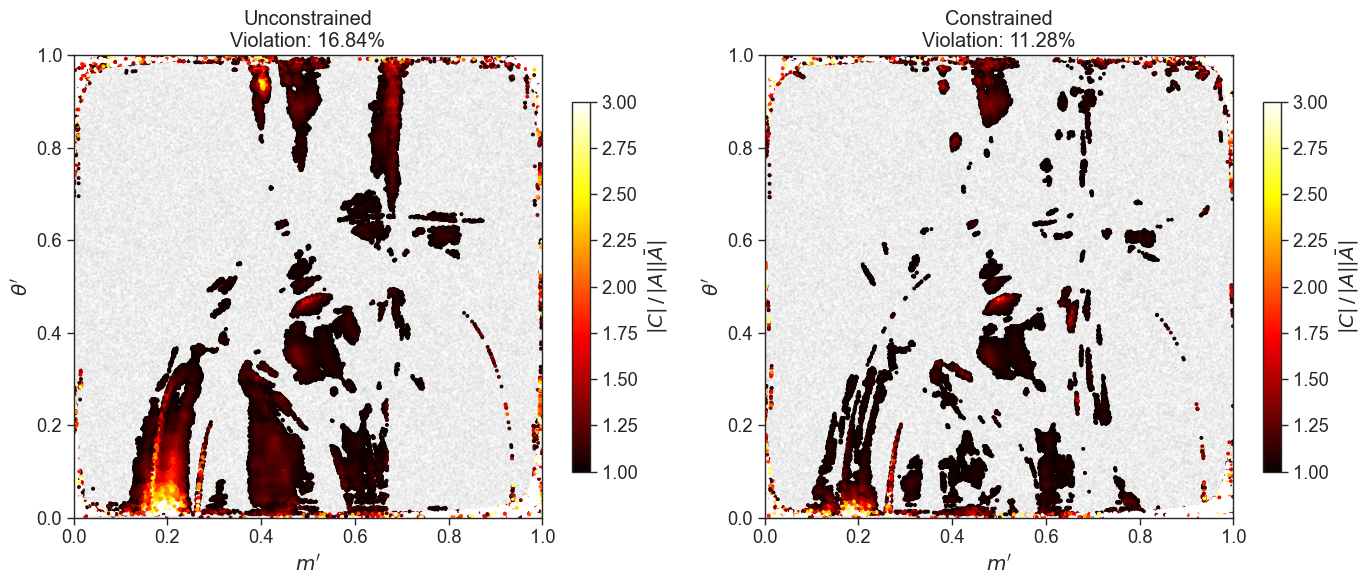

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, pts, viol, ratio, title in [
    (axes[0], pts_u, viol_u, ratio_u, 'Unconstrained'),
    (axes[1], pts_c, viol_c, ratio_c, 'Constrained'),
]:
    # Background: all points in light gray
    ax.scatter(pts[:, 0], pts[:, 1], c='lightgray', s=0.5, alpha=0.1, rasterized=True)
    
    # Violated points colored by severity
    if viol.any():
        sc = ax.scatter(pts[viol, 0], pts[viol, 1],
                        c=ratio[viol], cmap='hot', s=4, vmin=1.0,
                        vmax=min(ratio[viol].max(), 3.0), rasterized=True)
        plt.colorbar(sc, ax=ax, label=r'$|C|\,/\,|A||\bar{A}|$', shrink=0.8)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel(r"$m'$")
    ax.set_ylabel(r"$\theta'$")
    ax.set_title(f"{title}\nViolation: {viol.mean():.2%}")

plt.tight_layout()
plt.savefig('constraint_violation_comparison.pdf', dpi=150, bbox_inches='tight')
plt.show()

---
## 15. Tuning Guide

| Parameter | Effect | Recommended range |
|-----------|--------|------------------|
| `lam` | Penalty strength. Higher = fewer violations but worse NLL | 1–100 |
| `warmup_epochs` | Ramp-up period. Lets NLL converge before constraint kicks in | 10–30 |
| `num_epochs` | More epochs needed since the loss landscape is harder | 200–300 |

**Diagnostic checks:**
- If `violation_frac` doesn't decrease → increase `lam`
- If NLL is much worse than unconstrained → decrease `lam` or increase `warmup_epochs`
- If both NLL and violations are bad → model capacity may be too low; increase `num_flows` or `num_bins`